# Batchzahlen_Gesamt

In [178]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from math import floor
from datetime import date, timedelta

#for archiving
import os 
import argparse

#for reporting 
#import perf
from pandas.plotting import register_matplotlib_converters

from numpy import asarray
from pandas import read_csv
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
import random
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras import optimizers
from keras.models import Sequential, Model
from keras.layers.convolutional import Conv1D, MaxPooling1D
from keras.layers import Dense, LSTM, RepeatVector, TimeDistributed, Flatten, Dropout, Input, concatenate, ConvLSTM2D, MaxPooling2D,Conv2D, ConvLSTM1D
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from matplotlib.patches import ConnectionPatch
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import RepeatedKFold
from keras.wrappers.scikit_learn import KerasClassifier
import tensorflow as tf
import sklearn
import math
import keras

In [180]:
protokoll_path = r"00_Daten/abschreibung.csv"
abschreibungen = pd.read_csv(
    protokoll_path, encoding='unicode_escape', sep=";", error_bad_lines=True)

protokoll_path = r"00_Daten/test_datensatz.csv"
batchzahlen_gesamt = pd.read_csv(
    protokoll_path, encoding='unicode_escape', sep=";", error_bad_lines=True)

protokoll_path = r"00_Daten/dps_lagerbelegung.csv"
dps_lagerbelegung = pd.read_csv(
    protokoll_path, encoding='unicode_escape', sep=";", error_bad_lines=True)

protokoll_path = r"00_Daten/Filialen_Pro_Tag_DPS.csv"
filialen_Pro_Tag_DPS = pd.read_csv(
    protokoll_path, encoding='unicode_escape', sep=";", error_bad_lines=True)

protokoll_path = r"00_Daten/We_te_eingelagert.csv"
we_te_eingelagert = pd.read_csv(
    protokoll_path, encoding='unicode_escape', sep=";", error_bad_lines=True)


abschreibungen = abschreibungen[abschreibungen["Lager"] == "DPS"]
abschreibungen = abschreibungen[["Datum", "Anteil_in_Prozent"]]
abschreibungen.columns = ["Datum", "Abschreibung_in_Prozent"]

batchzahlen_gesamt = batchzahlen_gesamt[batchzahlen_gesamt["Lager"] == "DPS"]
batchzahlen_gesamt = batchzahlen_gesamt[["ï»¿Datum", "VPE_Gesamt"]]
batchzahlen_gesamt.columns = ["Datum", "Bestellzahlen_Gesamt"]

dps_lagerbelegung["Lager_Auslastung"] = dps_lagerbelegung["Belegt"] / dps_lagerbelegung["Gesamt"]
dps_lagerbelegung = dps_lagerbelegung[["Datum", "Lager_Auslastung"]]
dps_lagerbelegung.columns = ["Datum", "Lager_Auslastung"]


filialen_Pro_Tag_DPS = filialen_Pro_Tag_DPS[["Packdatum", "Filialen"]]
filialen_Pro_Tag_DPS.columns = ["Datum", "Filialen_Kommissioniert_Gesamt"]

we_te_eingelagert = we_te_eingelagert[we_te_eingelagert["Lager"] == "DPS"]
we_te_eingelagert = we_te_eingelagert[["Datum", "TE"]]
we_te_eingelagert.columns = ["Datum", "Te_Eingelagert"]

abschreibungen["Datum"] = pd.to_datetime(abschreibungen["Datum"])
batchzahlen_gesamt["Datum"] = pd.to_datetime(batchzahlen_gesamt["Datum"])
dps_lagerbelegung["Datum"] = pd.to_datetime(dps_lagerbelegung["Datum"])
filialen_Pro_Tag_DPS["Datum"] = pd.to_datetime(filialen_Pro_Tag_DPS["Datum"])
we_te_eingelagert["Datum"] = pd.to_datetime(we_te_eingelagert["Datum"])

#abschreibungen.set_index("Datum",inplace = True)
#batchzahlen_gesamt.set_index("Datum",inplace = True)
#dps_lagerbelegung.set_index("Datum",inplace = True)
#filialen_Pro_Tag_DPS.set_index("Datum",inplace = True)
#we_te_eingelagert.set_index("Datum",inplace = True)

In [181]:



batchzahlen_gesamt

,Datum,Bestellzahlen_Gesamt
0,2015-02-01,83685
1,2015-03-01,83810
2,2015-05-01,74101
3,2015-06-01,56912
4,2015-07-01,58630
...,...,...
2161,2022-01-26,58415
2162,2022-01-27,72304
2163,2022-01-28,54114
2164,2022-01-29,31217


In [182]:
batchzahlen_gesamt['year'] = pd.DatetimeIndex(batchzahlen_gesamt['Datum']).year
batchzahlen_gesamt['month'] = pd.DatetimeIndex(
    batchzahlen_gesamt['Datum']).month
batchzahlen_gesamt['week'] = pd.DatetimeIndex(
    batchzahlen_gesamt['Datum']).week
batchzahlen_gesamt['year_month'] = pd.to_datetime(
    batchzahlen_gesamt['Datum']).dt.to_period('M')
batchzahlen_gesamt['day'] = pd.DatetimeIndex(batchzahlen_gesamt['Datum']).day
batchzahlen_gesamt['day_of_week'] = batchzahlen_gesamt['Datum'].dt.day_name()
batchzahlen_gesamt.sort_values(by=['Datum'], ascending=True)
batchzahlen_gesamt.reset_index(drop=True, inplace=True)
batchzahlen_gesamt = batchzahlen_gesamt[batchzahlen_gesamt["day_of_week"] != "Sunday"]

<ipython-input-182-4cafe41cb00e>:4: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series.  To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
  batchzahlen_gesamt['week'] = pd.DatetimeIndex(


In [183]:
import datetime
import calendar

def week_of_month(tgtdate):
    #tgtdate = tgtdate.to_datetime()

    days_this_month = calendar.mdays[tgtdate.month]
    for i in range(1, days_this_month):
        d = datetime.datetime(tgtdate.year, tgtdate.month, i)
        if d.day - d.weekday() > 0:
            startdate = d
            break
    # now we canuse the modulo 7 appraoch
    return (tgtdate - startdate).days //7 + 1

#all_dates = all_dates.reset_index()
batchzahlen_gesamt['week_of_month'] = batchzahlen_gesamt["Datum"].apply(week_of_month)

<ipython-input-183-f8fbd590f23c>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batchzahlen_gesamt['week_of_month'] = batchzahlen_gesamt["Datum"].apply(week_of_month)


In [184]:
batchzahlen_gesamt

,Datum,Bestellzahlen_Gesamt,year,month,week,year_month,day,day_of_week,week_of_month
2,2015-05-01,74101,2015,5,18,2015-05,1,Friday,0
3,2015-06-01,56912,2015,6,23,2015-06,1,Monday,1
4,2015-07-01,58630,2015,7,27,2015-07,1,Wednesday,0
5,2015-08-01,72051,2015,8,31,2015-08,1,Saturday,0
6,2015-09-01,58041,2015,9,36,2015-09,1,Tuesday,0
...,...,...,...,...,...,...,...,...,...
2161,2022-01-26,58415,2022,1,4,2022-01,26,Wednesday,4
2162,2022-01-27,72304,2022,1,4,2022-01,27,Thursday,4
2163,2022-01-28,54114,2022,1,4,2022-01,28,Friday,4
2164,2022-01-29,31217,2022,1,4,2022-01,29,Saturday,4


In [185]:
batchzahlen_gesamt['day_of_week'] = batchzahlen_gesamt['day_of_week'].replace(['Monday'],'Montag')
batchzahlen_gesamt['day_of_week'] = batchzahlen_gesamt['day_of_week'].replace(['Tuesday'],'Dienstag')
batchzahlen_gesamt['day_of_week'] = batchzahlen_gesamt['day_of_week'].replace(['Wednesday'],'Mittwoch')
batchzahlen_gesamt['day_of_week'] = batchzahlen_gesamt['day_of_week'].replace(['Thursday'],'Donnerstag')
batchzahlen_gesamt['day_of_week'] = batchzahlen_gesamt['day_of_week'].replace(['Friday'],'Freitag')
batchzahlen_gesamt['day_of_week'] = batchzahlen_gesamt['day_of_week'].replace(['Saturday'],'Samstag')
batchzahlen_gesamt['day_of_week'] = batchzahlen_gesamt['day_of_week'].replace(['Sunday'],'Sonntag')


<ipython-input-185-057fccfbafcc>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batchzahlen_gesamt['day_of_week'] = batchzahlen_gesamt['day_of_week'].replace(['Monday'],'Montag')
<ipython-input-185-057fccfbafcc>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batchzahlen_gesamt['day_of_week'] = batchzahlen_gesamt['day_of_week'].replace(['Tuesday'],'Dienstag')
<ipython-input-185-057fccfbafcc>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_

In [186]:
batchzahlen_gesamt

,Datum,Bestellzahlen_Gesamt,year,month,week,year_month,day,day_of_week,week_of_month
2,2015-05-01,74101,2015,5,18,2015-05,1,Freitag,0
3,2015-06-01,56912,2015,6,23,2015-06,1,Montag,1
4,2015-07-01,58630,2015,7,27,2015-07,1,Mittwoch,0
5,2015-08-01,72051,2015,8,31,2015-08,1,Samstag,0
6,2015-09-01,58041,2015,9,36,2015-09,1,Dienstag,0
...,...,...,...,...,...,...,...,...,...
2161,2022-01-26,58415,2022,1,4,2022-01,26,Mittwoch,4
2162,2022-01-27,72304,2022,1,4,2022-01,27,Donnerstag,4
2163,2022-01-28,54114,2022,1,4,2022-01,28,Freitag,4
2164,2022-01-29,31217,2022,1,4,2022-01,29,Samstag,4


In [187]:
#a_dataframe.drop(a_dataframe[a_dataframe.B > 3].index, inplace=True)
# low = .03
# high = .97
# quant_df = batchzahlen_gesamt["Bestellzahlen_Gesamt"].quantile([low, high])
# print(quant_df)
# batchzahlen_gesamt = batchzahlen_gesamt[batchzahlen_gesamt["Bestellzahlen_Gesamt"] < 
#                    np.percentile(batchzahlen_gesamt["Bestellzahlen_Gesamt"], 97)]
# batchzahlen_gesamt = batchzahlen_gesamt[batchzahlen_gesamt["Bestellzahlen_Gesamt"] > 
#                    np.percentile(batchzahlen_gesamt["Bestellzahlen_Gesamt"], 3)]

In [188]:
batchzahlen_gesamt

,Datum,Bestellzahlen_Gesamt,year,month,week,year_month,day,day_of_week,week_of_month
2,2015-05-01,74101,2015,5,18,2015-05,1,Freitag,0
3,2015-06-01,56912,2015,6,23,2015-06,1,Montag,1
4,2015-07-01,58630,2015,7,27,2015-07,1,Mittwoch,0
5,2015-08-01,72051,2015,8,31,2015-08,1,Samstag,0
6,2015-09-01,58041,2015,9,36,2015-09,1,Dienstag,0
...,...,...,...,...,...,...,...,...,...
2161,2022-01-26,58415,2022,1,4,2022-01,26,Mittwoch,4
2162,2022-01-27,72304,2022,1,4,2022-01,27,Donnerstag,4
2163,2022-01-28,54114,2022,1,4,2022-01,28,Freitag,4
2164,2022-01-29,31217,2022,1,4,2022-01,29,Samstag,4


In [213]:
wochentage = ["Montag", "Dienstag", "Mittwoch", "Donnerstag", "Freitag", "Samstag", "Sonntag"]
df = pd.DataFrame(columns=list(batchzahlen_gesamt.columns))
for i in range(0,len(wochentage) -1):
    day = batchzahlen_gesamt[batchzahlen_gesamt["day_of_week"] == wochentage[i]]
    day = day[day["Bestellzahlen_Gesamt"] < np.percentile(day["Bestellzahlen_Gesamt"], 97)]
    day = day[day["Bestellzahlen_Gesamt"] > np.percentile(day["Bestellzahlen_Gesamt"], 3)]
    df = pd.concat([df,day])
batchzahlen_gesamt = df.sort_index()

In [214]:
# "broken" (staggered) dates
dates =batchzahlen_gesamt["Datum"]
all_dates = pd.Series(batchzahlen_gesamt["Bestellzahlen_Gesamt"].tolist(), dates)
all_dates = all_dates.asfreq('D')
all_dates.interpolate(method='time', inplace=True)
all_dates = all_dates.to_frame().reset_index()
all_dates = all_dates.rename(columns= {0: 'Bestellzahlen_Gesamt'})

In [215]:

all_dates

,Datum,Bestellzahlen_Gesamt
0,2015-05-01,74101.0
1,2015-05-02,67059.0
2,2015-05-03,64851.0
3,2015-05-04,62643.0
4,2015-05-05,60435.0
...,...,...
2463,2022-01-27,72304.0
2464,2022-01-28,54114.0
2465,2022-01-29,31217.0
2466,2022-01-30,40178.5


In [216]:
all_dates['year'] = pd.DatetimeIndex(all_dates['Datum']).year
all_dates['day_of_week'] = all_dates['Datum'].dt.day_name()

only_since_2017 = all_dates[all_dates["year"] >= 2018 ]
only_since_2017.reset_index(drop=True, inplace=True)

all_dates.set_index("Datum",inplace = True)

In [217]:
only_since_2017

,Datum,Bestellzahlen_Gesamt,year,day_of_week
0,2018-01-01,51599.8,2018,Monday
1,2018-01-02,52839.0,2018,Tuesday
2,2018-01-03,58798.0,2018,Wednesday
3,2018-01-04,50246.5,2018,Thursday
4,2018-01-05,41695.0,2018,Friday
...,...,...,...,...
1487,2022-01-27,72304.0,2022,Thursday
1488,2022-01-28,54114.0,2022,Friday
1489,2022-01-29,31217.0,2022,Saturday
1490,2022-01-30,40178.5,2022,Sunday


In [218]:
all_dates

,Bestellzahlen_Gesamt,year,day_of_week
Datum,,,
2015-05-01,74101.0,2015,Friday
2015-05-02,67059.0,2015,Saturday
2015-05-03,64851.0,2015,Sunday
2015-05-04,62643.0,2015,Monday
2015-05-05,60435.0,2015,Tuesday
...,...,...,...
2022-01-27,72304.0,2022,Thursday
2022-01-28,54114.0,2022,Friday
2022-01-29,31217.0,2022,Saturday


# Preprocessing

## Äquivalente Monate letzten 3 Jahre

In [177]:
n_steps = 200
steps_3_monate = 200
steps_year = 200

X = []
Y = []
i = 0
for i in range(7, len(only_since_2017) - 6 - steps_3_monate): 
    Y.append(only_since_2017.loc[i + steps_year: i + steps_year + 6 ,"Bestellzahlen_Gesamt"])

    a = all_dates.loc[only_since_2017.loc[i,"Datum"]:
                      only_since_2017.loc[i,"Datum"] + timedelta(steps_year -1),
                      "Bestellzahlen_Gesamt"]

    ss = pd.concat([a])
    ss = ss[::-1]
    X.append(np.array(ss))


X0 = np.array(X).reshape(-1, n_steps, 1)
Y0 = np.array(Y)

In [219]:
steps_3_monate = 90


In [220]:
n_steps = 90
steps_year = 30

X = []
Y = []
i = 0
for i in range(7, len(only_since_2017) - 6 - steps_3_monate): 
    Y.append(only_since_2017.loc[i + steps_year: i + steps_year + 6 ,"Bestellzahlen_Gesamt"])

    a = all_dates.loc[only_since_2017.loc[i,"Datum"]:
                      only_since_2017.loc[i,"Datum"] + timedelta(steps_year -1),
                      "Bestellzahlen_Gesamt"]
    

    b = all_dates.loc[only_since_2017.loc[i,"Datum"] - timedelta(365): 
                      only_since_2017.loc[i,"Datum"] - timedelta(365 - steps_year +1),
                      "Bestellzahlen_Gesamt"]
    
    c = all_dates.loc[only_since_2017.loc[i,"Datum"] - timedelta(365 * 2):
                      only_since_2017.loc[i,"Datum"] - timedelta(365 * 2 - steps_year +1) ,
                      "Bestellzahlen_Gesamt"]

    ss = pd.concat([c,b,a])
    ss = ss[::-1]
    print(len(ss))
    X.append(np.array(ss))

print(len(X))
X1 = np.array(X).reshape(-1, n_steps, 1)
Y1 = np.array(Y)

90
90
90
90
90
90
90
90
90
90
90
90
90
90
90
90
90
90
90
90
90
90
90
90
90
90
90
90
90
90
90
90
90
90
90
90
90
90
90
90
90
90
90
90
90
90
90
90
90
90
90
90
90
90
90
90
90
90
90
90
90
90
90
90
90
90
90
90
90
90
90
90
90
90
90
90
90
90
90
90
90
90
90
90
90
90
90
90
90
90
90
90
90
90
90
90
90
90
90
90
90
90
90
90
90
90
90
90
90
90
90
90
90
90
90
90
90
90
90
90
90
90
90
90
90
90
90
90
90
90
90
90
90
90
90
90
90
90
90
90
90
90
90
90
90
90
90
90
90
90
90
90
90
90
90
90
90
90
90
90
90
90
90
90
90
90
90
90
90
90
90
90
90
90
90
90
90
90
90
90
90
90
90
90
90
90
90
90
90
90
90
90
90
90
90
90
90
90
90
90
90
90
90
90
90
90
90
90
90
90
90
90
90
90
90
90
90
90
90
90
90
90
90
90
90
90
90
90
90
90
90
90
90
90
90
90
90
90
90
90
90
90
90
90
90
90
90
90
90
90
90
90
90
90
90
90
90
90
90
90
90
90
90
90
90
90
90
90
90
90
90
90
90
90
90
90
90
90
90
90
90
90
90
90
90
90
90
90
90
90
90
90
90
90
90
90
90
90
90
90
90
90
90
90
90
90
90
90
90
90
90
90
90
90
90
90
90
90
90
90
90
90
90
90
90
90
90
90
90
90
90
90
90
9

## Äquivalente Woche Davor und danach 

In [221]:
n_steps = 42
steps_week = 5

X = []
Y = []
check = []
i = 0
for i in range(7, len(only_since_2017) - 6 - steps_3_monate): 
    Y.append(only_since_2017.loc[i + steps_year: i + steps_year + 6 ,"Bestellzahlen_Gesamt"])
    
    a = all_dates.loc[only_since_2017.loc[i,"Datum"] - timedelta(365 - steps_week * 4): 
                      only_since_2017.loc[i,"Datum"] - timedelta(365 - steps_week * 8),
                      "Bestellzahlen_Gesamt"]
 
    b = all_dates.loc[only_since_2017.loc[i,"Datum"] - timedelta(365 * 2 - steps_week * 4):
                      only_since_2017.loc[i,"Datum"] - timedelta(365 * 2 - steps_week * 8),
                      "Bestellzahlen_Gesamt"]
    
    
    ss = pd.concat([b,a])
    ss = ss[::-1]
    
    X.append(np.array(ss))



X2 = np.array(X).reshape(-1, n_steps, 1)
Y2 = np.array(Y)

In [ ]:
X2.shape

## Äquivalente KW Im Monat letzten Monate 

In [222]:
n_steps = 7 * 6
steps_year = 30

X = []
Y = []
i = 0
for i in range(7, len(only_since_2017) - 6 - steps_3_monate): 
    Y.append(only_since_2017.loc[i + steps_year: i + steps_year + 6 ,"Bestellzahlen_Gesamt"])

    a = all_dates.loc[str((only_since_2017.loc[i + steps_year,"Datum"] - pd.DateOffset(days=28)).date()) :
             str((only_since_2017.loc[i + steps_year + 6,"Datum"] - pd.DateOffset(days=28)).date()),"Bestellzahlen_Gesamt"]
    
    b = all_dates.loc[str((only_since_2017.loc[i + steps_year,"Datum"] - pd.DateOffset(days=28 + 35)).date()) :
             str((only_since_2017.loc[i + steps_year + 6,"Datum"] - pd.DateOffset(days=28 + 35)).date()),"Bestellzahlen_Gesamt"]
        
    c = all_dates.loc[str((only_since_2017.loc[i + steps_year,"Datum"] - pd.DateOffset(days= 28 + 35 + 28)).date()) :
             str((only_since_2017.loc[i + steps_year + 6,"Datum"] - pd.DateOffset(days= 28 + 35 +28)).date()),"Bestellzahlen_Gesamt"]
    
    d = all_dates.loc[str((only_since_2017.loc[i + steps_year,"Datum"] - pd.DateOffset(days=28 + 35 +28 +35)).date()) :
             str((only_since_2017.loc[i + steps_year + 6,"Datum"] - pd.DateOffset(days=28 + 35 +28 +35)).date()),"Bestellzahlen_Gesamt"]
        
    e = all_dates.loc[str((only_since_2017.loc[i + steps_year,"Datum"] - pd.DateOffset(days=28 + 35 +28 +35 +28)).date()) :
             str((only_since_2017.loc[i + steps_year + 6,"Datum"] - pd.DateOffset(days=28 + 35 +28 +35 +28 )).date()),"Bestellzahlen_Gesamt"]
    
    f = all_dates.loc[str((only_since_2017.loc[i + steps_year,"Datum"] - pd.DateOffset(days=28 + 35 +28 +35 +28 +35)).date()) :
             str((only_since_2017.loc[i + steps_year + 6,"Datum"] - pd.DateOffset(days=28 + 35 +28 +35 +28 +35 )).date()),"Bestellzahlen_Gesamt"]
    
        
        

    ss = pd.concat([f,e,d,c,b,a])
    ss = ss[::-1]
    
    X.append(np.array(ss))


X3 = np.array(X).reshape(-1, n_steps, 1)
Y3 = np.array(Y)

In [97]:
Y3.shape

(0,)

## Andere Daten 

In [24]:
#abschreibungen.set_index("Datum",inplace = True)
only_since_2017.set_index("Datum",inplace = True)
dps_lagerbelegung.set_index("Datum",inplace = True)
filialen_Pro_Tag_DPS.set_index("Datum",inplace = True)
we_te_eingelagert.set_index("Datum",inplace = True)

In [25]:
merge=pd.merge(only_since_2017,dps_lagerbelegung, how='left', left_index=True, right_index=True)
merge=pd.merge(merge,filialen_Pro_Tag_DPS, how='left', left_index=True, right_index=True)
merged =pd.merge(merge,we_te_eingelagert, how='left', left_index=True, right_index=True)
only_since_2017.reset_index(drop=False, inplace=True)

In [26]:
merged.interpolate(method='linear', inplace=True)

In [27]:
#2017-02-07 erster welcher vorhergesagt wird.
mer = merged[(merged.index >= "2017-01-28") & (merged.index <= "2021-11-03") ]

In [28]:
n_steps_lager_auslastung = 4
n_steps_lager_Filialen = 10
n_steps_Te_eingelagert = 10 
i = 0
X4 = []
X5 = []
X6 = []
Y = []
check = []

for i in range(7, len(only_since_2017) - 6 - steps_3_monate): 
    
    Y.append(only_since_2017.loc[i + steps_year: i + steps_year + 6 ,"Bestellzahlen_Gesamt"])
    check.append(only_since_2017.loc[i + steps_year: i + steps_year + 6 ,:])
    
    a = mer.loc[only_since_2017.loc[i,"Datum"] + timedelta(steps_year -n_steps_lager_auslastung) :
                only_since_2017.loc[i,"Datum"] + timedelta(steps_year -1),
                "Lager_Auslastung"]
    
    b = mer.loc[only_since_2017.loc[i,"Datum"] + timedelta(steps_year -n_steps_lager_Filialen) :
                only_since_2017.loc[i,"Datum"] + timedelta(steps_year -1),
                "Filialen_Kommissioniert_Gesamt"]
        
    c = mer.loc[only_since_2017.loc[i,"Datum"] + timedelta(steps_year -n_steps_Te_eingelagert) :
                only_since_2017.loc[i,"Datum"] + timedelta(steps_year -1),
                "Te_Eingelagert"]

    

    aa = a[::-1]
    X4.append(np.array(aa))
    bb = b[::-1]
    X5.append(np.array(bb))
    cc = c[::-1]
    X6.append(np.array(cc))

X4 = np.array(X4).reshape(-1, n_steps_lager_auslastung, 1)
X5 = np.array(X5).reshape(-1, n_steps_lager_Filialen, 1)
X6 = np.array(X6).reshape(-1, n_steps_Te_eingelagert, 1)
Y3 = np.array(Y)

In [29]:
print(np.array_equal(Y1,Y2))
print(np.array_equal(Y2,Y3))

True
True


In [30]:
only_since_2017["Bestellzahlen_Gesamt"].is_unique

False

In [31]:
X6.shape

(1689, 10, 1)

In [32]:
print(X1.shape)
print(X2.shape)
print(X3.shape)
print(X4.shape)
print(X5.shape)
print(X6.shape)

(1689, 90, 1)
(1689, 42, 1)
(1689, 42, 1)
(1689, 4, 1)
(1689, 10, 1)
(1689, 10, 1)


In [33]:
X0.shape

(1579, 200, 1)

# Model bauen 

In [60]:
X0_train,X0_test, y_train,y_test = train_test_split(X0, Y0, test_size=0.2,  random_state=46, shuffle = False)

In [229]:
only_since_2017.tail(20)

,Datum,Bestellzahlen_Gesamt,year,day_of_week
1472,2022-01-12,67458.357143,2022,Wednesday
1473,2022-01-13,68453.000000,2022,Thursday
1474,2022-01-14,51343.000000,2022,Friday
1475,2022-01-15,32667.000000,2022,Saturday
1476,2022-01-16,41132.000000,2022,Sunday
1477,2022-01-17,49597.000000,2022,Monday
1478,2022-01-18,56767.000000,2022,Tuesday
1479,2022-01-19,59135.000000,2022,Wednesday
1480,2022-01-20,65836.000000,2022,Thursday
1481,2022-01-21,51962.000000,2022,Friday


In [228]:
y_test


array([[61172.        , 63160.        , 65148.        , 61709.        ,
        64894.        , 48006.        , 30299.        ],
       [63160.        , 65148.        , 61709.        , 64894.        ,
        48006.        , 30299.        , 40328.        ],
       [65148.        , 61709.        , 64894.        , 48006.        ,
        30299.        , 40328.        , 50357.        ],
       [61709.        , 64894.        , 48006.        , 30299.        ,
        40328.        , 50357.        , 60386.        ],
       [64894.        , 48006.        , 30299.        , 40328.        ,
        50357.        , 60386.        , 58895.        ],
       [48006.        , 30299.        , 40328.        , 50357.        ,
        60386.        , 58895.        , 64466.        ],
       [30299.        , 40328.        , 50357.        , 60386.        ,
        58895.        , 64466.        , 47249.        ],
       [40328.        , 50357.        , 60386.        , 58895.        ,
        64466.        , 4

In [231]:
y_train

array([[62158.4, 65275. , 57823.5, ..., 48432. , 46492. , 44552. ],
       [65275. , 57823.5, 50372. , ..., 46492. , 44552. , 49509. ],
       [57823.5, 50372. , 48432. , ..., 44552. , 49509. , 58373. ],
       ...,
       [62893.5, 63042. , 59184. , ..., 63160. , 65148. , 61709. ],
       [63042. , 59184. , 61172. , ..., 65148. , 61709. , 64894. ],
       [59184. , 61172. , 63160. , ..., 61709. , 64894. , 48006. ]])

In [98]:
X1_train, X1_test,X2_train, X2_test,X3_train, X3_test,X4_train,X4_test,X5_train,X5_test,X6_train,X6_test, y_train, y_test = train_test_split(
    X1,X2,X3,X4,X5,X6, Y1, test_size=0.1,  random_state=46, shuffle = False)

ValueError: Found input variables with inconsistent numbers of samples: [0, 0, 0, 1689, 1689, 1689, 0]

In [230]:
X1_train, X1_test,X2_train, X2_test,X3_train, X3_test,y_train, y_test = train_test_split(
    X1,X2,X3, Y1, test_size=0.1,  random_state=46, shuffle = False)

In [38]:
training = X1_train

In [ ]:
print(X1_train.shape)
print(X2_train.shape)
print(X3_train.shape)
print(X4_train.shape)
print(X5_train.shape)

print(X1_test.shape)
print(X2_test.shape)
print(X3_test.shape)
print(X4_test.shape)
print(X5_test.shape)

# Naives Forecasting

In [46]:
mse_naives_forecasting_multi = sklearn.metrics.mean_squared_error(Y1[1:,:], Y1[0:Y1.shape[0] -1,:])
mae_naives_forecasting_multi = sklearn.metrics.mean_absolute_error(Y1[1:,:], Y1[0:Y1.shape[0] -1,:])
mape_naives_forecasting_multi = sklearn.metrics.mean_absolute_percentage_error(Y1[1:,:], Y1[0:Y1.shape[0] -1,:])
print("Naives Forecasting")
print("RMSE_Naive: %s" % round(math.sqrt(mse_naives_forecasting_multi),2))
print("MAE_Naive: %s" % round(mae_naives_forecasting_multi,2))
print("MAPE_Naive: %s" % round(mape_naives_forecasting_multi,2))
print("")



Naives Forecasting
RMSE_Naive: 14151.96
MAE_Naive: 11831.02
MAPE_Naive: 0.23



In [47]:
protokoll_path = r"00_Daten/prog_dez.csv"
prog_dez = pd.read_csv(
    protokoll_path, encoding='unicode_escape', sep=";", error_bad_lines=True)

In [48]:
prog_dez.columns = ["DPS","PRE","REAL"]

ValueError: Length mismatch: Expected axis has 5 elements, new values have 3 elements

In [ ]:
prog_dez

In [58]:
try:
    mse = math.sqrt(sklearn.metrics.mean_squared_error(prog_dez["REAL"], prog_dez["DPS"]))
    mae = sklearn.metrics.mean_absolute_error(prog_dez["REAL"], prog_dez["DPS"])
    mape = sklearn.metrics.mean_absolute_percentage_error(prog_dez["REAL"], prog_dez["DPS"])
except Exception as e:
    print("An exception occurred: ", e)
        
print("Naives Forecasting")
print("RMSE_Naive: %s" % round(mse,2))
print("MAE_Naive: %s" % round(mae,2))
print("MAPE_Naive: %s" % round(mape,2))
print("")


An exception occurred:  'REAL'
Naives Forecasting


NameError: name 'mse' is not defined

# Univariate Modelle

In [40]:
x_axis = model_history_cnn.history["loss"]
x_axis.sort()

 
lrs = 1e-8 * (10 ** (np.arange(len(model_history_cnn.history["loss"])) / 20))
plt.semilogx(lrs,model_history_cnn.history["loss"])
plt.axis([1e-12,1e-2,x_axis[0] -5000,x_axis[-4]])

NameError: name 'model_history_cnn' is not defined

In [ ]:

#lr_schedule = tf.keras.callbacks.LearningRateScheduler(
                   #lambda epoch: 1e-8 * 10**(epoch / 20))

#model_history_cnn = model_cnn.fit(X1_train, y_train, 
                                  #validation_data=(X1_test, y_test), 
                                  #epochs=100,
                                  #batch_size=batch_size,
                                  #callbacks=[lr_schedule],
                                  #verbose=2)
#86

In [ ]:
# define evaluation
filters = 64
kernel_size = 8
pool_size = 3
dropout = 0.2
dense = 200
epochs = 100
batch_size = 16

param_grid = [
    {"epochs": [50,100,150,200], "batch_size": [16,32,64,128],
    "filters": [128,64,32], "kernel_size": [2,4,8],"pool_size" : [2,4,6]},]


cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
model = KerasClassifier(build_fn=get_model, verbose=1)
# define search
search = RandomizedSearchCV(estimator=model, param_distributions=param_grid, n_iter=2, scoring='neg_mean_absolute_error', n_jobs=-1, cv=3, random_state=1)
# execute search
result = search.fit(X1_train, y_train,validation_data=(X1_test, y_test), verbose = 1)

# summarize result
print('Best Score: %s' % result.best_score_)
print('Best Hyperparameters: %s' % result.best_params_)
# Show the results
print("Best: %f using %s" % (search.best_score_, search.best_params_))
means = search.cv_results_['mean_test_score']
stds = search.cv_results_['std_test_score']
params = search.cv_results_['params']

for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

In [ ]:
filters = 64
kernel_size = 8
pool_size = 3
dropout = 0.2
dense = 200
epochs = 100
batch_size = 16

param_grid = [
    {"epochs": [50,100,150,200], "batch_size": [16,32,64,128],
    "filters": [128,64,32], "kernel_size": [2,4,8],"pool_size" : [2,4,6]},]

In [ ]:
import os 
root_logdir = or.path.join(os.curdir, "my_logs")

def get_run_logdir():
    import time 
    run_id = time.strftime("run_%Y_%m_%d-%H_%M_%S")
    return os.path.join(root_logdir, run_id)

run_logdir = get_run_logdir()

tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)
#para fit -> callbacks=[tensorboard_cb]

## CNN

In [40]:
def get_model_cnn(filters=2,kernel_size=4,pool_size=2,optimizer = "adam", loss = "mse", training= training):
    model_cnn = Sequential()
    model_cnn.add(Conv1D(filters=filters, kernel_size=kernel_size, activation='relu', input_shape=(training.shape[1],
    training.shape[2])))
    model_cnn.add(MaxPooling1D(pool_size=pool_size))
    model_cnn.add(Flatten())
    #model_cnn.add(Dropout(0.2))
    model_cnn.add(Dense(30, activation='relu'))
    model_cnn.add(Dense(7))
    model_cnn.compile(optimizer=optimizer, loss=loss)
    #model_cnn.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), 
                      #loss=tf.keras.losses.Huber())
                      #loss= "mse"
    return model_cnn

def fit_model_cnn(filters,kernel_size,pool_size,
                  epochs, batch_size,training, 
                  y_train, test, y_test,verbose,optimizer ,loss):
    
    model_cnn = get_model_cnn(filters,kernel_size,pool_size,optimizer,loss,training)
    model_history_cnn = model_cnn.fit(training, y_train, 
                                  validation_data=(test, y_test), 
                                  epochs=epochs,
                                  batch_size=batch_size,
                                  verbose= verbose)

    return model_history_cnn, model_cnn,[test]

    
    

   


## LSTM / RNN

In [41]:
def get_model_lstm1(lstm_units,optimizer,loss,training):
    model_lstm1 = Sequential()
    model_lstm1.add(LSTM(40, activation='relu', return_sequences=True, input_shape=(training.shape[1],training.shape[2])))
   # model_lstm1.add(LSTM(25, activation='relu', return_sequences=Dense))
    model_lstm1.add(LSTM(20, activation='relu'))
    model_lstm1.add(Dense(20, activation='relu'))
    model_lstm1.add(Dense(7)) 
    model_lstm1.compile(optimizer=optimizer, loss=loss)
    return model_lstm1

def fit_model_lstm1(lstm_units,optimizer,loss,training,y_train,test,y_test,epochs,batch_size,verbose):
    model_lstm1 = get_model_lstm1(lstm_units,optimizer,loss,training)
    model_lstm1_history = model_lstm1.fit(training, y_train, validation_data=(test, y_test), 
                                          epochs=epochs,batch_size= batch_size,
                                          verbose=verbose)
    return model_lstm1_history, model_lstm1

In [42]:
def get_model_lstm2(lstm_units,optimizer,loss,training):
    model_lstm2 = Sequential()
    model_lstm2.add(LSTM(lstm_units, activation='relu', input_shape=(training.shape[1], training.shape[2])))
    model_lstm2.add(Dense(7))
    model_lstm2.compile(loss=loss, optimizer=optimizer)
    return model_lstm2

def fit_model_lstm2(lstm_units,optimizer,loss,training,y_train,test,y_test,epochs,batch_size,verbose):
    model_lstm2 = get_model_lstm2(lstm_units,optimizer,loss,training)
    model_lstm2_history = model_lstm2.fit(training, y_train, validation_data=(test, y_test), 
                                          epochs=epochs,batch_size= batch_size,
                                          verbose=verbose)
    return model_lstm2_history, model_lstm2
    
    


### Lstm Bidiectional

In [43]:
def get_model_lstm_bidirectional(lstm_units,optimizer,loss,training):
    model_lstm_bi = tf.keras.models.Sequential([
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(lstm_units, return_sequences=True),input_shape=(training.shape[1], training.shape[2])),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(units = int(lstm_units/2))),
        tf.keras.layers.Dense(30),
        tf.keras.layers.Dense(7)
        #tf.keras.layers.Lambda(lambda x: x * 100.0)
    ])
    model_lstm_bi.compile(loss=loss, optimizer=optimizer)
    return model_lstm_bi
    
def fit_model_lstm_bidirectional(lstm_units,optimizer,loss,training,y_train,test,y_test,epochs,batch_size,verbose):
    model_lstm_bi = get_model_lstm_bidirectional(lstm_units,optimizer,loss,training)
    model_lstm_bi_history = model_lstm_bi.fit(training, y_train, validation_data=(test, y_test), 
                                          epochs=epochs,batch_size= batch_size,
                                          verbose=verbose)
    return model_lstm_bi_history, model_lstm_bi

## LSTM_CNN

In [44]:
def get_model_lstm_cnn(filters,kernel_size,pool_size,lstm_units,optimizer,loss,training_series_sub):

    #print('Train set shape', training_series_sub.shape)
    #print('Validation set shape', test_series_sub.shape)

    model_cnn_lstm = Sequential()
    model_cnn_lstm.add(TimeDistributed(Conv1D(filters=filters, kernel_size=kernel_size, activation='relu'), 
                                       input_shape=(None, training_series_sub.shape[2], training_series_sub.shape[3])))
    model_cnn_lstm.add(TimeDistributed(MaxPooling1D(pool_size=pool_size)))
    model_cnn_lstm.add(TimeDistributed(Flatten()))
    model_cnn_lstm.add(LSTM(lstm_units, activation='relu'))
    model_cnn_lstm.add(Dense(7))
    model_cnn_lstm.compile(loss=loss, optimizer=optimizer)
    return model_cnn_lstm
    
def fit_model_lstm_cnn(filters,kernel_size,pool_size,lstm_units,optimizer,
                       loss,training,y_train,test,y_test,epochs,batch_size,verbose):
    subsequences = 2
    timesteps = training.shape[1]//subsequences
    training_series_sub = training.reshape((training.shape[0], subsequences, timesteps, 1))
    test_series_sub = test.reshape((test.shape[0], subsequences, timesteps, 1))
    
    model_cnn_lstm = get_model_lstm_cnn(filters,kernel_size,pool_size,lstm_units,optimizer,loss,training_series_sub)
    
    cnn_lstm_history = model_cnn_lstm.fit(training_series_sub, y_train, 
                                          validation_data=(test_series_sub, y_test), 
                                          epochs=epochs, verbose=verbose, batch_size = batch_size)
    return cnn_lstm_history, model_cnn_lstm, test_series_sub
    


# Encoder Decoder

In [45]:
#y_train_re = y_train.reshape((y_train.shape[0], y_train.shape[1], 1))
#y_test_re  = y_test.reshape((y_test.shape[0], y_test.shape[1], 1))

## CNN-LSTM Encoder Decoder

In [46]:
#S 418
def get_model_E_D_lstm_cnn(filters, kernel_size,pool_size,lstm_units,loss,optimizer,training,y_train_re):
    # define model
    model_E_D_lstm_cnn = Sequential()
    model_E_D_lstm_cnn.add(Conv1D(filters=filters, kernel_size=kernel_size, activation='relu',
                                  input_shape=(training.shape[1],training.shape[2])))
    model_E_D_lstm_cnn.add(Conv1D(filters=filters, kernel_size=kernel_size, activation='relu')) 
    model_E_D_lstm_cnn.add(MaxPooling1D(pool_size=pool_size))
    model_E_D_lstm_cnn.add(Flatten())
    model_E_D_lstm_cnn.add(RepeatVector(y_train_re.shape[1]))
    model_E_D_lstm_cnn.add(LSTM(lstm_units, activation='relu', return_sequences=True)) 
    model_E_D_lstm_cnn.add(TimeDistributed(Dense(100, activation='relu'))) 
    model_E_D_lstm_cnn.add(TimeDistributed(Dense(1)))
    model_E_D_lstm_cnn.compile(loss=loss, optimizer=optimizer)
    return model_E_D_lstm_cnn
# fit network
def fit_model_E_D_lstm_cnn(filters, kernel_size,pool_size,lstm_units,loss,optimizer,
                           training,test,epochs,verbose,batch_size,y_train,y_test):
    
    y_train_re = y_train.reshape((y_train.shape[0], y_train.shape[1], 1))
    y_test_re  = y_test.reshape((y_test.shape[0], y_test.shape[1], 1))
    
    model_E_D_lstm_cnn = get_model_E_D_lstm_cnn(filters, kernel_size,pool_size,lstm_units,loss,
                                                optimizer,training,y_train_re)
    
    model_E_D_lstm_cnn_history = model_E_D_lstm_cnn.fit(training, y_train_re, 
                                                        validation_data=(test, y_test_re),
                                                        epochs=epochs, verbose=verbose, batch_size = batch_size)
    return model_E_D_lstm_cnn_history, model_E_D_lstm_cnn


## Encoder Decoder LSTM

In [47]:
#S 406 #S 413
# Encoder Decoder LSTM with unicvariante Input

#n_timesteps, n_features, n_outputs = train_x.shape[1], train_x.shape[2], train_y.shape[1] # reshape output into [samples, timesteps, features]
#train_y = train_y.reshape((train_y.shape[0], train_y.shape[1], 1))
# define model
def get_model_E_D_lstm(lstm_units,loss,optimizer,training,y_train_re):
    model_E_D_lstm = Sequential()
    model_E_D_lstm.add(LSTM(lstm_units, activation='relu', input_shape=(training.shape[1],training.shape[2]))) 
    model_E_D_lstm.add(RepeatVector(y_train_re.shape[1]))
    model_E_D_lstm.add(LSTM(lstm_units, activation='relu', return_sequences=True)) 
    model_E_D_lstm.add(TimeDistributed(Dense(50, activation='relu'))) 
    model_E_D_lstm.add(TimeDistributed(Dense(1)))
    model_E_D_lstm.compile(loss=loss, optimizer=optimizer)
    return model_E_D_lstm
    # fit network
def fit_model_E_D_lstm(lstm_units,loss,optimizer,
                       training,test,epochs,verbose,y_train,y_test,
                       batch_size):
    
    y_train_re = y_train.reshape((y_train.shape[0], y_train.shape[1], 1))
    y_test_re  = y_test.reshape((y_test.shape[0], y_test.shape[1], 1))
    
    model_E_D_lstm = get_model_E_D_lstm(lstm_units,loss,optimizer,training,y_train_re)
    
    model_E_D_lstm_history = model_E_D_lstm.fit(training, y_train_re, 
                                                validation_data=(test, y_test_re), 
                                                epochs=epochs, verbose=verbose, batch_size = batch_size)
    return model_E_D_lstm_history, model_E_D_lstm


## ConvLSTM Encoder Decoder

In [48]:

#train_re = training.reshape(training.shape[0],1, 1, training.shape[1], training.shape[2])
#test_re = test.reshape(test.shape[0],1, 1, test.shape[1], test.shape[2])

In [49]:
#S 424
# define model
def get_model_ConvLSTM(filters,lstm_units,loss,optimizer,training,y_train_re):
    ConvLSTM_D_E = Sequential()
    ConvLSTM_D_E.add(ConvLSTM2D(filters=filters, kernel_size=(1,3), activation='relu',
    input_shape=(1, 1, training.shape[1], training.shape[2]))) 
    ConvLSTM_D_E.add(Flatten())
    ConvLSTM_D_E.add(RepeatVector(y_train_re.shape[1]))
    ConvLSTM_D_E.add(LSTM(lstm_units, activation='relu', return_sequences=True))
    ConvLSTM_D_E.add(TimeDistributed(Dense(100, activation='relu'))) 
    ConvLSTM_D_E.add(TimeDistributed(Dense(1)))
    ConvLSTM_D_E.compile(loss=loss, optimizer=optimizer)
    return ConvLSTM_D_E

def fit_model_ConvLSTM(filters,lstm_units,loss,optimizer,
                       training,y_train,y_test,test,epochs,verbose,batch_size): 
    
    train_re = training.reshape(training.shape[0],1, 1, training.shape[1], training.shape[2])
    test_re = test.reshape(test.shape[0],1, 1, test.shape[1], test.shape[2])
    
    y_train_re = y_train.reshape((y_train.shape[0], y_train.shape[1], 1))
    y_test_re  = y_test.reshape((y_test.shape[0], y_test.shape[1], 1))
    
    ConvLSTM_D_E = get_model_ConvLSTM(filters,lstm_units,loss,optimizer,training,y_train_re)
    
    model_ConvLSTM_D_E_history = ConvLSTM_D_E.fit(train_re, y_train_re, 
                                         validation_data=(test_re, y_test_re), 
                                         epochs=epochs, verbose=verbose, batch_size = batch_size)
    
    return model_ConvLSTM_D_E_history,ConvLSTM_D_E,test_re


In [69]:
#S 424
# define model
def get_model_ConvLSTM(filters,lstm_units,loss,optimizer,training,y_train_re):
    ConvLSTM_D_E = Sequential()
    ConvLSTM_D_E.add(ConvLSTM2D(filters=8, kernel_size=(3,1), activation='relu',padding = "same",strides = 1,
    input_shape=[1,3, 30, 1])) 
    ConvLSTM_D_E.add(MaxPooling2D(2)),
    ConvLSTM_D_E.add(Conv2D(128,3,activation= "relu",padding = "same"))
    #ConvLSTM_D_E.add(Conv2D(128,3,activation= "relu",padding = "same"))
    #ConvLSTM_D_E.add(MaxPooling2D(1)),
    #ConvLSTM_D_E.add(Conv2D(256,3,activation= "relu",padding = "same"))
    #ConvLSTM_D_E.add(Conv2D(256,3,activation= "relu",padding = "same"))
    ConvLSTM_D_E.add(Flatten())
    ConvLSTM_D_E.add(RepeatVector(y_train_re.shape[1]))
    ConvLSTM_D_E.add(LSTM(lstm_units, activation='relu', return_sequences=True))
    ConvLSTM_D_E.add(TimeDistributed(Dense(100, activation='relu')))
    ConvLSTM_D_E.add(TimeDistributed(Dropout(0,2))) 
    ConvLSTM_D_E.add(TimeDistributed(Dense(50, activation='relu'))) 
    ConvLSTM_D_E.add(TimeDistributed(Dense(1)))
    ConvLSTM_D_E.compile(loss=loss, optimizer=optimizer)
    return ConvLSTM_D_E




# model_ConvLSTM_D_E_history,model_ConvLSTM_D_E,y_test_re = fit_model_ConvLSTM(filters =3 ,lstm_units = 100,loss = "mse",
#                                                              optimizer = "adam",training = x_tst,
#                                                              y_train = y_train,y_test = y_test,test = x_tst2,
#                                                              epochs =30,verbose =1,batch_size =32)
#print("model_ConvLSTM_D_E")
#model_prediction(f"model_ConvLSTM_D_E", model_ConvLSTM_D_E,x_tst2,y_test_re)




In [70]:
#S 424
# define model
def get_model_ConvLSTM(filters,lstm_units,loss,optimizer,training,y_train_re):
    ConvLSTM_D_E = Sequential()
    ConvLSTM_D_E.add(ConvLSTM2D(filters=16, kernel_size=(1,7), activation='relu',
                                padding = "same",strides = 1,return_sequences = False,input_shape=[1,3, 30, 1]))
    #ConvLSTM_D_E.add(MaxPooling2D(2))
    #ConvLSTM_D_E.add(Conv2D(16,3,activation= "relu",padding = "same"))
    #ConvLSTM_D_E.add(Conv2D(32,3,activation= "relu",padding = "same"))
    #ConvLSTM_D_E.add(MaxPooling2D(1))
    #ConvLSTM_D_E.add(Conv2D(32,3,activation= "relu",padding = "same"))
    #ConvLSTM_D_E.add(Conv2D(64,3,activation= "relu",padding = "same"))
    ConvLSTM_D_E.add(Flatten())
    ConvLSTM_D_E.add(RepeatVector(y_train_re.shape[1]))
    ConvLSTM_D_E.add(LSTM(30, activation='relu', return_sequences=True))
    #ConvLSTM_D_E.add(LSTM(20, activation='relu', return_sequences=True))
    
    #ConvLSTM_D_E.add(LSTM(30, activation='relu', return_sequences=True))
    #ConvLSTM_D_E.add(LSTM(100, activation='relu', return_sequences=True))
    ConvLSTM_D_E.add(TimeDistributed(Dense(20, activation='relu'))) 
    #ConvLSTM_D_E.add(TimeDistributed(Dropout(0.2))) 
    ConvLSTM_D_E.add(TimeDistributed(Dense(10, activation='relu')))
    #ConvLSTM_D_E.add(TimeDistributed(Dense(20, activation='relu'))) 
    ConvLSTM_D_E.add(TimeDistributed(Dense(1)))
    ConvLSTM_D_E.compile(loss=loss, optimizer=optimizer)
    return ConvLSTM_D_E

def fit_model_ConvLSTM(filters,lstm_units,loss,optimizer,
                       training,y_train,y_test,test,epochs,verbose,batch_size): 
    
    #train_re = training.reshape(training.shape[0],1, 1, training.shape[1], training.shape[2])
    #test_re = test.reshape(test.shape[0],1, 1, test.shape[1], test.shape[2])
    
    y_train_re = y_train.reshape((y_train.shape[0], y_train.shape[1], 1))
    y_test_re  = y_test.reshape((y_test.shape[0], y_test.shape[1], 1))
    
    ConvLSTM_D_E = get_model_ConvLSTM(filters,lstm_units,loss,optimizer,training,y_train_re)
    
    model_ConvLSTM_D_E_history = ConvLSTM_D_E.fit(training, y_train_re, 
                                         validation_data=(test, y_test_re), 
                                         epochs=epochs, verbose=verbose, batch_size = batch_size)
    
    return model_ConvLSTM_D_E_history,model_ConvLSTM_D_E,y_test_re


In [ ]:
x_tst = X1_train
x_tst = x_tst.reshape(X1_train.shape[0],1,3, 30,1)

x_tst2 = X1_test
x_tst2 = x_tst2.reshape(X1_test.shape[0],1,3, 30,1)

In [ ]:

y_train_re = y_train.reshape((y_train.shape[0], y_train.shape[1], 1))
y_test_re  = y_test.reshape((y_test.shape[0], y_test.shape[1], 1))
    
ConvLSTM_D_E = get_model_ConvLSTM(filters = 16,lstm_units = 100,loss = "mse",optimizer = "adam",
                                  training = x_tst,y_train_re  =y_train_re)
    
model_ConvLSTM_D_E_history = ConvLSTM_D_E.fit(x_tst, y_train_re, 
                                         validation_data=(x_tst2, y_test_re), 
                                         epochs=80, verbose=1, batch_size = 32)

In [ ]:
# model_ConvLSTM_D_E_history,model_ConvLSTM_D_E,y_test_re = fit_model_ConvLSTM(filters =3 ,lstm_units = 100,loss = "mse",
#                                                              optimizer = "adam",training = x_tst,
#                                                              y_train = y_train,y_test = y_test,test = x_tst2,
#                                                              epochs =30,verbose =1,batch_size =32)
#print("model_ConvLSTM_D_E")
#model_prediction(f"model_ConvLSTM_D_E", model_ConvLSTM_D_E,x_tst2,y_test_re)

y_train_re = y_train.reshape((y_train.shape[0], y_train.shape[1], 1))
y_test_re  = y_test.reshape((y_test.shape[0], y_test.shape[1], 1))
    
ConvLSTM_D_E = get_model_ConvLSTM(filters = 16,lstm_units = 100,loss = "mse",optimizer = "adam",
                                  training = x_tst,y_train_re  =y_train_re)
    
model_ConvLSTM_D_E_history = ConvLSTM_D_E.fit(x_tst, y_train_re, 
                                         validation_data=(x_tst2, y_test_re), 
                                         epochs=80, verbose=1, batch_size = 32)


In [ ]:
def get_model_multi_convLSTM_X1_X2(optimizer,loss,X1_train,X2_train,y_train_re):
    #S 424
    # define model
    inputs1 = Input(shape=[1,3, 30, 1])
    Conv1 = ConvLSTM2D(filters=16, kernel_size=(1,5), activation='relu', padding = "same",strides = 1,return_sequences = False)(inputs1)
    flat = Flatten()(Conv1)
    repeatVector1 = RepeatVector(y_train_re.shape[1])(flat)
    lstm1 = LSTM(180, activation='relu', return_sequences=True)(repeatVector1)
    time1 = TimeDistributed(Dense(200, activation='relu'))(lstm1)
    time11 = TimeDistributed(Dense(100, activation='relu'))(time1)
    time2 = TimeDistributed(Dense(1))(time11)


    inputs2 = Input(shape=[1,6, 7, 1])
    Conv2 = ConvLSTM2D(filters=16, kernel_size=(2,5), activation='relu', padding = "same",strides = 1,return_sequences = False)(inputs2)
    flat2 = Flatten()(Conv2)
    repeatVector2 = RepeatVector(y_train_re.shape[1])(flat2)
    lstm2 = LSTM(180, activation='relu', return_sequences=True)(repeatVector2)
    time3 = TimeDistributed(Dense(200, activation='relu'))(lstm2)
    time22 = TimeDistributed(Dense(100, activation='relu'))(time3)
    time4 = TimeDistributed(Dense(1))(time22)


    merged = concatenate([time2, time4])
#     # interpretation
#     dense4 = Dense(100, activation='relu')(merged)
#     dense5 = Dense(50, activation='relu')(dense4)
#     outputs = Dense(1)(dense5)
#     multi_conv_lstm = Model(inputs=[inputs1, inputs2], outputs=outputs)
#     multi_conv_lstm.compile(optimizer=optimizer, loss=loss) # fit network

#     inputs1 = Input(shape=[1,3, 30, 1])
#     Conv1 = ConvLSTM2D(filters=8, kernel_size=(1,7), activation='relu')(inputs1)
#     flat1 = Flatten()(Conv1)


#     inputs2 = Input(shape=[1,2, 21, 1])
#     Conv2 = ConvLSTM2D(filters=8, kernel_size=(2,5), activation='relu')(inputs2)
#     flat2 = Flatten()(Conv2)
    
#     merged = concatenate([flat1, flat2])
    
#     repeatVector2 = RepeatVector(y_train_re.shape[1])(merged)
#     lstm2 = LSTM(150, activation='relu', return_sequences=True)(repeatVector2)
#     time3 = TimeDistributed(Dense(100, activation='relu'))(lstm2)
#     time22 = TimeDistributed(Dense(100, activation='relu'))(time3)
#     time4 = TimeDistributed(Dense(1))(time22)


    
    # interpretation
    dense4 = Dense(50, activation='relu')(merged)
    
    outputs = Dense(1)(dense4)
    multi_conv_lstm = Model(inputs=[inputs1, inputs2], outputs=time4)
    multi_conv_lstm.compile(optimizer=optimizer, loss=loss) # fit network
    
    return multi_conv_lstm
    
def fit_model_multi_convLSTM_X1_X2(optimzer,loss,X1_train,X2_train,y_train,y_test,epochs,verbose,batch_size):
    train_re1 = X1_train.reshape(X1_train.shape[0],1, 3, 30, X1_train.shape[2])
    test_re1 = X1_test.reshape(X1_test.shape[0],1, 3, 30, X1_test.shape[2])
    train_re2 = X2_train.reshape(X2_train.shape[0],1, 6, 7, X2_train.shape[2])
    test_re2 = X2_test.reshape(X2_test.shape[0],1, 6, 7, X2_test.shape[2])
    #x_tst2 = x_tst2.reshape(X1_test.shape[0],1,3, 30,1)
    y_train_re = y_train.reshape((y_train.shape[0], y_train.shape[1], 1))
    y_test_re  = y_test.reshape((y_test.shape[0], y_test.shape[1], 1))
    
    model_multi_conv_lstm = get_model_multi_convLSTM_X1_X2(optimzer,loss,X1_train,X2_train,y_train_re)
    # fit network
    model_multi_conv_lstm_history = model_multi_conv_lstm.fit([train_re1,train_re2], y_train_re, 
                                  validation_data=([test_re1,test_re2], y_test_re), 
                                  epochs=epochs, verbose=verbose, batch_size = batch_size)
    x_test_re = [test_re1,test_re2]
    
    return model_multi_conv_lstm_history, model_multi_conv_lstm,x_test_re

# Ergebnisse Univariate Modelle

In [51]:
def model_prediction(name,model,x_test,y_test):
    predictions = model.predict(x_test)
    predictions = predictions.reshape(-1,7)
    
    try:
        mse = math.sqrt(sklearn.metrics.mean_squared_error(y_test, predictions))
        mae = sklearn.metrics.mean_absolute_error(y_test, predictions)
        mape = sklearn.metrics.mean_absolute_percentage_error(y_test, predictions)
    except Exception as e:
        print("An exception occurred: ", e)
        
    mse = round(mse,0)
    mae = round(mae,0)
    mape = round(mape,2)
    return name,mse,mae,mape, predictions

    

In [52]:
def plot_losses(model_history,name):
    plt.plot(model_history.history['loss'][10:])
    plt.plot(model_history.history['val_loss'][10:])
    plt.title(name)
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()

In [54]:
#Ergebnisse Naives Forecsting
mse_naives_forecasting_multi = sklearn.metrics.mean_squared_error(Y1[1:,:], Y1[0:Y1.shape[0] -1,:])
mae_naives_forecasting_multi = sklearn.metrics.mean_absolute_error(Y1[1:,:], Y1[0:Y1.shape[0] -1,:])
mape_naives_forecasting_multi = sklearn.metrics.mean_absolute_percentage_error(Y1[1:,:], Y1[0:Y1.shape[0] -1,:])


In [55]:
mae_naives_forecasting_multi

11831.020776912643

# Multiheaded Models

## Multi CNN

In [56]:
#S.520
#kernel_size = 8
#pool_size = 3
def get_model_multi_CNN_X1_X2(filters1,filters2,kernel_size1,kernel_size2,
                              pool_size1,pool_size2,optimizer,loss,
                              X1_train,X2_train,X3_train):
    # head 1
    inputs1 = Input(shape=(X1_train.shape[1],X1_train.shape[2]))
    conv1 = Conv1D(filters=filters1, kernel_size=kernel_size1, activation='relu')(inputs1)
    #conv11 = Conv1D(filters=filters2, kernel_size=kernel_size2, activation='relu')(conv1)
    max1 = MaxPooling1D(pool_size=pool_size1)(conv1)
    #drop1 = Dropout(0.1)(max1)
    #pool1 = MaxPooling1D(pool_size=pool_size2)(max1)
    flat1 = Flatten()(max1)
    # head 2
    inputs2 = Input(shape=(X2_train.shape[1],X2_train.shape[2]))
    conv2 = Conv1D(filters=filters1, kernel_size=kernel_size1, activation='relu')(inputs2)
    #conv22 = Conv1D(filters=filters2, kernel_size=kernel_size2, activation='relu')(conv2)
    max2 = MaxPooling1D(pool_size=pool_size1)(conv2)
    #drop2 = Dropout(0.1)(max2)
    #pool2 = MaxPooling1D(pool_size=pool_size2)(max2)
    flat2 = Flatten()(max2)
    
    inputs3 = Input(shape=(X3_train.shape[1],X3_train.shape[2]))
    conv3 = Conv1D(filters=filters1, kernel_size=kernel_size1, activation='relu')(inputs3)
    #conv33 = Conv1D(filters=filters2, kernel_size=kernel_size2, activation='relu')(conv3)
    max3 = MaxPooling1D(pool_size=pool_size1)(conv3)
    #drop2 = Dropout(0.1)(max2)
    #pool3 = MaxPooling1D(pool_size=pool_size2)(max3)
    flat3 = Flatten()(max3)

    merged = concatenate([flat1, flat2,flat3])
    # interpretation
    dense4 = Dense(100, activation='relu')(merged)
    #drop8 = Dropout(0.1)(dense4)
    dense5 = Dense(50, activation='relu')(dense4)
    #drop9 = Dropout(0.1)(dense5)
    dense6 = Dense(30, activation='relu')(dense5)

    outputs = Dense(7)(dense6)
    multi_cnn = Model(inputs=[inputs1, inputs2, inputs3], outputs=outputs)
    # save a plot of the model
    multi_cnn.compile(optimizer=optimizer, loss=loss) # fit network
    
    return multi_cnn



def fit_model_CNN_X1_X2(filters1,filters2,kernel_size1,kernel_size2,
                        pool_size1,pool_size2,optimizer,loss,
                        X1_train,X2_train,X3_train,y_train,y_test,
                        epochs,verbose,batch_size):
    
    model_multi_cnn = get_model_multi_CNN_X1_X2(filters1,filters2,kernel_size1,kernel_size2,
                              pool_size1,pool_size2,optimizer,loss,
                              X1_train,X2_train,X3_train)
    
    model_multi_cnn_history = model_multi_cnn.fit([X1_train,X2_train,X3_train], y_train, 
                          validation_data=([X1_test,X2_test,X3_test], y_test), 
                          epochs=epochs,verbose=verbose, batch_size = batch_size)
    
    return model_multi_cnn_history, model_multi_cnn
    


In [540]:
model_multi_cnn_history, model_multi_cnn = fit_model_CNN_X1_X2(filters1 = 8,filters2 =16,
                                                   kernel_size1 = 2,kernel_size2 =2,
                                                   pool_size1 = 1,pool_size2 = 2,
                                                   optimizer = "adam",loss ="mae",
                                                   X1_train = X1_train,X2_train = X2_train,X3_train=X3_train,
                                                   y_train = y_train,y_test = y_test,
                                                   epochs = 44,verbose = 1,batch_size = 64)
print("model_multi_cnn")
model_prediction(f"model_multi_cnn", model_multi_cnn,[X1_test,X2_test, X3_test],y_test)

Epoch 1/44
24/24 [==============================] - 1s 14ms/step - loss: 14580.8789 - val_loss: 11613.3975
Epoch 2/44
24/24 [==============================] - 0s 9ms/step - loss: 8847.2090 - val_loss: 10813.5039
Epoch 3/44
24/24 [==============================] - 0s 8ms/step - loss: 8255.6787 - val_loss: 9951.2432
Epoch 4/44
24/24 [==============================] - 0s 7ms/step - loss: 7755.6216 - val_loss: 8819.7666
Epoch 5/44
24/24 [==============================] - 0s 7ms/step - loss: 7171.3311 - val_loss: 7690.7095
Epoch 6/44
24/24 [==============================] - 0s 7ms/step - loss: 6837.6812 - val_loss: 6992.0474
Epoch 7/44
24/24 [==============================] - 0s 7ms/step - loss: 6524.7344 - val_loss: 6598.2485
Epoch 8/44
24/24 [==============================] - 0s 8ms/step - loss: 6368.7646 - val_loss: 6050.0376
Epoch 9/44
24/24 [==============================] - 0s 7ms/step - loss: 6217.5000 - val_loss: 5881.7471
Epoch 10/44
24/24 [==============================] - 0s 7ms/

('model_multi_cnn',
 7977.0,
 5556.0,
 0.1,
 array([[60595.383, 75363.74 , 53765.39 , ..., 42591.54 , 56622.156,
         62176.18 ],
        [71304.266, 55466.848, 33047.176, ..., 54717.58 , 62461.93 ,
         64335.273],
        [55809.938, 36326.047, 43696.984, ..., 61799.324, 62890.26 ,
         78098.88 ],
        ...,
        [50808.047, 61330.863, 61606.664, ..., 53233.75 , 36640.902,
         42969.863],
        [62941.82 , 60461.8  , 76295.586, ..., 28297.959, 43647.12 ,
         55623.504],
        [61001.715, 77256.19 , 51724.566, ..., 38898.207, 54139.13 ,
         64884.688]], dtype=float32))

In [150]:
#S.520

def get_model_multi_CNN_X1_X2_X3_X4_X5(filters1,filters2,kernel_size1,kernel_size2,
                              pool_size1,pool_size2,optimizer,loss,
                              X1_train,X2_train,X3_train,X4_train,X5_train,X6_train):
    # head 1
    inputs1 = Input(shape=(X1_train.shape[1],X1_train.shape[2]))
    conv1 = Conv1D(filters=filters1, kernel_size=kernel_size1, activation='relu')(inputs1)
    #conv11 = Conv1D(filters=filters2, kernel_size=kernel_size2, activation='relu')(conv1)
    max1 = MaxPooling1D(pool_size=pool_size1)(conv1)
    #drop1 = Dropout(0.1)(max1)
    #pool1 = MaxPooling1D(pool_size=pool_size2)(max1)
    flat1 = Flatten()(max1)
    # head 2
    inputs2 = Input(shape=(X2_train.shape[1],X2_train.shape[2]))
    conv2 = Conv1D(filters=filters1, kernel_size=kernel_size1, activation='relu')(inputs2)
    #conv22 = Conv1D(filters=filters2, kernel_size=kernel_size2, activation='relu')(conv2)
    max2 = MaxPooling1D(pool_size=pool_size1)(conv2)
    #drop2 = Dropout(0.1)(max2)
    #pool2 = MaxPooling1D(pool_size=pool_size2)(max2)
    flat2 = Flatten()(max2)
    
    inputs6 = Input(shape=(X3_train.shape[1],X3_train.shape[2]))
    conv6 = Conv1D(filters=filters1, kernel_size=kernel_size1, activation='relu')(inputs6)
    #conv66 = Conv1D(filters=filters2, kernel_size=kernel_size2, activation='relu')(conv6)
    max6 = MaxPooling1D(pool_size=pool_size1)(conv6)
    #drop6 = Dropout(0.1)(max6)
    #pool6 = MaxPooling1D(pool_size=pool_size2)(max6)
    flat6 = Flatten()(max6)

    merged1 = concatenate([flat1, flat2,flat6])
    dense1 = Dense(100, activation='relu')(merged1)
    #dropout1 = Dropout(0.15)(dense1)
    dense2 = Dense(50, activation='relu')(dense1)


    inputs3 = Input(shape=(X4_train.shape[1],X4_train.shape[2]))
    conv3 = Conv1D(filters=filters1, kernel_size=kernel_size1, activation='relu')(inputs3)
    #conv33 = Conv1D(filters=filters2, kernel_size=kernel_size2, activation='relu')(conv3)
    max3 = MaxPooling1D(pool_size=pool_size1)(conv3)
    drop3 = Dropout(0.1)(max3)
    #pool3 = MaxPooling1D(pool_size=pool_size2)(drop3)
    flat3 = Flatten()(max3)

    inputs4 = Input(shape=(X5_train.shape[1],X5_train.shape[2]))
    conv4 = Conv1D(filters=filters1, kernel_size=kernel_size1, activation='relu')(inputs4)
    #conv44 = Conv1D(filters=filters2, kernel_size=kernel_size2, activation='relu')(conv4)
    max4 = MaxPooling1D(pool_size=pool_size1)(conv4)
    #drop4 = Dropout(0.1)(max4)
    #pool4 = MaxPooling1D(pool_size=pool_size2)(drop4)
    flat4 = Flatten()(max4)

    inputs5 = Input(shape=(X6_train.shape[1],X6_train.shape[2]))
    conv5 = Conv1D(filters=filters1, kernel_size=kernel_size1, activation='relu')(inputs5)
    #conv55 = Conv1D(filters=filters2, kernel_size=kernel_size2, activation='relu')(conv5)
    max5 = MaxPooling1D(pool_size=pool_size1)(conv5)
    #drop5 = Dropout(0.1)(max5)
    #pool5 = MaxPooling1D(pool_size=pool_size2)(drop5)
    flat5 = Flatten()(max5)

    merged2 = concatenate([flat3, flat4, flat5])
    dense3 = Dense(100, activation='relu')(merged2)
    #dropout2 = Dropout(0.15)(dense3)
    dense4 = Dense(50, activation='relu')(dense3)

    merged3 = concatenate([dense4, dense2])
    # interpretation
    dense5 = Dense(100, activation='relu')(merged3)
    dense6 = Dense(50, activation='relu')(dense5)

    outputs = Dense(7)(dense6)
    multi_cnn2 = Model(inputs=[inputs1, inputs2, inputs3, inputs4, inputs5,inputs6], outputs=outputs)
    #multi_cnn2.summary()
    # save a plot of the model
    multi_cnn2.compile(optimizer=optimizer, loss=loss) 

    return multi_cnn2

def fit_model_multi_CNN_X1_X2_X3_X4_X5(filters1,filters2,kernel_size1,kernel_size2,
                              pool_size1,pool_size2,optimizer,loss,
                              X1_train,X2_train,X3_train,X4_train,X5_train,X6_train,
                              X1_test,X2_test,X3_test,X4_test,X5_test,X6_test,
                              epochs, verbose,batch_size):
    
    model_multi_cnn2 = get_model_multi_CNN_X1_X2_X3_X4_X5(filters1,filters2,kernel_size1,kernel_size2,
                              pool_size1,pool_size2,optimizer,loss,
                              X1_train,X2_train,X3_train,X4_train,X5_train,X6_train)

    model_multi_cnn2_history = model_multi_cnn2.fit([X1_train,X2_train,X4_train,X5_train,X6_train,X3_train], y_train, 
                          validation_data=([X1_test,X2_test,X4_test,X5_test,X6_test,X3_test], y_test), 
                          epochs=epochs,
                          verbose=verbose,
                          batch_size = batch_size)
    return model_multi_cnn2_history,model_multi_cnn2


## Multi LSTM

In [58]:
# head 1
def get_model_multi_lstm_X1_X2_X3_X4_X5(lstm_units,X1_train,X2_train,X3_train,X4_train,X5_train,X6_train,optimizer,loss):
    inputs1 = Input(shape=(X1_train.shape[1],X1_train.shape[2]))
    lstm1 = LSTM(60, activation='relu', return_sequences=True)(inputs1)
    #drop1 = Dropout(0.2)(lstm1)
    lstm11 = LSTM(50, activation='relu', return_sequences=True)(lstm1)
    #lstm11 = Dropout(0.2)(lstm11)
    lstm111 = LSTM(40, activation='relu', return_sequences=False)(lstm11)

    # head 2
    inputs2 = Input(shape=(X2_train.shape[1],X2_train.shape[2]))
    lstm2 = LSTM(60, activation='relu', return_sequences=True)(inputs2)
    #drop2 = Dropout(0.2)(lstm2)
    lstm22 = LSTM(50, activation='relu', return_sequences=True)(lstm2)
    #drop22 = Dropout(0.2)(lstm22)
    lstm222 = LSTM(30, activation='relu', return_sequences=False)(lstm22)
    
    inputs6 = Input(shape=(X3_train.shape[1],X3_train.shape[2]))
    lstm6 = LSTM(60, activation='relu', return_sequences=True)(inputs6)
    #drop2 = Dropout(0.2)(lstm2)
    lstm66 = LSTM(50, activation='relu', return_sequences=True)(lstm6)
    #drop22 = Dropout(0.2)(lstm22)
    lstm666 = LSTM(30, activation='relu', return_sequences=False)(lstm66)

    merged_a = concatenate([lstm111, lstm222,lstm666])
    dense_a = Dense(128, activation='relu')(merged_a)
    #dropout_a = Dropout(0.15)(dense_a)
    dense_aa = Dense(64, activation='relu')(dense_a)

    inputs3 = Input(shape=(X4_train.shape[1],X4_train.shape[2]))
    lstm3 = LSTM(40, activation='relu', return_sequences=True)(inputs3)
    #drop3 = Dropout(0.2)(lstm3)
    lstm33 = LSTM(30, activation='relu', return_sequences=True)(lstm3)
    #drop33 = Dropout(0.2)(lstm33)
    lstm333 = LSTM(15, activation='relu', return_sequences=False)(lstm33)

    inputs4 = Input(shape=(X5_train.shape[1],X5_train.shape[2]))
    lstm4 = LSTM(40, activation='relu', return_sequences=True)(inputs4)
    #drop4 = Dropout(0.2)(lstm4)
    lstm44 = LSTM(30, activation='relu', return_sequences=True)(lstm4)
    #drop44 = Dropout(0.2)(lstm44)
    lstm444 = LSTM(15, activation='relu', return_sequences=False)(lstm44)

    inputs5 = Input(shape=(X6_train.shape[1],X6_train.shape[2]))
    lstm5 = LSTM(40, activation='relu', return_sequences=True)(inputs5)
    #drop5 = Dropout(0.2)(lstm5)
    lstm55 = LSTM(30, activation='relu', return_sequences=True)(lstm5)
    #drop55 = Dropout(0.2)(lstm55)
    lstm555= LSTM(15, activation='relu', return_sequences=False)(lstm55)

    merged_b = concatenate([lstm333, lstm444, lstm555])
    dense_b = Dense(128, activation='relu')(merged_b)
    #dropout_b = Dropout(0.15)(dense_b)
    dense_bb = Dense(64, activation='relu')(dense_b)

    merged_c = concatenate([dense_aa, dense_bb])
    dense_c = Dense(128, activation='relu')(merged_c)
    #dropout_c = Dropout(0.15)(dense_c)
    dense_cc = Dense(64, activation='relu')(dense_c)
    #dropout_cc = Dropout(0.15)(dense_cc)
    dense_ccc = Dense(32, activation='relu')(dense_cc)
    #dropout_ccc = Dropout(0.15)(dense_ccc)
    dense_cccc = Dense(16, activation='relu')(dense_ccc)
    #dropout_cccc = Dropout(0.15)(dense_ccc)

    outputs = Dense(7)(dense_cccc)
    multi_lstm = Model(inputs=[inputs1, inputs2, inputs3, inputs4, inputs5, inputs6], outputs=outputs)
    #multi_lstm.summary()
    # save a plot of the model
    multi_lstm.compile(optimizer=optimizer, loss=loss) # fit network
    
    return multi_lstm

def fit_model_multi_lstm_X1_X2_X3_X4_X5(lstm_units,X1_train,X2_train,X3_train,X4_train,X5_train,X6_train,optimizer,loss,
                                       X1_test,X2_test,X3_test,X4_test,X5_test,X6_test,y_train,y_test,
                                       epochs, batch_size,verbose):
    
    model_multi_lstm = get_model_multi_lstm_X1_X2_X3_X4_X5(lstm_units,X1_train,X2_train,X3_train,
                                                     X4_train,X5_train,X6_train,optimizer,loss)
                                                     
    
    model_multi_lstm_history = model_multi_lstm.fit([X1_train,X2_train,X4_train,X5_train,X6_train,X3_train], y_train, 
                          validation_data=([X1_test,X2_test,X4_test,X5_test,X6_test,X3_test], y_test), 
                          epochs=epochs,
                          verbose=verbose,
                          batch_size = batch_size)
    
    return model_multi_lstm_history, model_multi_lstm
    

In [59]:
def get_model_multi_lstm_X1_X2(lstm_units,X1_train,X2_train,optimizer,loss):

    # head 1
    inputs1 = Input(shape=(X1_train.shape[1],X1_train.shape[2]))
    lstm1 = LSTM(lstm_units, activation='relu', return_sequences=True)(inputs1)
    drop1 = Dropout(0.2)(lstm1)
    lstm11 = LSTM(lstm_units, activation='relu', return_sequences=True)(drop1)
    lstm11 = Dropout(0.2)(lstm11)
    lstm111 = LSTM(lstm_units, activation='relu', return_sequences=False)(lstm11)

    # head 2
    inputs2 = Input(shape=(X2_train.shape[1],X2_train.shape[2]))
    lstm2 = LSTM(lstm_units, activation='relu', return_sequences=True)(inputs2)
    drop2 = Dropout(0.2)(lstm2)
    lstm22 = LSTM(lstm_units, activation='relu', return_sequences=True)(drop2)
    drop22 = Dropout(0.2)(lstm22)
    lstm222 = LSTM(lstm_units, activation='relu', return_sequences=False)(drop22)

    merged_a = concatenate([lstm111, lstm222])
    dense_a = Dense(256, activation='relu')(merged_a)
    dropout_a = Dropout(0.15)(dense_a)
    dense_aa = Dense(128, activation='relu')(dropout_a)

    dense_c = Dense(256, activation='relu')(dense_aa)
    dropout_c = Dropout(0.15)(dense_c)
    dense_cc = Dense(128, activation='relu')(dropout_c)
    dropout_cc = Dropout(0.15)(dense_cc)
    dense_ccc = Dense(64, activation='relu')(dropout_cc)
    dropout_ccc = Dropout(0.15)(dense_ccc)
    dense_ccc = Dense(32, activation='relu')(dropout_ccc)
    dropout_cccc = Dropout(0.15)(dense_ccc)

    outputs = Dense(7)(dropout_cccc)

    multi_lstm2 = Model(inputs=[inputs1, inputs2], outputs=outputs)
    #multi_lstm2.summary()
    multi_lstm2.compile(optimizer=optimizer, loss=loss) # fit network

    return multi_lstm2

def fit_model_multi_lstm_X1_X2(lstm_units,X1_train,X2_train,optimizer,loss,
                                       X1_test,X2_test,y_train,y_test,
                                       epochs, batch_size,verbose):
    
    model_multi_lstm2 = get_model_multi_lstm_X1_X2(lstm_units,X1_train,X2_train,optimizer,loss)
                                                     
    
    model_multi_lstm_history2 = model_multi_lstm2.fit([X1_train,X2_train], y_train, 
                          validation_data=([X1_test,X2_test], y_test), 
                          epochs=epochs,
                          verbose=verbose,
                          batch_size = batch_size)
    
    return model_multi_lstm_history2, model_multi_lstm2
    

## Multi best for each sequence

In [239]:
def get_model_lstm_cnn_multi(filters,kernel_size,pool_size,lstm_units,optimizer,loss,training_series_sub1,training_series_sub2,training_series_sub3,dense1,dense2):

    #print('Train set shape', training_series_sub.shape)
    #print('Validation set shape', test_series_sub.shape)

    inputs1 = Input(shape=(None, training_series_sub1.shape[2], training_series_sub1.shape[3]))
    time1 = TimeDistributed(Conv1D(filters=filters, kernel_size=kernel_size, activation='relu'))(inputs1)
    time11 = TimeDistributed(MaxPooling1D(pool_size=pool_size))(time1)
    time111 = TimeDistributed(Flatten())(time11)
    lstm1 = LSTM(lstm_units, activation='relu')(time111)
    
    inputs2 = Input(shape=(None, training_series_sub2.shape[2], training_series_sub2.shape[3]))
    time2 = TimeDistributed(Conv1D(filters=filters, kernel_size=kernel_size, activation='relu'))(inputs2)
    time22 = TimeDistributed(MaxPooling1D(pool_size=pool_size))(time2)
    time222 = TimeDistributed(Flatten())(time22)
    lstm2 = LSTM(lstm_units, activation='relu')(time222)
    
    inputs3 = Input(shape=(None, training_series_sub3.shape[2], training_series_sub3.shape[3]))
    time3 = TimeDistributed(Conv1D(filters=filters, kernel_size=kernel_size, activation='relu'))(inputs3)
    time33 = TimeDistributed(MaxPooling1D(pool_size=pool_size))(time3)
    time333 = TimeDistributed(Flatten())(time33)
    lstm3 = LSTM(lstm_units, activation='relu')(time333)
    
    
    merged = concatenate([lstm3, lstm2, lstm1])
    # interpretation
    dense4 = Dense(dense1, activation='relu')(merged)
    dense5 = Dense(dense2, activation='relu')(dense4)
    outputs = Dense(7)(dense5)
    model_cnn_lstm = Model(inputs=[inputs1, inputs2,inputs3], outputs=outputs)
    model_cnn_lstm.compile(optimizer=optimizer, loss=loss) # fit network
    return model_cnn_lstm
    
    

    
def fit_model_lstm_cnn_multi(filters,kernel_size,pool_size,lstm_units,optimizer,
                       loss,training1,training2,training3,y_train,test1,test2,test3,y_test,epochs,batch_size,verbose,dense1,dense2):
    subsequences = 2
    
    timesteps1 = training1.shape[1]//subsequences
    training_series_sub1 = training1.reshape((training1.shape[0], subsequences, timesteps1, 1))
    test_series_sub1 = test1.reshape((test1.shape[0], subsequences, timesteps1, 1))
    
    timesteps2 = training2.shape[1]//subsequences
    training_series_sub2 = training2.reshape((training2.shape[0], subsequences, timesteps2, 1))
    test_series_sub2 = test2.reshape((test2.shape[0], subsequences, timesteps2, 1))
    
    timesteps3 = training3.shape[1]//subsequences
    training_series_sub3 = training3.reshape((training3.shape[0], subsequences, timesteps3, 1))
    test_series_sub3 = test3.reshape((test3.shape[0], subsequences, timesteps3, 1))
    
    model_cnn_lstm = get_model_lstm_cnn_multi(filters,kernel_size,pool_size,lstm_units,optimizer,loss,training_series_sub1,training_series_sub2,training_series_sub3,dense1,dense2)
    
    cnn_lstm_history = model_cnn_lstm.fit([training_series_sub1,training_series_sub2,training_series_sub3], y_train, 
                                          validation_data=([test_series_sub1,test_series_sub2,test_series_sub3], y_test), 
                                          epochs=epochs, verbose=verbose, batch_size = batch_size)
    test_re = [test_series_sub1,test_series_sub2,test_series_sub3]
    return cnn_lstm_history, model_cnn_lstm,test_re
    

In [61]:
def get_model_multi_convLSTM_X1_X2(optimizer,loss,X1_train,X2_train,X3_train,y_train_re):
    #S 424
    # define model
    inputs1 = Input(shape=(1, 1, X1_train.shape[1], X1_train.shape[2]))
    Conv1 = ConvLSTM2D(filters=8, kernel_size=(1,3), activation='relu')(inputs1)
    flat = Flatten()(Conv1)
    repeatVector1 = RepeatVector(y_train_re.shape[1])(flat)
    lstm1 = LSTM(20, activation='relu', return_sequences=True)(repeatVector1)
    time1 = TimeDistributed(Dense(30, activation='relu'))(lstm1)
    time2 = TimeDistributed(Dense(1))(time1)


    inputs2 = Input(shape=(1, 1, X2_train.shape[1], X2_train.shape[2]))
    Conv2 = ConvLSTM2D(filters=8, kernel_size=(1,3), activation='relu')(inputs2)
    flat2 = Flatten()(Conv2)
    repeatVector2 = RepeatVector(y_train_re.shape[1])(flat2)
    lstm2 = LSTM(20, activation='relu', return_sequences=True)(repeatVector2)
    time3 = TimeDistributed(Dense(30, activation='relu'))(lstm2)
    time4 = TimeDistributed(Dense(1))(time3)
    
    inputs3 = Input(shape=(1, 1, X3_train.shape[1], X3_train.shape[2]))
    Conv3 = ConvLSTM2D(filters=8, kernel_size=(1,3), activation='relu')(inputs3)
    flat3 = Flatten()(Conv3)
    repeatVector3 = RepeatVector(y_train_re.shape[1])(flat3)
    lstm3 = LSTM(20, activation='relu', return_sequences=True)(repeatVector3)
    time5 = TimeDistributed(Dense(30, activation='relu'))(lstm3)
    time6 = TimeDistributed(Dense(1))(time5)


    merged = concatenate([time2, time4, time6])
    # interpretation
    dense4 = Dense(30, activation='relu')(merged)
    dense5 = Dense(20, activation='relu')(dense4)
    outputs = Dense(1)(dense5)
    multi_conv_lstm = Model(inputs=[inputs1, inputs2,inputs3], outputs=outputs)
    multi_conv_lstm.compile(optimizer=optimizer, loss=loss) # fit network
    
    return multi_conv_lstm
    
def fit_model_multi_convLSTM_X1_X2(optimzer,loss,X1_train,X2_train,X3_train,y_train,y_test,epochs,verbose,batch_size):
    train_re1 = X1_train.reshape(X1_train.shape[0],1, 1, X1_train.shape[1], X1_train.shape[2])
    test_re1 = X1_test.reshape(X1_test.shape[0],1, 1, X1_test.shape[1], X1_test.shape[2])
    train_re2 = X2_train.reshape(X2_train.shape[0],1, 1, X2_train.shape[1], X2_train.shape[2])
    test_re2 = X2_test.reshape(X2_test.shape[0],1, 1, X2_test.shape[1], X2_test.shape[2])
    train_re3 = X3_train.reshape(X3_train.shape[0],1, 1, X3_train.shape[1], X3_train.shape[2])
    test_re3 = X3_test.reshape(X3_test.shape[0],1, 1, X3_test.shape[1], X3_test.shape[2])
    
    y_train_re = y_train.reshape((y_train.shape[0], y_train.shape[1], 1))
    y_test_re  = y_test.reshape((y_test.shape[0], y_test.shape[1], 1))
    
    model_multi_conv_lstm = get_model_multi_convLSTM_X1_X2(optimzer,loss,X1_train,X2_train,X3_train,y_train_re)
    # fit network
    model_multi_conv_lstm_history = model_multi_conv_lstm.fit([train_re1,train_re2,train_re3], y_train_re, 
                                  validation_data=([test_re1,test_re2,test_re3], y_test_re), 
                                  epochs=epochs, verbose=verbose, batch_size = batch_size)
    x_test_re = [test_re1,test_re2,test_re3]
    
    return model_multi_conv_lstm_history, model_multi_conv_lstm,x_test_re

In [144]:
def get_model_combined_ConvLSTM(optimizer,loss,X1_train,X2_train,X4_train,X3_train,X5_train,y_train_re):
    #S 424
    # define model
    inputs1 = Input(shape=(1, 1, X5_train.shape[1], X5_train.shape[2]))
    Conv1 = ConvLSTM2D(filters=64, kernel_size=(1,3), activation='relu')(inputs1)
    flat = Flatten()(Conv1)
    repeatVector1 = RepeatVector(y_train_re.shape[1])(flat)
    lstm1 = LSTM(200, activation='relu', return_sequences=True)(repeatVector1)
    time1 = TimeDistributed(Dense(100, activation='relu'))(lstm1)
    time2 = TimeDistributed(Dense(1))(time1)


    inputs2 = Input(shape=(1, 1, X5_train.shape[1], X5_train.shape[2]))
    Conv2 = ConvLSTM2D(filters=64, kernel_size=(1,3), activation='relu')(inputs2)
    flat2 = Flatten()(Conv2)
    repeatVector2 = RepeatVector(y_train_re.shape[1])(flat2)
    lstm2 = LSTM(200, activation='relu', return_sequences=True)(repeatVector2)
    time3 = TimeDistributed(Dense(100, activation='relu'))(lstm2)
    time4 = TimeDistributed(Dense(1))(time3)

    inputs3 = Input(shape=(1, 1, X4_train.shape[1], X4_train.shape[2]))
    Conv3 = ConvLSTM2D(filters=64, kernel_size=(1,3), activation='relu')(inputs3)
    flat3 = Flatten()(Conv3)
    repeatVector3 = RepeatVector(y_train_re.shape[1])(flat3)
    lstm3 = LSTM(200, activation='relu', return_sequences=True)(repeatVector3)
    time5 = TimeDistributed(Dense(100, activation='relu'))(lstm3)
    time6 = TimeDistributed(Dense(1))(time5)

    inputs4 = Input(shape=(1, 1, X1_train.shape[1], X1_train.shape[2]))
    Conv4 = ConvLSTM2D(filters=64, kernel_size=(1,3), activation='relu')(inputs4)
    #conv44 = Conv1D(filters=64, kernel_size=8, activation='relu')(Conv4)
    #conv444 = Conv1D(filters=32, kernel_size=8, activation='relu')(conv44)
    flat4 = Flatten()(Conv4)
    repeatVector4 = RepeatVector(y_train_re.shape[1])(flat4)
    lstm4 = LSTM(200, activation='relu', return_sequences=True)(repeatVector4)
    time7 = TimeDistributed(Dense(100, activation='relu'))(lstm4)
    time8 = TimeDistributed(Dense(1))(time7)

    inputs5 = Input(shape=(1, 1, X2_train.shape[1], X2_train.shape[2]))
    Conv5 = ConvLSTM2D(filters=64, kernel_size=(1,3), activation='relu')(inputs5)
    #conv55 = Conv1D(filters=64, kernel_size=8, activation='relu')(Conv5)
    #conv555 = Conv1D(filters=32, kernel_size=8, activation='relu')(conv55)
    #max2 = MaxPooling1D(pool_size=3)(conv11)
    flat5 = Flatten()(Conv5)
    repeatVector5 = RepeatVector(y_train_re.shape[1])(flat5)
    lstm5 = LSTM(200, activation='relu', return_sequences=True)(repeatVector5)
    time9 = TimeDistributed(Dense(100, activation='relu'))(lstm5)
    time10 = TimeDistributed(Dense(1))(time9)
    
    inputs6 = Input(shape=(1, 1, X3_train.shape[1], X3_train.shape[2]))
    Conv6 = ConvLSTM2D(filters=64, kernel_size=(1,3), activation='relu')(inputs6)
    #conv66 = Conv1D(filters=64, kernel_size=8, activation='relu')(Conv6)
    #conv666 = Conv1D(filters=32, kernel_size=8, activation='relu')(conv66)
    #max2 = MaxPooling1D(pool_size=3)(conv11)
    flat6 = Flatten()(Conv6)
    repeatVector6 = RepeatVector(y_train_re.shape[1])(flat6)
    lstm6 = LSTM(200, activation='relu', return_sequences=True)(repeatVector6)
    time11 = TimeDistributed(Dense(100, activation='relu'))(lstm6)
    time12 = TimeDistributed(Dense(1))(time11)


    merged = concatenate([time2, time4,time6,time8,time10,time12])
    # interpretation
    dense4 = Dense(200, activation='relu')(merged)
    dropoutA = Dropout(.2)(dense4)
    dense5 = Dense(100, activation='relu')(dropoutA)
    outputs = Dense(1)(dense5)
    model_combined_ConvLSTM = Model(inputs=[inputs1, inputs2,inputs3,inputs4,inputs5,inputs6], outputs=outputs)
    model_combined_ConvLSTM.compile(optimizer=optimizer, loss=loss) # fit network
    return model_combined_ConvLSTM

def fit_model_combined_ConvLSTM(optimizer,loss,X1_train,X2_train,X3_train,X4_train,X5_train,X6_train,y_train,y_test,
                               X1_test,X2_test,X3_test,X4_test,X5_test,X6_test,epochs,verbose,batch_size):
    
    y_train_re = y_train.reshape((y_train.shape[0], y_train.shape[1], 1))
    y_test_re  = y_test.reshape((y_test.shape[0], y_test.shape[1], 1))


    train_re1 = X4_train.reshape(X4_train.shape[0],1, 1, X4_train.shape[1], X4_train.shape[2])
    test_re1 = X4_test.reshape(X4_test.shape[0],1, 1, X4_test.shape[1], X4_test.shape[2])
    train_re2 = X5_train.reshape(X5_train.shape[0],1, 1, X5_train.shape[1], X5_train.shape[2])
    test_re2 = X5_test.reshape(X5_test.shape[0],1, 1, X5_test.shape[1], X5_test.shape[2])
    train_re3 = X3_train.reshape(X3_train.shape[0],1, 1, X3_train.shape[1], X3_train.shape[2])
    test_re3 = X3_test.reshape(X3_test.shape[0],1, 1, X3_test.shape[1], X3_test.shape[2])
    train_re4 = X1_train.reshape(X1_train.shape[0],1, 1, X1_train.shape[1], X1_train.shape[2])
    test_re4 = X1_test.reshape(X1_test.shape[0],1, 1, X1_test.shape[1], X1_test.shape[2])
    train_re5 = X2_train.reshape(X2_train.shape[0],1, 1, X2_train.shape[1], X2_train.shape[2])
    test_re5 = X2_test.reshape(X2_test.shape[0],1, 1, X2_test.shape[1], X2_test.shape[2])
    train_re6 = X6_train.reshape(X6_train.shape[0],1, 1, X6_train.shape[1], X6_train.shape[2])
    test_re6 = X6_test.reshape(X6_test.shape[0],1, 1, X6_test.shape[1], X6_test.shape[2])

    model_combined_ConvLSTM= get_model_combined_ConvLSTM(optimizer,loss,X1_train,X2_train,X4_train,X3_train,X5_train,y_train_re)
    # fit network
    model_combined_ConvLSTM_history = model_combined_ConvLSTM.fit([train_re2,train_re6,train_re1,train_re4,train_re5,train_re3], 
                                  y_train_re, validation_data=([test_re2,test_re6,test_re1,test_re4,test_re5,test_re3], 
                                  y_test_re), epochs=epochs, verbose=verbose,batch_size = batch_size)
    x_test_re = [test_re2,test_re6,test_re1,test_re4,test_re5,test_re3]

    
    return model_combined_ConvLSTM_history, model_combined_ConvLSTM,x_test_re

In [138]:
model_combined_ConvLSTM_history, model_combined_ConvLSTM,x_test_re = fit_model_combined_ConvLSTM(
                                                            optimizer = "adam",loss = "mae",
                                                            X1_train = X1_train,X2_train = X2_train,X4_train = X4_train,
                                                            X3_train = X3_train,y_train = y_train,y_test = y_test,
                                                            X1_test = X1_test,X2_test = X2_test,X3_test = X3_test,X5_train = X5_train,
                                                            X4_test = X4_test,X5_test = X5_test,X6_train= X6_train,X6_test = X6_test,
                                                            epochs = 1,verbose =1,batch_size = 32)

48/48 [==============================] - 38s 425ms/step - loss: 23196.1797 - val_loss: 12645.6377


In [128]:
print(X1_train.shape)
print(X2_train.shape)
print(X3_train.shape)
print(X4_train.shape)
print(X5_train.shape)
print(X6_train.shape)

(1520, 90, 1)
(1520, 42, 1)
(1520, 42, 1)
(1520, 4, 1)
(1520, 10, 1)
(1520, 10, 1)


In [160]:
def get_model_combined_CNN_ConvLSTM(optimizer,loss,X1_train,X2_train,X3_train,X4_train,X5_train,y_train_re):

    #S 424
    # define model
    inputs1 = Input(shape=(1, 1, X5_train.shape[1], X5_train.shape[2]))
    Conv1 = ConvLSTM2D(filters=8, kernel_size=(1,3), activation='relu')(inputs1)
    flat = Flatten()(Conv1)
    repeatVector1 = RepeatVector(y_train_re.shape[1])(flat)
    lstm1 = LSTM(10, activation='relu', return_sequences=True)(repeatVector1)
    time1 = TimeDistributed(Dense(50, activation='relu'))(lstm1)
    time2 = TimeDistributed(Dense(1))(time1)


    inputs2 = Input(shape=(1, 1, X5_train.shape[1], X5_train.shape[2]))
    Conv2 = ConvLSTM2D(filters=8, kernel_size=(1,3), activation='relu')(inputs2)
    flat2 = Flatten()(Conv2)
    repeatVector2 = RepeatVector(y_train_re.shape[1])(flat2)
    lstm2 = LSTM(10, activation='relu', return_sequences=True)(repeatVector2)
    time3 = TimeDistributed(Dense(50, activation='relu'))(lstm2)
    time4 = TimeDistributed(Dense(1))(time3)

    inputs3 = Input(shape=(1, 1, X4_train.shape[1], X4_train.shape[2]))
    Conv3 = ConvLSTM2D(filters=8, kernel_size=(1,3), activation='relu')(inputs3)
    flat3 = Flatten()(Conv3)
    repeatVector3 = RepeatVector(y_train_re.shape[1])(flat3)
    lstm3 = LSTM(4, activation='relu', return_sequences=True)(repeatVector3)
    time5 = TimeDistributed(Dense(50, activation='relu'))(lstm3)
    time6 = TimeDistributed(Dense(1))(time5)


    merged = concatenate([time2, time4,time6])
    # interpretation
    dense4 = Dense(150, activation='relu')(merged)

    #dense5 = Dense(75, activation='relu')(dense4)
    flat00 = Flatten()(dense4)

    #S.520
    kernel_size = 8
    pool_size = 3

    # head 1
    inputs00 = Input(shape=(X1_train.shape[1],X1_train.shape[2]))
    conv1 = Conv1D(filters=8, kernel_size=2, activation='relu')(inputs00)
    #conv11 = Conv1D(filters=8, kernel_size=1, activation='relu')(conv1)
    #max1 = MaxPooling1D(pool_size=2)(conv11)
    #drop1 = Dropout(0.1)(max1)
    pool1 = MaxPooling1D(pool_size=1)(conv1)
    flat1 = Flatten()(pool1)
    # head 2
    inputs01 = Input(shape=(X2_train.shape[1],X2_train.shape[2]))
    conv2 = Conv1D(filters=8, kernel_size=2, activation='relu')(inputs01)
    #conv22 = Conv1D(filters=8, kernel_size=1, activation='relu')(conv2)
    #max2 = MaxPooling1D(pool_size=2)(conv22)
    #drop2 = Dropout(0.1)(max2)
    pool2 = MaxPooling1D(pool_size=1)(conv2)
    flat2 = Flatten()(pool2)
    
    inputs02 = Input(shape=(X3_train.shape[1],X3_train.shape[2]))
    conv3 = Conv1D(filters=8, kernel_size=2, activation='relu')(inputs02)
    #conv33 = Conv1D(filters=8, kernel_size=1, activation='relu')(conv3)
    #max2 = MaxPooling1D(pool_size=2)(conv22)
    #drop2 = Dropout(0.1)(max2)
    pool3 = MaxPooling1D(pool_size=1)(conv3)
    flat3 = Flatten()(pool3)

    merged2 = concatenate([flat1, flat2,flat3],axis=1)
    # interpretation
    dense40 = Dense(100, activation='relu')(merged2)
    dense50 = Dense(50, activation='relu')(dense40)

    merged3 = concatenate([dense50, flat00])
    dense60 = Dense(50, activation='relu')(merged3)
    #drop2 = Dropout(0.1)(dense40)
    dense70 = Dense(30, activation='relu')(dense60)

    outputs = Dense(7)(dense70)
    combined_CNN_ConvLSTM = Model(inputs=[inputs1, inputs2,inputs3,inputs00, inputs01,inputs02], outputs=outputs)
    # save a plot of the model
    combined_CNN_ConvLSTM.compile(optimizer=optimizer, loss=loss) # fit network
    return combined_CNN_ConvLSTM

def fit_model_combined_CNN_ConvLSTM(optimizer,loss,X1_train,X2_train,X4_train,X3_train,X5_train,X6_train,y_test,y_train,
                                    X1_test,X2_test,X3_test,X4_test,X5_test,X6_test,epochs,verbose,batch_size):
    y_train_re = y_train.reshape((y_train.shape[0], y_train.shape[1], 1))
    y_test_re  = y_test.reshape((y_test.shape[0], y_test.shape[1], 1))


    train_re1 = X4_train.reshape(X4_train.shape[0],1, 1, X4_train.shape[1], X4_train.shape[2])
    test_re1 = X4_test.reshape(X4_test.shape[0],1, 1, X4_test.shape[1], X4_test.shape[2])
    train_re2 = X5_train.reshape(X5_train.shape[0],1, 1, X5_train.shape[1], X5_train.shape[2])
    test_re2 = X5_test.reshape(X5_test.shape[0],1, 1, X5_test.shape[1], X5_test.shape[2])
    train_re3 = X6_train.reshape(X6_train.shape[0],1, 1, X6_train.shape[1], X6_train.shape[2])
    test_re3 = X6_test.reshape(X6_test.shape[0],1, 1, X6_test.shape[1], X6_test.shape[2])

    model_combined_CNN_ConvLSTM = get_model_combined_CNN_ConvLSTM(optimizer,loss,X1_train,X2_train,
                                                            X3_train,X4_train,X5_train,y_train_re)

      # evaluate model
    model_combined_CNN_ConvLSTM_history = model_combined_CNN_ConvLSTM.fit([train_re3,train_re2,train_re1,X1_train,X2_train,X3_train], y_train, 
                              validation_data=([test_re3,test_re2,test_re1,X1_test,X2_test,X3_test], y_test), 
                              epochs=epochs,
                              verbose=verbose,
                              batch_size = batch_size)
    x_tests_re = [test_re3,test_re2,test_re1,X1_test,X2_test,X3_test]
    
    return model_combined_CNN_ConvLSTM_history, model_combined_CNN_ConvLSTM, x_tests_re






In [254]:
from tensorflow.keras.utils import plot_model

In [639]:
import graphviz

In [641]:
import pydot

In [ ]:
plot_model(model_combined_CNN_ConvLSTM, show_shapes=True, to_file='multiheaded.png')

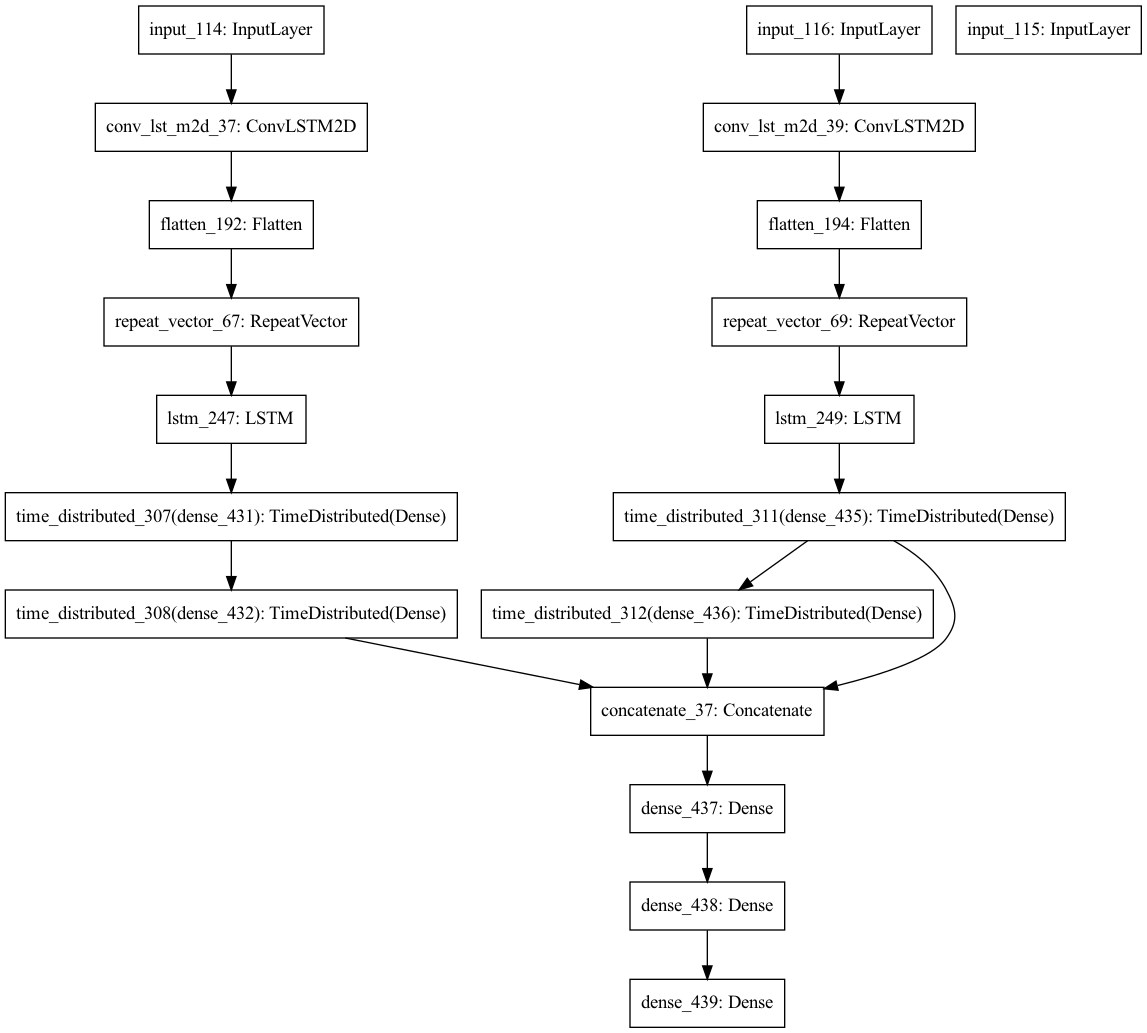

In [647]:
from tensorflow.keras.utils import plot_model
plot_model(model_multi_conv_lstm, to_file='model.png')

In [252]:
    inputs1 = Input(shape=(X1_train.shape[1], X1_train.shape[2]))
    dense1 = Dense(50, activation='relu')(inputs1)
    
    inputs2 = Input(shape=(X1_train.shape[1], X1_train.shape[2]))
    dense2 = Dense(50, activation='relu')(inputs2)
    
    merged = concatenate([dense1, dense2])
    dense3 = Dense(50, activation='relu')(merged)
    outputs = Dense(7)(dense3)


    
    example_Model = Model(inputs=[inputs1,inputs2], outputs=outputs)
    # save a plot of the model
    example_Model.compile(optimizer="adam", loss="mse") # fit network


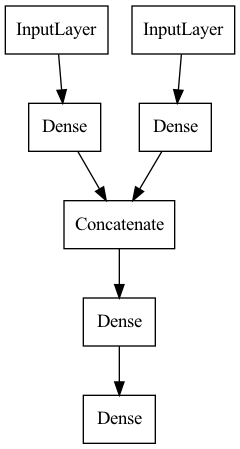

In [257]:
plot_model(example_Model, show_shapes=False,show_layer_names=False,to_file='example_model.png')

In [643]:
tf.keras.utils.plot_model(model_combined_CNN_ConvLSTM)

('You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) ', 'for plot_model/model_to_dot to work.')


In [625]:
!pip install pydot

In [629]:
tf.keras.utils.model_to_dot(model_combined_CNN_ConvLSTM)

('You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) ', 'for plot_model/model_to_dot to work.')


In [630]:
!pip install graphviz

In [543]:
model_combined_CNN_ConvLSTM_history,model_combined_CNN_ConvLSTM,x_tests_re = fit_model_combined_CNN_ConvLSTM(
                                                 optimizer = "adam",loss = "mae",
                                                 X1_train =X1_train,X2_train =X2_train,X4_train =X4_train,
                                                 X3_train =X3_train,X5_train =X5_train,y_test = y_test, y_train = y_train,
                                                 X1_test = X1_test,X2_test = X2_test,X3_test =X3_test,
                                                 X4_test = X4_test,X5_test = X5_test,X6_train= X6_train,X6_test = X6_test,
                                                 epochs = 100,verbose = 1,batch_size = 64)
print("model_combined_CNN_ConvLSTM")
model_prediction(f"model_combined_CNN_ConvLSTM", model_combined_CNN_ConvLSTM,x_tests_re,y_test)

Epoch 1/100
24/24 [==============================] - 12s 73ms/step - loss: 37555.8398 - val_loss: 21573.0391
Epoch 2/100
24/24 [==============================] - 1s 28ms/step - loss: 13063.1523 - val_loss: 11820.5420
Epoch 3/100
24/24 [==============================] - 1s 28ms/step - loss: 9267.9521 - val_loss: 11284.2275
Epoch 4/100
24/24 [==============================] - 1s 30ms/step - loss: 8617.1777 - val_loss: 11055.2969
Epoch 5/100
24/24 [==============================] - 1s 29ms/step - loss: 8177.6187 - val_loss: 10499.2207
Epoch 6/100
24/24 [==============================] - 1s 29ms/step - loss: 7875.1870 - val_loss: 9780.3076
Epoch 7/100
24/24 [==============================] - 1s 27ms/step - loss: 7545.9355 - val_loss: 9026.0830
Epoch 8/100
24/24 [==============================] - 1s 29ms/step - loss: 7336.1011 - val_loss: 8457.4189
Epoch 9/100
24/24 [==============================] - 1s 29ms/step - loss: 7129.7041 - val_loss: 8225.1348
Epoch 10/100
24/24 [==================

('model_combined_CNN_ConvLSTM',
 8098.0,
 5770.0,
 0.11,
 array([[61352.797, 76398.37 , 56797.91 , ..., 41305.566, 55167.03 ,
         67305.234],
        [77185.9  , 56953.4  , 34375.617, ..., 54098.47 , 64693.895,
         63878.75 ],
        [58450.832, 36411.824, 48170.902, ..., 63637.727, 60788.43 ,
         77387.08 ],
        ...,
        [57010.125, 68283.46 , 68781.45 , ..., 53377.01 , 32935.953,
         42228.156],
        [63324.336, 65085.625, 82157.24 , ..., 29542.307, 40110.9  ,
         53509.094],
        [61683.58 , 80371.77 , 59257.184, ..., 40912.324, 55580.484,
         69982.49 ]], dtype=float32))

In [ ]:
results = []

In [1496]:
ergebnissse = np.array(results)
data = {'Name':ergebnissse[:,0],
        'mse':ergebnissse[:,1],
        'mae':ergebnissse[:,2],
        'mape':ergebnissse[:,3]}
  
# Create DataFrame
df = pd.DataFrame(data)
#df.to_csv('01_Results/Architektur_evaluation.csv', index=True, header=True,sep = ";")
predicitions = ergebnissse[:,4]

<ipython-input-1496-832224d5ba3e>:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  ergebnissse = np.array(results)


Text(0.5, 1.0, 'model_combined_CNN_ConvLSTM')

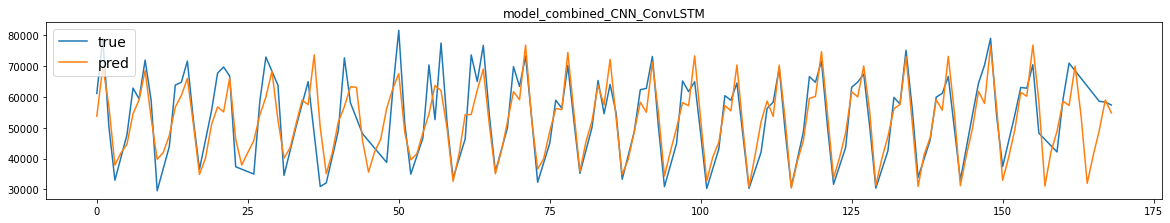

In [1497]:
number_plots = 13
number_checked_labels = 190

fig = plt.figure(figsize=(20,50))
x = len(y_test)
y = predicitions[0][0:number_checked_labels,0]

plt.subplot(number_plots, 1, 1)
plt.plot(y_test[0:number_checked_labels,0])
plt.plot(predicitions[0][0:number_checked_labels,0])
plt.legend(['true', 'pred'], loc='upper left',fontsize=14)
plt.title(f'{results[0][0]}')

# Fit Models

In [64]:
training = X4_train
test = X4_test

In [73]:
y_test.shape

(336, 7)

In [61]:
training = X0_train
test = X0_test
results = []

model_history_cnn,model_cnn, x_tests = fit_model_cnn(filters = 32,kernel_size = 3,pool_size = 3,
                                             epochs = 50, batch_size = 64,training = training, 
                                             y_train = y_train, test = test, y_test = y_test,
                                            verbose = 1,loss= "mse",optimizer= "adam")
print("model_cnn")
results.append(model_prediction(f"model_cnn", model_cnn,test,y_test))





# model_lstm1_history, model_lstm1 = fit_model_lstm1(lstm_units = 30 ,optimizer = "adam",loss = "mse",
#                                                     training = training,y_train = y_train ,test = test,
#                                                     y_test = y_test,epochs = 10,batch_size = 32,verbose = 1)
# print("model_lstm1")
# results.append(model_prediction(f"model_lstm1", model_lstm1,test,y_test))






# model_lstm2_history, model_lstm2 = fit_model_lstm2(lstm_units = 20 ,optimizer = "adam",loss = "mse",
#                                                     training = training,y_train = y_train ,test = test,
#                                                     y_test = y_test,epochs = 1,batch_size = 32,verbose = 1)
# print("model_lstm2")
# results.append(model_prediction(f"model_lstm2", model_lstm2,test,y_test))





# model_lstm_bidirectional_history, model_lstm_bidirectional = fit_model_lstm_bidirectional(lstm_units = 20,optimizer = "adam",loss = "mse",
#                                                         training = training,y_train = y_train,test = test,
#                                                         y_test = y_test,epochs = 4,batch_size = 32,verbose = 1)
# print("model_lstm_bidirectional")
# results.append(model_prediction(f"model_lstm_bidirectional", model_lstm_bidirectional,test,y_test))



model_cnn_lstm_history, model_cnn_lstm,test_series_sub = fit_model_lstm_cnn(
                                    filters = 32,kernel_size = 3,pool_size = 3,lstm_units = 30,optimizer = "adam",
                                    loss = "mse",training = training,y_train = y_train,test =test,
                                    y_test =y_test,epochs = 50,batch_size = 32,verbose = 1)
print("model_cnn_lstm")
results.append(model_prediction(f"model_cnn_lstm", model_cnn_lstm,test_series_sub,y_test))




model_E_D_lstm_cnn_history, model_E_D_lstm_cnn = fit_model_E_D_lstm_cnn(
                                        filters = 32, kernel_size = 4,pool_size = 4,
                                        lstm_units = 30,loss = "mse",optimizer = "adam",
                                        training = training,y_train = y_train,y_test = y_test,
                                        test = test,epochs = 50,verbose = 1,batch_size = 32)
print("model_E_D_lstm_cnn")
results.append(model_prediction(f"model_E_D_lstm_cnn", model_E_D_lstm_cnn,test,y_test))





model_E_D_lstm_history, model_E_D_lstm =  fit_model_E_D_lstm(lstm_units =30,loss = "mse",optimizer = "adam",
                                          training = training,test = test,epochs = 50,verbose = 1,
                                          y_train = y_train,y_test= y_test, batch_size = 32)
print("model_E_D_lstm")
results.append(model_prediction(f"model_E_D_lstm", model_E_D_lstm,test,y_test))




# model_ConvLSTM_D_E_history,model_ConvLSTM_D_E,test_re = fit_model_ConvLSTM(filters =32 ,lstm_units = 30,loss = "mse",
#                                                              optimizer = "adam",training = training,
#                                                              y_train = y_train,y_test = y_test,test = test,
#                                                              epochs =50,verbose =1,batch_size =32)
# print("model_ConvLSTM_D_E")
# results.append(model_prediction(f"model_ConvLSTM_D_E", model_ConvLSTM_D_E,test_re,y_test))


    


Epoch 1/50
18/18 [==============================] - 1s 22ms/step - loss: 606437376.0000 - val_loss: 253666528.0000
Epoch 2/50
18/18 [==============================] - 0s 16ms/step - loss: 170805680.0000 - val_loss: 188374944.0000
Epoch 3/50
18/18 [==============================] - 0s 16ms/step - loss: 143404576.0000 - val_loss: 177747456.0000
Epoch 4/50
18/18 [==============================] - 0s 15ms/step - loss: 137527808.0000 - val_loss: 172762736.0000
Epoch 5/50
18/18 [==============================] - 0s 15ms/step - loss: 132874288.0000 - val_loss: 158590896.0000
Epoch 6/50
18/18 [==============================] - 0s 13ms/step - loss: 128644720.0000 - val_loss: 151392976.0000
Epoch 7/50
18/18 [==============================] - 0s 15ms/step - loss: 121603528.0000 - val_loss: 143058768.0000
Epoch 8/50
18/18 [==============================] - 0s 17ms/step - loss: 115750936.0000 - val_loss: 137233792.0000
Epoch 9/50
18/18 [==============================] - 0s 18ms/step - loss: 1110126

Epoch 22/50
35/35 [==============================] - 1s 15ms/step - loss: 3152599040.0000 - val_loss: 3099949824.0000
Epoch 23/50
35/35 [==============================] - 0s 14ms/step - loss: 3152595200.0000 - val_loss: 3099946240.0000
Epoch 24/50
35/35 [==============================] - 0s 14ms/step - loss: 3152591872.0000 - val_loss: 3099942656.0000
Epoch 25/50
35/35 [==============================] - 1s 14ms/step - loss: 3152587520.0000 - val_loss: 3099938560.0000
Epoch 26/50
35/35 [==============================] - 0s 14ms/step - loss: 3152582656.0000 - val_loss: 3099934720.0000
Epoch 27/50
35/35 [==============================] - 1s 15ms/step - loss: 3152579584.0000 - val_loss: 3099930624.0000
Epoch 28/50
35/35 [==============================] - 1s 15ms/step - loss: 3152575488.0000 - val_loss: 3099927296.0000
Epoch 29/50
35/35 [==============================] - 0s 14ms/step - loss: 3152572160.0000 - val_loss: 3099923200.0000
Epoch 30/50
35/35 [==============================] - 0s 

35/35 [==============================] - 2s 53ms/step - loss: 103474536.0000 - val_loss: 148326416.0000
Epoch 43/50
35/35 [==============================] - 2s 49ms/step - loss: 101054104.0000 - val_loss: 152359888.0000
Epoch 44/50
35/35 [==============================] - 2s 49ms/step - loss: 104965584.0000 - val_loss: 147915104.0000
Epoch 45/50
35/35 [==============================] - 2s 49ms/step - loss: 99325888.0000 - val_loss: 150857968.0000
Epoch 46/50
35/35 [==============================] - 2s 50ms/step - loss: 102893288.0000 - val_loss: 143451568.0000
Epoch 47/50
35/35 [==============================] - 2s 49ms/step - loss: 98434400.0000 - val_loss: 148657392.0000
Epoch 48/50
35/35 [==============================] - 2s 51ms/step - loss: 97610928.0000 - val_loss: 150870352.0000
Epoch 49/50
35/35 [==============================] - 2s 50ms/step - loss: 100060808.0000 - val_loss: 144941952.0000
Epoch 50/50
35/35 [==============================] - 2s 49ms/step - loss: 96634640.0000

In [62]:
model_ConvLSTM_D_E_history,model_ConvLSTM_D_E,test_re = fit_model_ConvLSTM(filters =32 ,lstm_units = 30,loss = "mse",
                                                             optimizer = "adam",training = training,
                                                             y_train = y_train,y_test = y_test,test = test,
                                                             epochs =30,verbose =1,batch_size =32)
print("model_ConvLSTM_D_E")
results.append(model_prediction(f"model_ConvLSTM_D_E", model_ConvLSTM_D_E,test_re,y_test))

Epoch 1/30
35/35 [==============================] - 7s 127ms/step - loss: 904350464.0000 - val_loss: 599155392.0000
Epoch 2/30
35/35 [==============================] - 5s 129ms/step - loss: 360276800.0000 - val_loss: 230723136.0000
Epoch 3/30
35/35 [==============================] - 5s 129ms/step - loss: 161858992.0000 - val_loss: 211643392.0000
Epoch 4/30
35/35 [==============================] - 5s 129ms/step - loss: 154615088.0000 - val_loss: 208073280.0000
Epoch 5/30
35/35 [==============================] - 5s 133ms/step - loss: 151598640.0000 - val_loss: 206377024.0000
Epoch 6/30
35/35 [==============================] - 5s 134ms/step - loss: 149566912.0000 - val_loss: 208288816.0000
Epoch 7/30
35/35 [==============================] - 5s 135ms/step - loss: 149166128.0000 - val_loss: 203621552.0000
Epoch 8/30
35/35 [==============================] - 5s 135ms/step - loss: 149536896.0000 - val_loss: 205655728.0000
Epoch 9/30
35/35 [==============================] - 5s 134ms/step - loss

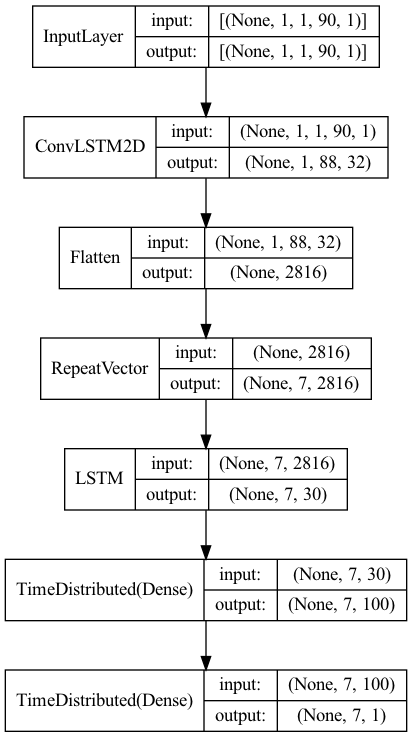

In [94]:
from tensorflow.keras.utils import plot_model
plot_model(model_ConvLSTM_D_E, 
           show_shapes=True,
           show_layer_names=False,
           expand_nested=True,
           to_file='model_ConvLSTM_D_E.png')

In [90]:

model_ConvLSTM_D_E_history,model_ConvLSTM_D_E,test_re = fit_model_ConvLSTM(filters =32 ,lstm_units = 30,loss = "mse",
                                                             optimizer = "adam",training = training,
                                                             y_train = y_train,y_test = y_test,test = test,
                                                             epochs =1,verbose =1,batch_size =32)

48/48 [==============================] - 5s 37ms/step - loss: 850891392.0000 - val_loss: 501851232.0000


In [241]:
results = []


# model_multi_cnn_history, model_multi_cnn = fit_model_CNN_X1_X2(filters1 = 8,filters2 =4,
#                                                    kernel_size1 = 2,kernel_size2 =4,
#                                                    pool_size1 = 1,pool_size2 = 2,
#                                                    optimizer = "adam",loss ="huber",
#                                                    X1_train = X1_train,X2_train = X2_train,X3_train=X3_train,
#                                                    y_train = y_train,y_test = y_test,
#                                                    epochs = 1,verbose = 1,batch_size = 32)
# print("model_multi_cnn")
# # results.append(model_prediction(f"model_multi_cnn", model_multi_cnn,[X1_test,X2_test, X3_test],y_test))



model_cnn_lstm_multi_history, model_cnn_lstm_multi,test_series_sub = fit_model_lstm_cnn_multi(
                                    filters = 128,kernel_size = 2,pool_size = 1,optimizer = "adam",
                                    loss = "mae",training1 = X1_train,training2 = X2_train,training3 = X3_train,y_train = y_train,test1 =X1_test,
                                    test2 =X2_test,test3 =X3_test,y_test =y_test,epochs = 60,batch_size = 256,verbose = 1,dense1 =300, dense2= 150, lstm_units=400)
print("model_multi_cnn_lstm")
results.append(model_prediction(f"model_cnn_lstm", model_cnn_lstm_multi,test_series_sub,y_test))





# model_multi_conv_lstm_history, model_multi_conv_lstm, x_test_re = fit_model_multi_convLSTM_X1_X2(
#                                                optimzer = "adam",loss = "huber",X1_train = X1_train,X2_train = X2_train,X3_train =X3_train,
#                                                y_train = y_train,y_test = y_test,epochs = 1,
#                                                verbose = 1,batch_size =32)
# print("model_multi_conv_lstm")
# #results.append(model_prediction(f"model_multi_conv_lstm", model_multi_conv_lstm,x_test_re,y_test))








Epoch 1/60
5/5 [==============================] - 7s 639ms/step - loss: 26884.2148 - val_loss: 11446.5967
Epoch 2/60
5/5 [==============================] - 3s 543ms/step - loss: 9884.9912 - val_loss: 9926.2969
Epoch 3/60
5/5 [==============================] - 3s 583ms/step - loss: 9188.6035 - val_loss: 10129.2471
Epoch 4/60
5/5 [==============================] - 3s 589ms/step - loss: 9287.9600 - val_loss: 10301.3623
Epoch 5/60
5/5 [==============================] - 3s 638ms/step - loss: 9159.4326 - val_loss: 9735.2939
Epoch 6/60
5/5 [==============================] - 3s 649ms/step - loss: 9013.5879 - val_loss: 9121.3447
Epoch 7/60
5/5 [==============================] - 3s 649ms/step - loss: 8841.1787 - val_loss: 9119.9053
Epoch 8/60
5/5 [==============================] - 3s 663ms/step - loss: 8765.4463 - val_loss: 9193.7275
Epoch 9/60
5/5 [==============================] - 4s 748ms/step - loss: 8653.1436 - val_loss: 8892.8096
Epoch 10/60
5/5 [==============================] - 3s 699ms/

In [242]:
model_prediction(f"model_cnn_lstm", model,test_series_sub,y_test)

('model_cnn_lstm',
 9306.0,
 7066.0,
 0.12,
 array([[48935.715, 50539.85 , 51078.074, 55101.883, 66336.54 , 49561.508,
         36618.38 ],
        [52019.953, 52318.4  , 55730.574, 66166.77 , 49394.52 , 32093.836,
         38942.9  ],
        [52775.082, 57814.516, 68179.61 , 51124.61 , 30630.766, 39320.246,
         46785.383],
        [59432.54 , 67813.25 , 50412.387, 31643.852, 38384.31 , 46678.71 ,
         54878.836],
        [68911.15 , 51974.504, 29532.133, 36590.043, 46181.96 , 53057.38 ,
         54767.316],
        [53148.676, 30123.176, 39886.438, 44742.88 , 51737.273, 54766.58 ,
         65070.81 ],
        [30890.895, 38780.234, 48370.8  , 53001.03 , 53463.094, 66539.93 ,
         47197.594],
        [40726.934, 45081.88 , 52714.32 , 51274.02 , 62935.656, 50403.562,
         32971.17 ],
        [46993.87 , 51684.83 , 48927.605, 64386.8  , 47542.195, 29083.066,
         35892.832],
        [52399.56 , 49677.613, 62756.25 , 45859.266, 28739.79 , 38236.99 ,
         47886.03

In [120]:
model_multi_conv_lstm_history, model_multi_conv_lstm, x_test_re = fit_model_multi_convLSTM_X1_X2(
                                               optimzer = "adam",loss = "huber",X1_train = X1_train,X2_train = X2_train,X3_train =X3_train,
                                               y_train = y_train,y_test = y_test,epochs = 1,
                                               verbose = 1,batch_size =32)
print("model_multi_conv_lstm")
#results.append(model_prediction(f"model_multi_conv_lstm", model_multi_conv_lstm,x_test_re,y_test))



48/48 [==============================] - 14s 111ms/step - loss: 33782.7109 - val_loss: 16306.1729
model_multi_conv_lstm


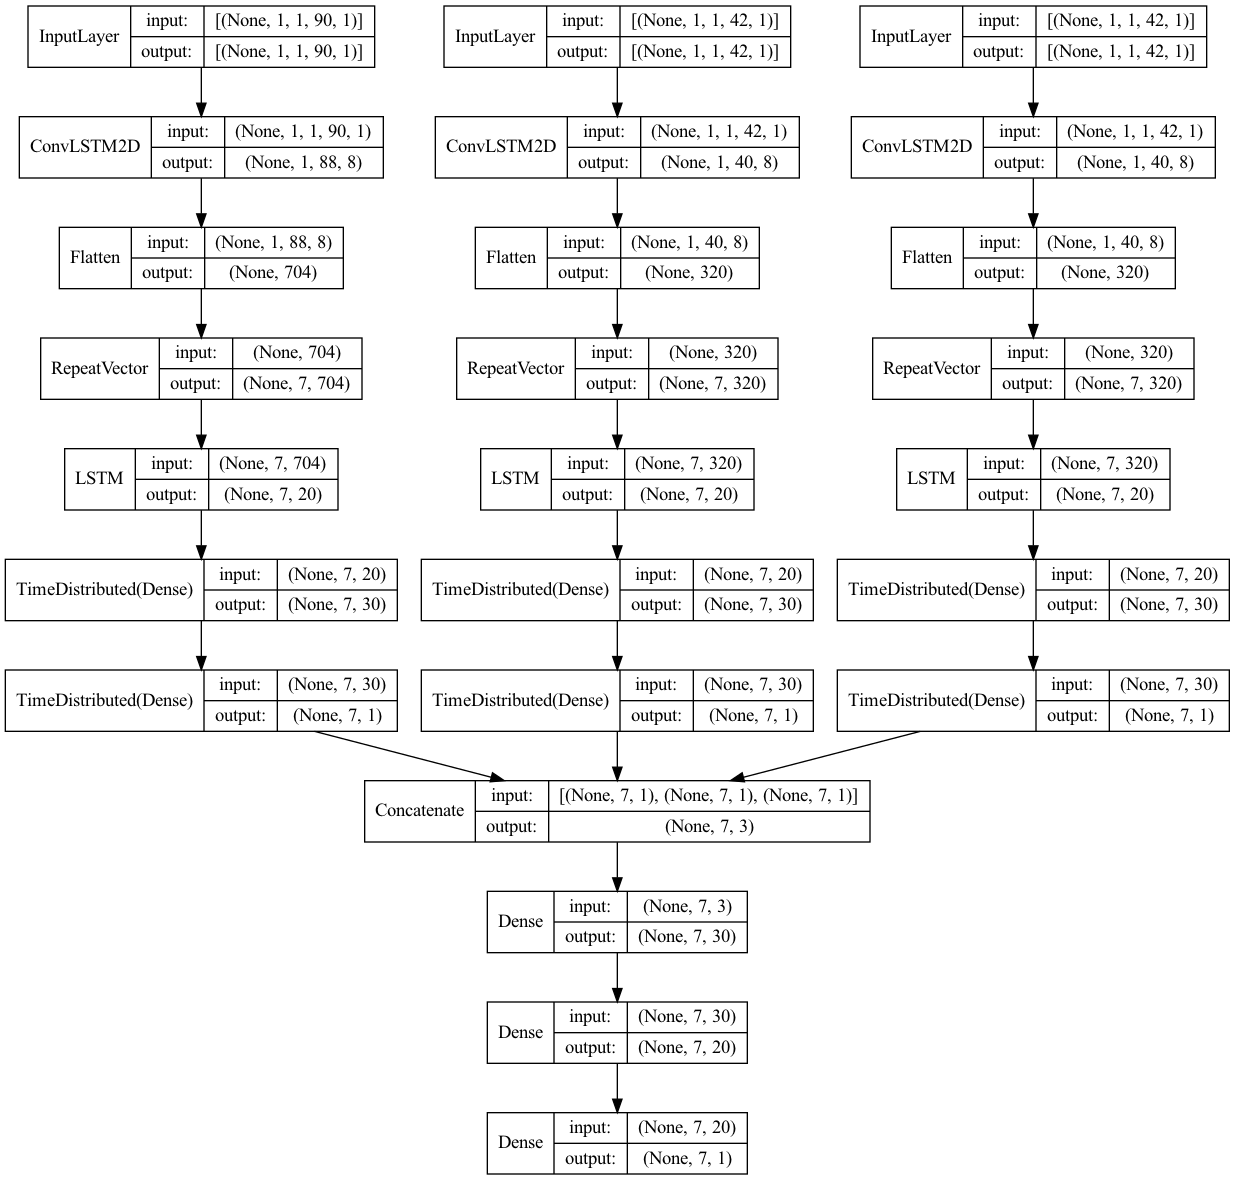

In [157]:
plot_model(model_multi_conv_lstm, 
           show_shapes=True,
           show_layer_names=False,
           expand_nested=True,
           to_file='model_multi_conv_lstm.png')

# TEST

In [151]:
results = []

model_multi_cnn2_history,model_multi_cnn2 = fit_model_multi_CNN_X1_X2_X3_X4_X5(
                                                    filters1 = 8,filters2 = 16,
                                                    kernel_size1 = 4,kernel_size2 = 1,
                                                    pool_size1 = 1,pool_size2 =1,
                                                    optimizer = "adam",loss = "mae",
                                                    X1_train = X1_train,X2_train = X2_train,X3_train = X3_train,
                                                    X4_train = X4_train,X5_train = X5_train,X6_train= X6_train,
                                                    X1_test = X1_test,X2_test = X2_test,X3_test = X3_test,
                                                    X4_test = X4_test,X5_test = X5_test,X6_test = X6_test,
                                                    epochs = 1, verbose = 1,batch_size = 32)
print("model_multi_cnn2")
#results.append(model_prediction(f"model_multi_cnn2", model_multi_cnn2,[X1_test,X2_test,X4_test,X5_test,X6_test,X3_test],y_test))



model_combined_ConvLSTM_history, model_combined_ConvLSTM,x_test_re = fit_model_combined_ConvLSTM(
                                                            optimizer = "adam",loss = "mae",
                                                            X1_train = X1_train,X2_train = X2_train,X4_train = X4_train,
                                                            X3_train = X3_train,y_train = y_train,y_test = y_test,
                                                            X1_test = X1_test,X2_test = X2_test,X3_test = X3_test,X5_train = X5_train,
                                                            X4_test = X4_test,X5_test = X5_test,X6_train= X6_train,X6_test = X6_test,
                                                            epochs = 1,verbose =1,batch_size = 32)
print("model_combined_ConvLSTM")
#results.append(model_prediction(f"model_combined_ConvLSTM", model_combined_ConvLSTM,x_test_re,y_test))

model_combined_CNN_ConvLSTM_history,model_combined_CNN_ConvLSTM,x_tests_re = fit_model_combined_CNN_ConvLSTM(
                                                 optimizer = "adam",loss = "mae",
                                                 X1_train =X1_train,X2_train =X2_train,X4_train =X4_train,
                                                 X3_train =X3_train,X5_train =X5_train,y_test = y_test, y_train = y_train,
                                                 X1_test = X1_test,X2_test = X2_test,X3_test =X3_test,
                                                 X4_test = X4_test,X5_test = X5_test,X6_train= X6_train,X6_test = X6_test,
                                                 epochs = 1,verbose = 1,batch_size = 64)
print("model_combined_CNN_ConvLSTM")
#results.append(model_prediction(f"model_combined_CNN_ConvLSTM", model_combined_CNN_ConvLSTM,x_tests_re,y_test))



48/48 [==============================] - 1s 9ms/step - loss: 16847.2559 - val_loss: 11227.9922
model_multi_cnn2
48/48 [==============================] - 37s 446ms/step - loss: 18274.8203 - val_loss: 11712.6484
model_combined_ConvLSTM
24/24 [==============================] - 9s 61ms/step - loss: 35030.7461 - val_loss: 14985.9131
model_combined_CNN_ConvLSTM


In [161]:
model_combined_CNN_ConvLSTM_history,model_combined_CNN_ConvLSTM,x_tests_re = fit_model_combined_CNN_ConvLSTM(
                                                 optimizer = "adam",loss = "mae",
                                                 X1_train =X1_train,X2_train =X2_train,X4_train =X4_train,
                                                 X3_train =X3_train,X5_train =X5_train,y_test = y_test, y_train = y_train,
                                                 X1_test = X1_test,X2_test = X2_test,X3_test =X3_test,
                                                 X4_test = X4_test,X5_test = X5_test,X6_train= X6_train,X6_test = X6_test,
                                                 epochs = 1,verbose = 1,batch_size = 64)
print("model_combined_CNN_ConvLSTM")
#results.append(model_prediction(f"model_combined_CNN_ConvLSTM", model_combined_CNN_ConvLSTM,x_tests_re,y_test))

24/24 [==============================] - 10s 58ms/step - loss: 30250.3008 - val_loss: 13517.6260
model_combined_CNN_ConvLSTM


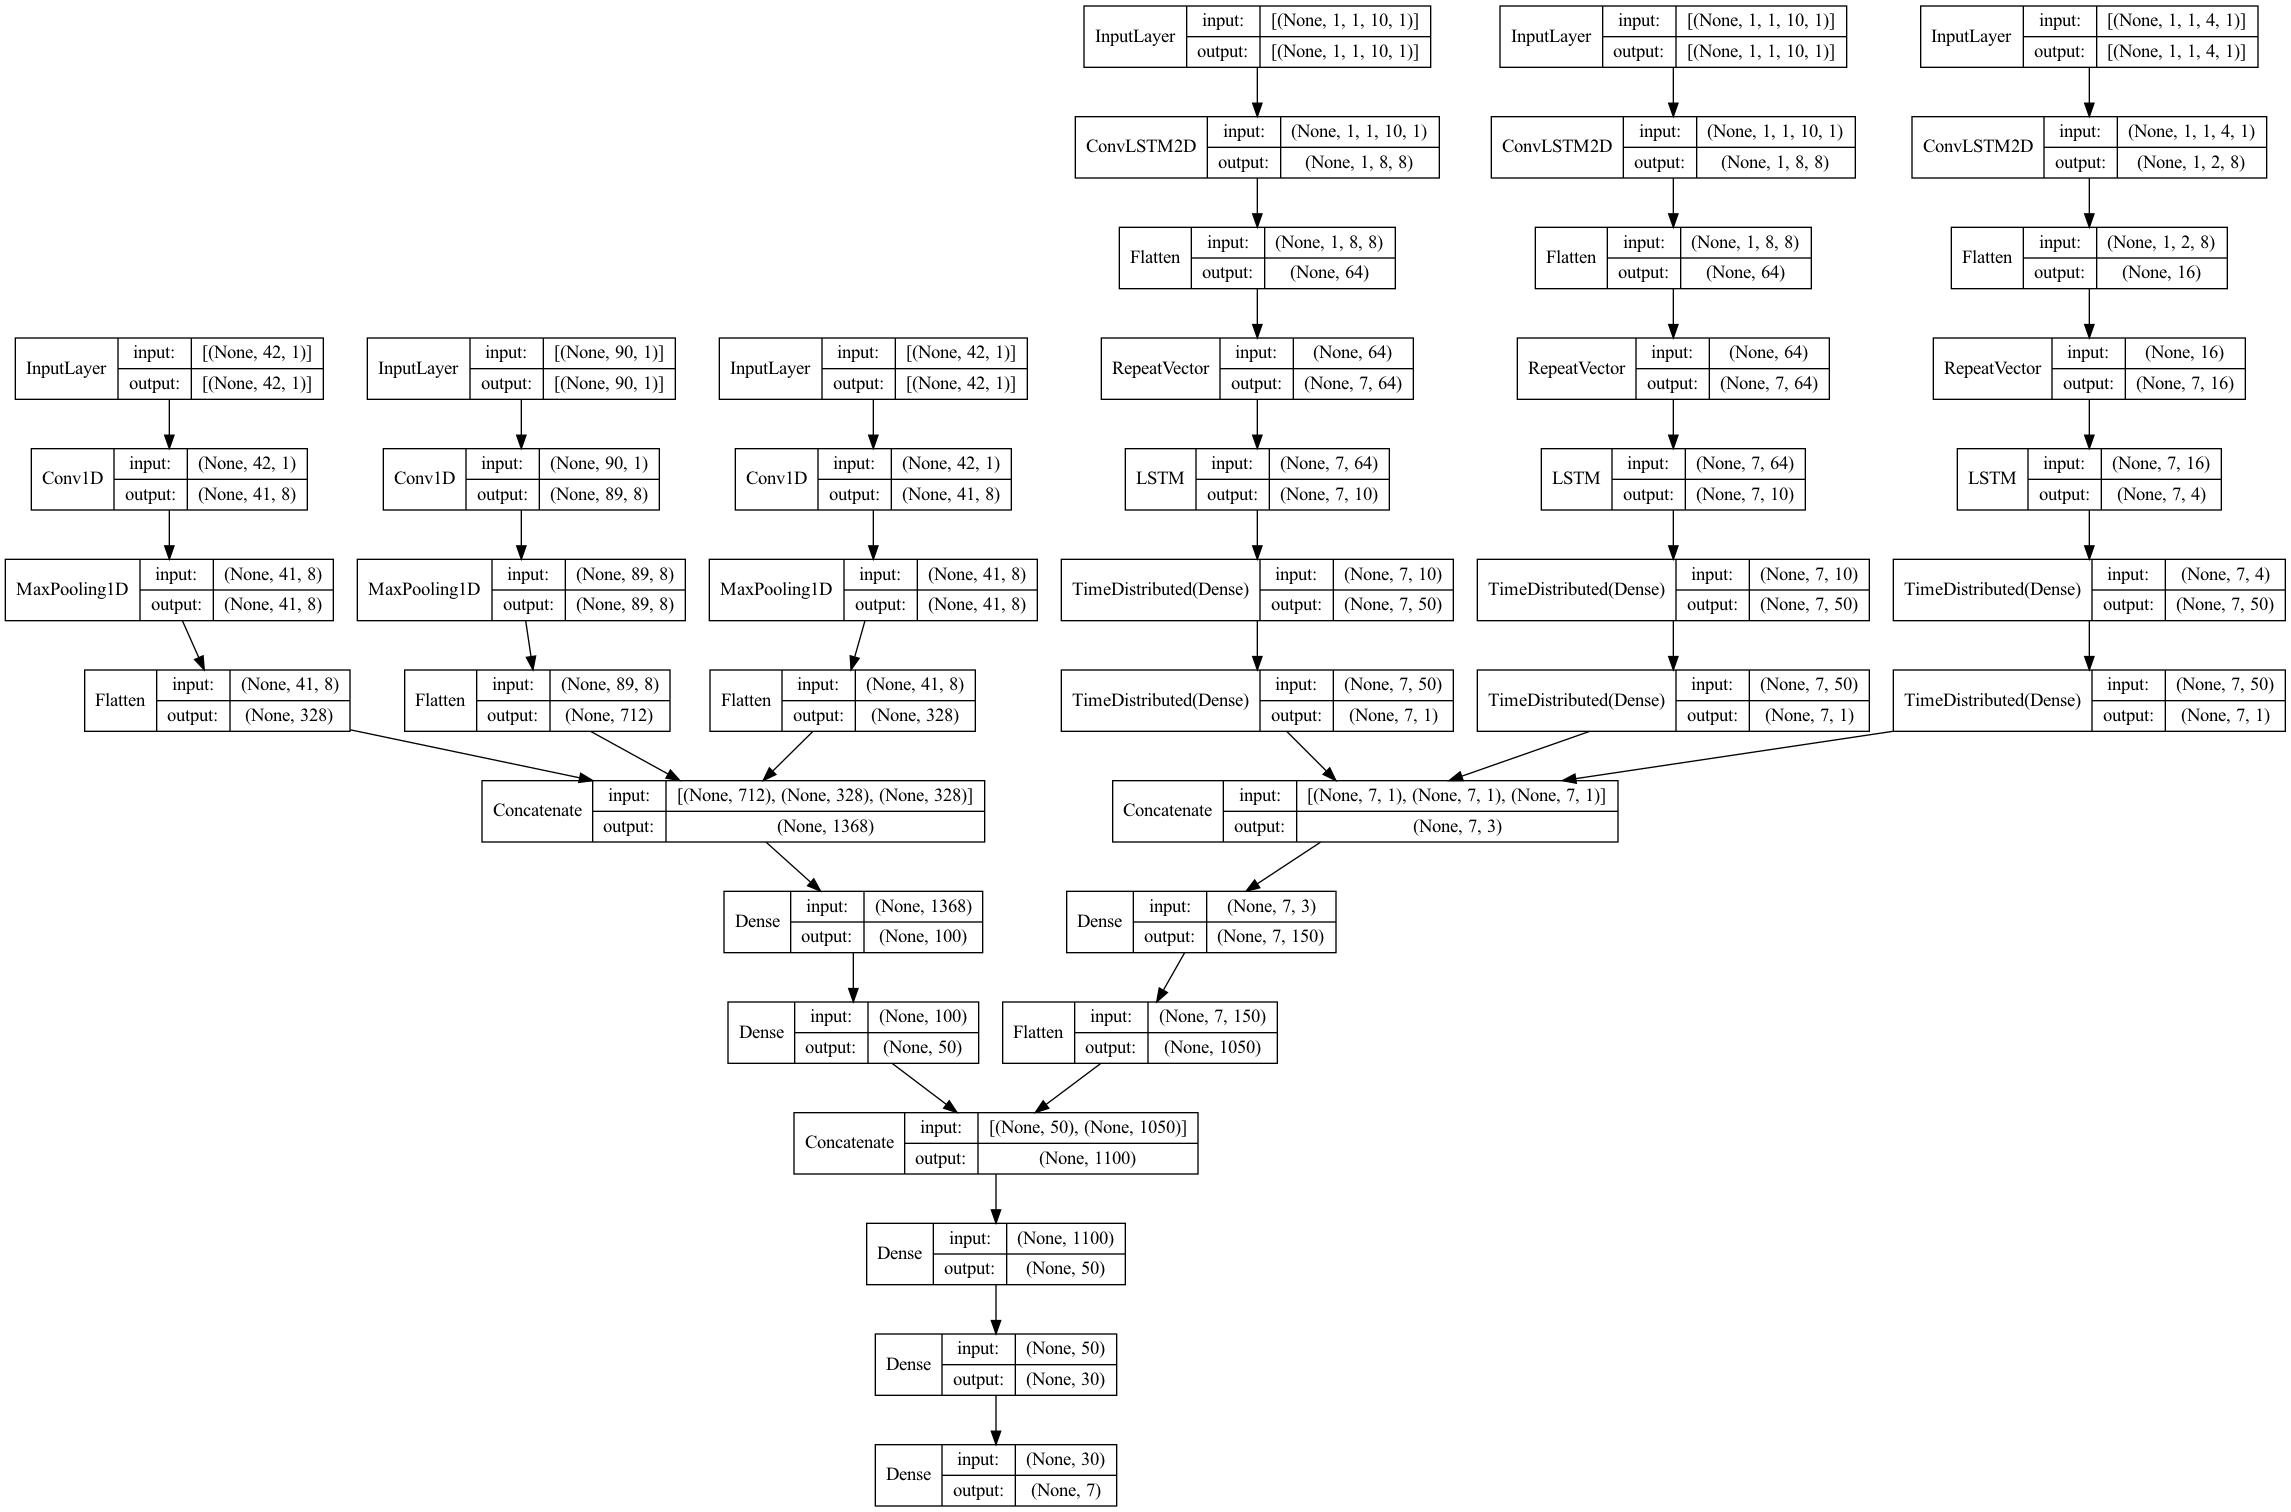

In [162]:
plot_model(model_combined_CNN_ConvLSTM, 
           show_shapes=True,
           show_layer_names=False,
           expand_nested=True,
           to_file='model_combined_CNN_ConvLSTM.png')

In [171]:
ergebnissse = np.array(results)

<ipython-input-171-f96e9ca1b649>:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  ergebnissse = np.array(results)


In [243]:
ergebnissse = np.array(results)
data = {'Name':ergebnissse[:,0],
        'mse':ergebnissse[:,1],
        'mae':ergebnissse[:,2],
        'mape':ergebnissse[:,3]}
  
# Create DataFrame
df = pd.DataFrame(data)
#df.to_csv('01_Results/Architektur_evaluation.csv', index=True, header=True,sep = ";")
predicitions = ergebnissse[:,4]

<ipython-input-243-832224d5ba3e>:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  ergebnissse = np.array(results)


In [244]:
df

,Name,mse,mae,mape
0,model_cnn_lstm,8701.0,6718.0,0.12


In [245]:
df.to_csv('outTest.csv')

## Auswertung

In [542]:
#model_prediction("CNN1", model_cnn,X1_test,y_test)
#model_prediction("LSTM1", model_lstm1,X1_test,y_test)
#model_prediction("LSTM2", model_lstm2,X1_test,y_test)
#model_prediction("LSTM_Bidirectional", model_lstm_bidirectional,X1_test,y_test)
#model_prediction("CNN_LSTM", model_cnn_lstm,test_series_sub,y_test)
#model_prediction("E_D_LSTM_CNN", model_E_D_lstm_cnn,X1_test,y_test)
#model_prediction("E_D_lstm", model_E_D_lstm,X1_test,y_test)
#model_prediction("ConvLSTM_D_E", model_ConvLSTM_D_E,test_re,y_test)

#model_prediction("multi_cnn", model_multi_cnn,[X1_test,X2_test],y_test)
#model_prediction("multi_cnn2", model_multi_cnn2,[X1_test,X2_test,X3_test,X4_test,X5_test],y_test)

#model_prediction("multi_lstm1", model_multi_lstm,[X1_test,X2_test,X3_test,X4_test,X5_test],y_test)
#model_prediction("multi_lstm2", model_multi_lstm2,[X1_test,X2_test],y_test)
model_prediction("multi_conv_lstm", model_multi_conv_lstm,x_test_re,y_test)
#model_prediction("combined_conv_lstm", model_combined_ConvLSTM,x_test_re,y_test)
#model_prediction("combined_CNN_ConvLSTM", model_combined_CNN_ConvLSTM,x_tests_re,y_test)

('multi_conv_lstm',
 12631.407207749711,
 9442.371182515973,
 0.2850801447624121,
 array([[76508.21 , 53541.047, 32683.846, ..., 53624.016, 60179.387,
         64037.54 ],
        [57671.992, 28438.607, 43838.41 , ..., 47041.223, 70006.31 ,
         80852.01 ],
        [25019.28 , 37197.18 , 43527.24 , ..., 67021.5  , 84764.56 ,
         58101.16 ],
        ...,
        [56011.992, 53368.824, 42188.406, ..., 24906.219, 39064.156,
         48615.73 ],
        [46543.52 , 37769.418, 33615.402, ..., 65556.94 , 70877.06 ,
         67748.055],
        [79849.28 , 54582.266, 28298.955, ..., 53572.145, 66065.43 ,
         73041.24 ]], dtype=float32))

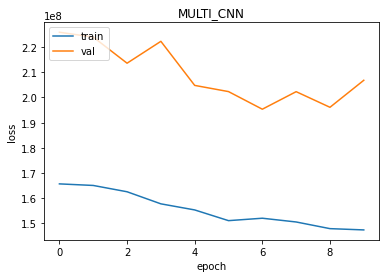

In [291]:
#plot_losses(model_history_cnn,"CNN!")
#plot_losses(model_lstm1_history,"LSTM1")#geht nicht wegen epochen < 10 
#plot_losses(model_lstm2_history,"LSTM2")
#plot_losses(model_lstm_bidirectional_history,"LSTM_Bidirectional")
#plot_losses(model_cnn_lstm_history,"CNN_LSTM")
#plot_losses(model_E_D_lstm_cnn_history,"CNN_LSTM")
#plot_losses(model_E_D_lstm_history,"CNN_LSTM")
#plot_losses(model_ConvLSTM_D_E_history,"CNN_LSTM")

#plot_losses(model_multi_cnn_history,"MULTI_CNN")
#plot_losses(model_multi_cnn2_history,"MULTI_CNN2")
#plot_losses(model_multi_lstm_history,"MULTI_LSTM")
#plot_losses(model_multi_lstm_history2,"MULTI_LSTM2)
#plot_losses(model_multi_conv_lstm_history,"MULTI_CONV_LSTM")
#plot_losses(model_combined_ConvLSTM_history,"MULTI_COMBINED_CONVLSTM")
#plot_losses(model_combined_CNN_ConvLSTM_history,"MULTI_COMBINED_CNN_CINVLSTM")


In [246]:
predicitions = ergebnissse[:,4]

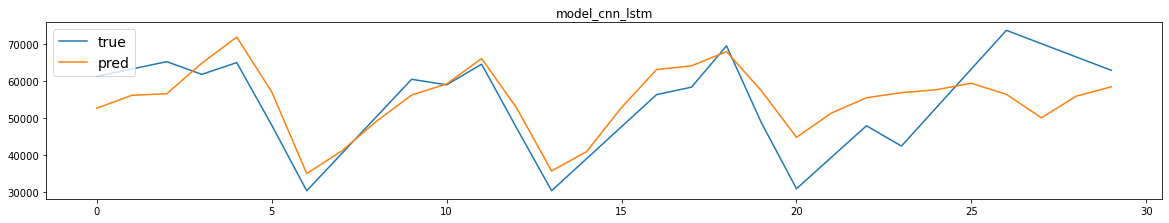

In [249]:
number_plots = 13
number_checked_labels = 30

fig = plt.figure(figsize=(20,50))
x = len(y_test)
y = predicitions[0][0:number_checked_labels,0]

plt.subplot(number_plots, 1, 1)
plt.plot(y_test[0:number_checked_labels,0])
plt.plot(predicitions[0][0:number_checked_labels,0])
plt.legend(['true', 'pred'], loc='upper left',fontsize=14)
plt.title(f'{results[0][0]}')

# plt.subplot(number_plots, 1, 2)
# plt.plot(y_test[0:number_checked_labels,0])
# plt.plot(predicitions[1][0:number_checked_labels,0])
# plt.title(f'{results[1][0]}')

# plt.subplot(number_plots, 1, 3)
# plt.plot(y_test[0:number_checked_labels,0])
# plt.plot(predicitions[2][0:number_checked_labels,0])
# plt.title(f'{results[2][0]}')

# plt.subplot(number_plots, 1, 4)
# plt.plot(y_test[0:number_checked_labels,0])
# plt.plot(predicitions[3][0:number_checked_labels,0])
# plt.title(f'{results[3][0]}')

# plt.subplot(number_plots, 1, 5)
# plt.plot(y_test[0:number_checked_labels,0])
# plt.plot(predicitions[4][0:number_checked_labels,0])
# plt.title(f'{results[4][0]}')

# plt.subplot(number_plots, 1, 6)
# plt.plot(y_test[0:number_checked_labels,0])
# plt.plot(predicitions[5][0:number_checked_labels,0])
# plt.title(f'{results[5][0]}')

# plt.subplot(number_plots, 1, 7)
# plt.plot(y_test[0:number_checked_labels,0])
# plt.plot(predicitions[6][0:number_checked_labels,0])
# plt.title(f'{results[6][0]}')

# plt.subplot(number_plots, 1, 8)
# plt.plot(y_test[0:number_checked_labels,0])
# plt.plot(predicitions[7][0:number_checked_labels,0])
# plt.title(f'{results[7][0]}')

plt.savefig("poltet_good_architketurs_30", dpi=300, bbox_inches='tight', pad_inches=0)
plt.show()

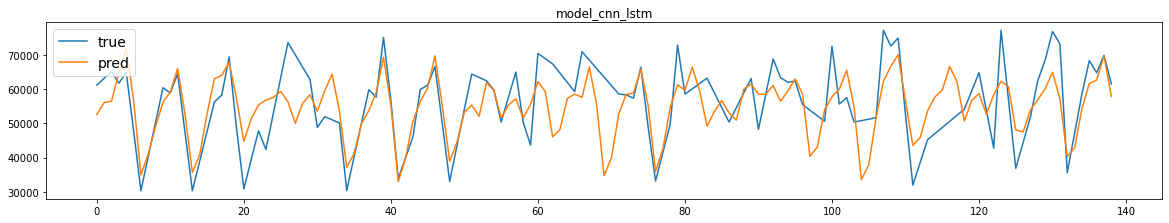

In [248]:
number_plots = 13
number_checked_labels = 190

fig = plt.figure(figsize=(20,50))
x = len(y_test)
y = predicitions[0][0:number_checked_labels,0]

plt.subplot(number_plots, 1, 1)
plt.plot(y_test[0:number_checked_labels,0])
plt.plot(predicitions[0][0:number_checked_labels,0])
plt.legend(['true', 'pred'], loc='upper left',fontsize=14)
plt.title(f'{results[0][0]}')

# plt.subplot(number_plots, 1, 2)
# plt.plot(y_test[0:number_checked_labels,0])
# plt.plot(predicitions[1][0:number_checked_labels,0])
# plt.title(f'{results[1][0]}')

# plt.subplot(number_plots, 1, 3)
# plt.plot(y_test[0:number_checked_labels,0])
# plt.plot(predicitions[2][0:number_checked_labels,0])
# plt.title(f'{results[2][0]}')

# plt.subplot(number_plots, 1, 4)
# plt.plot(y_test[0:number_checked_labels,0])
# plt.plot(predicitions[3][0:number_checked_labels,0])
# plt.title(f'{results[3][0]}')

# plt.subplot(number_plots, 1, 5)
# plt.plot(y_test[0:number_checked_labels,0])
# plt.plot(predicitions[4][0:number_checked_labels,0])
# plt.title(f'{results[4][0]}')

# plt.subplot(number_plots, 1, 6)
# plt.plot(y_test[0:number_checked_labels,0])
# plt.plot(predicitions[5][0:number_checked_labels,0])
# plt.title(f'{results[5][0]}')

# plt.subplot(number_plots, 1, 7)
# plt.plot(y_test[0:number_checked_labels,0])
# plt.plot(predicitions[6][0:number_checked_labels,0])
# plt.title(f'{results[6][0]}')

# plt.subplot(number_plots, 1, 8)
# plt.plot(y_test[0:number_checked_labels,0])
# plt.plot(predicitions[7][0:number_checked_labels,0])
# plt.title(f'{results[7][0]}')

plt.savefig("poltet_good_architketurs_190", dpi=300, bbox_inches='tight', pad_inches=0)
plt.show()

## Randomsearch

In [558]:
param_grid = {"epochs": [50,60,70,80,90,100], "batch_size": [32,64,128],
              "filters": [4,8,32,16], "kernel_size": [1,2,3,4,5],
              "pool_size" : [1,2,3,4,5,6],"loss" : ["mse","huber","mae"]}
result = []
keysList = list(param_grid.keys())
for counter in range(0,50):
    rnd = dict()
    parameters = dict()
    for i in keysList: 
        value = random.randint(0,len(param_grid[i])-1)
        rnd[i] = value
        parameters[i] = param_grid[i][value]



    model_history_cnn,model_cnn, x_tests = fit_model_cnn(filters = param_grid["filters"][rnd["filters"]],
                                                         kernel_size = param_grid["kernel_size"][rnd["kernel_size"]],
                                                         pool_size = param_grid["pool_size"][rnd["pool_size"]],
                                                         epochs = param_grid["epochs"][rnd["epochs"]], 
                                                         batch_size = param_grid["batch_size"][rnd["batch_size"]],
                                                         loss = param_grid["loss"][rnd["loss"]],
                                                         optimizer = "adam",
                                                         training = X1_train, 
                                                         y_train = y_train, 
                                                         test = X1_test, 
                                                         y_test = y_test,
                                                         verbose = 0)
    pred = model_prediction("CNN1", model_cnn,x_tests,y_test)
    results_one_model = dict()
    #name,mse,mae,mape, predictions_cnn
    results_one_model["Name"] = pred[0]
    results_one_model["mse"] = pred[1]
    results_one_model["mae"] = pred[2]
    results_one_model["mape"] = pred[3]
    results_one_model["parameters"] = parameters
    result.append(results_one_model)
    print(counter)


#pred = model_prediction("CNN1", model_cnn,x_tests,y_test)
    
#param_grid["epochs"][rnd["epochs"]]
    

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49


In [ ]:
# model_cnn_lstm_multi_history, model_cnn_lstm_multi,test_series_sub = fit_model_lstm_cnn_multi(
#                                     filters = 8,kernel_size = 2,pool_size = 1,lstm_units = 20,optimizer = "adam",
#                                     loss = "huber",training1 = X1_train,training2 = X2_train,training3 = X3_train,y_train = y_train,test1 =X1_test,
#                                     test2 =X2_test,test3 =X3_test,y_test =y_test,epochs = 60,batch_size = 32,verbose = 1)
# print("model_multi_cnn_lstm")
# results.append(model_prediction(f"model_cnn_lstm", model_cnn_lstm_multi,test_series_sub,y_test))

In [594]:
param_grid = {"epochs": [60,70,80,90,100], "batch_size": [256,300,512],
              "filters": [32,16,64,128,256], "kernel_size": [2,3,4],
              "pool_size" : [1,2,],"loss" : ["mse","huber","mae"], "dense1" : [250,270,280,300],
              "dense2" : [50,60,80,70,90,100,150], "lstm_units" : [70,110,150,200,250,300,350,400]}



result = []
keysList = list(param_grid.keys())
for counter in range(0,60):
    rnd = dict()
    parameters = dict()
    for i in keysList: 
        value = random.randint(0,len(param_grid[i])-1)
        rnd[i] = value
        parameters[i] = param_grid[i][value]
        
        
    model_cnn_lstm_multi_history, model_cnn_lstm_multi,test_series_sub = fit_model_lstm_cnn_multi(
                                                        filters = param_grid["filters"][rnd["filters"]],
                                                         kernel_size = param_grid["kernel_size"][rnd["kernel_size"]],
                                                         pool_size = param_grid["pool_size"][rnd["pool_size"]],
                                                         epochs = param_grid["epochs"][rnd["epochs"]], 
                                                         batch_size = param_grid["batch_size"][rnd["batch_size"]],
                                                         loss = param_grid["loss"][rnd["loss"]],
                                                         dense1 = param_grid["dense1"][rnd["dense1"]], 
                                                         dense2 = param_grid["dense2"][rnd["dense2"]],
                                                         lstm_units = param_grid["lstm_units"][rnd["lstm_units"]],
                                                         optimizer = "adam",
                                                         training1 = X1_train,
                                                         training2 = X2_train,
                                                         training3 = X3_train,
                                                         y_train = y_train,
                                                         test1 =X1_test,
                                                         test2 =X2_test,
                                                         test3 =X3_test,
                                                         y_test =y_test,
                                                         verbose = 0)

    pred = model_prediction(f"model_cnn_lstm", model_cnn_lstm_multi,test_series_sub,y_test)
    results_one_model = dict()
    #name,mse,mae,mape, predictions_cnn
    results_one_model["Name"] = pred[0]
    results_one_model["mse"] = pred[1]
    results_one_model["mae"] = pred[2]
    results_one_model["mape"] = pred[3]
    results_one_model["parameters"] = parameters
    result.append(results_one_model)
    print(counter)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59


In [595]:
result = pd.DataFrame(result)
result.to_csv('opt_Multi_CNNLSTM_329.csv', index=True, header=True,sep = ";")

In [565]:
param_grid = {"epochs": [50,60,70,80,90,100], "batch_size": [32,64,128],
              "filters": [32,16,64,128], "kernel_size": [1,2,3,4,5],
              "pool_size" : [1,2,3,4,5,6],"loss" : ["mse","huber","mae"]}



result = []
keysList = list(param_grid.keys())
for counter in range(0,50):
    rnd = dict()
    parameters = dict()
    for i in keysList: 
        value = random.randint(0,len(param_grid[i])-1)
        rnd[i] = value
        parameters[i] = param_grid[i][value]

    model_multi_cnn_history, model_multi_cnn = fit_model_CNN_X1_X2(filters1 = param_grid["filters"][rnd["filters"]],
                                                         kernel_size1 = param_grid["kernel_size"][rnd["kernel_size"]],
                                                         pool_size1 = param_grid["pool_size"][rnd["pool_size"]],
                                                         filters2 = param_grid["filters"][rnd["filters"]],
                                                         kernel_size2 = param_grid["kernel_size"][rnd["kernel_size"]],
                                                         pool_size2 = param_grid["pool_size"][rnd["pool_size"]],
                                                         epochs = param_grid["epochs"][rnd["epochs"]], 
                                                         batch_size = param_grid["batch_size"][rnd["batch_size"]],
                                                         loss = param_grid["loss"][rnd["loss"]],
                                                         optimizer = "adam",
                                                         X1_train = X1_train,X2_train = X2_train,X3_train=X3_train,
                                                         y_train = y_train,y_test = y_test,
                                                         verbose = 0)

    pred = model_prediction(f"model_multi_cnn", model_multi_cnn,[X1_test,X2_test, X3_test],y_test)
    results_one_model = dict()
    #name,mse,mae,mape, predictions_cnn
    results_one_model["Name"] = pred[0]
    results_one_model["mse"] = pred[1]
    results_one_model["mae"] = pred[2]
    results_one_model["mape"] = pred[3]
    results_one_model["parameters"] = parameters
    result.append(results_one_model)
    print(counter)



0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49


In [566]:
result = pd.DataFrame(result)
result.to_csv('opt_MULTICNN_3.csv', index=True, header=True,sep = ";")

In [557]:
param_grid = {"epochs": [50,60,70,80,90,100], "batch_size": [16,32,64,128],
              "filters": [4,8,32,16], "kernel_size": [1,2],"pool_size" : [1],"loss" : ["mse","huber","mae"]}
result_mulit_CNN = []
keysList = list(param_grid.keys())
for counter in range(0,50):
    rnd = dict()
    parameters = dict()
    for i in keysList: 
        value = random.randint(0,len(param_grid[i])-1)
        rnd[i] = value
        parameters[i] = param_grid[i][value]



    model_multi_cnn2_history,model_multi_cnn2 = fit_model_multi_CNN_X1_X2_X3_X4_X5(
                                                    filters1 = param_grid["filters"][rnd["filters"]],
                                                    filters2 = param_grid["filters"][rnd["filters"]],
                                                    kernel_size1 = param_grid["kernel_size"][rnd["kernel_size"]],
                                                    kernel_size2 = param_grid["kernel_size"][rnd["kernel_size"]],
                                                    pool_size1 = param_grid["pool_size"][rnd["pool_size"]],
                                                    pool_size2 =param_grid["pool_size"][rnd["pool_size"]],
                                                    optimizer = "adam",
                                                    loss = param_grid["loss"][rnd["loss"]],
                                                    X1_train = X1_train,X2_train = X2_train,X3_train = X3_train,
                                                    X4_train = X4_train,X5_train = X5_train,X6_train= X6_train,X6_test = X6_test,
                                                    X1_test = X1_test,X2_test = X2_test,X3_test = X3_test,
                                                    X4_test = X4_test,X5_test = X5_test,
                                                    epochs = param_grid["epochs"][rnd["epochs"]],
                                                    verbose = 0,
                                                    batch_size = param_grid["batch_size"][rnd["batch_size"]])
    print("model_multi_cnn2")
    pred = model_prediction(f"model_multi_cnn2", model_multi_cnn2,[X1_test,X2_test,X4_test,X5_test,X6_test,X3_test],y_test)
    results_one_model = dict()
    #name,mse,mae,mape, predictions_cnn
    results_one_model["Name"] = pred[0]
    results_one_model["mse"] = pred[1]
    results_one_model["mae"] = pred[2]
    results_one_model["mape"] = pred[3]
    results_one_model["parameters"] = parameters
    result_mulit_CNN.append(results_one_model)


model_multi_cnn2
model_multi_cnn2
model_multi_cnn2
model_multi_cnn2
model_multi_cnn2
model_multi_cnn2
model_multi_cnn2
model_multi_cnn2
model_multi_cnn2
model_multi_cnn2
model_multi_cnn2
model_multi_cnn2
model_multi_cnn2
model_multi_cnn2
model_multi_cnn2
model_multi_cnn2
model_multi_cnn2
model_multi_cnn2
model_multi_cnn2
model_multi_cnn2
model_multi_cnn2
model_multi_cnn2
model_multi_cnn2
model_multi_cnn2
model_multi_cnn2
model_multi_cnn2
model_multi_cnn2
model_multi_cnn2
model_multi_cnn2
model_multi_cnn2
model_multi_cnn2
model_multi_cnn2
model_multi_cnn2
model_multi_cnn2
model_multi_cnn2
model_multi_cnn2
model_multi_cnn2
model_multi_cnn2
model_multi_cnn2
model_multi_cnn2
model_multi_cnn2
model_multi_cnn2
model_multi_cnn2
model_multi_cnn2
model_multi_cnn2
model_multi_cnn2
model_multi_cnn2
model_multi_cnn2
model_multi_cnn2
model_multi_cnn2


In [560]:
result_mulit_CNN = pd.DataFrame(result_mulit_CNN)
result_mulit_CNN.to_csv('result_mulit_CNN_random2.csv', index=True, header=True,sep = ";")

# Optimieren 

In [601]:
n_members = 10
ensemble, x_test, y_test= fit_ensemble(n_members,y_test)


Epoch 1/60
6/6 [==============================] - 8s 768ms/step - loss: 24781.2266 - val_loss: 12771.4854
Epoch 2/60
6/6 [==============================] - 4s 693ms/step - loss: 10061.4434 - val_loss: 11572.2705
Epoch 3/60
6/6 [==============================] - 5s 737ms/step - loss: 9266.5371 - val_loss: 11205.6816
Epoch 4/60
6/6 [==============================] - 4s 747ms/step - loss: 9005.0879 - val_loss: 11006.3125
Epoch 5/60
6/6 [==============================] - 5s 758ms/step - loss: 8802.8516 - val_loss: 10599.1289
Epoch 6/60
6/6 [==============================] - 5s 839ms/step - loss: 8507.5420 - val_loss: 10291.8037
Epoch 7/60
6/6 [==============================] - 5s 755ms/step - loss: 8150.0117 - val_loss: 9757.6279
Epoch 8/60
6/6 [==============================] - 5s 804ms/step - loss: 7714.4170 - val_loss: 9045.9844
Epoch 9/60
6/6 [==============================] - 6s 947ms/step - loss: 7332.2803 - val_loss: 8744.8701
Epoch 10/60
6/6 [==============================] - 5s 85

6/6 [==============================] - 5s 834ms/step - loss: 6112.6680 - val_loss: 5450.0396
Epoch 36/60
6/6 [==============================] - 5s 785ms/step - loss: 6000.8877 - val_loss: 5641.1147
Epoch 37/60
6/6 [==============================] - 5s 809ms/step - loss: 6078.9131 - val_loss: 5252.3901
Epoch 38/60
6/6 [==============================] - 5s 800ms/step - loss: 5877.5928 - val_loss: 5136.2202
Epoch 39/60
6/6 [==============================] - 5s 793ms/step - loss: 5860.0063 - val_loss: 5364.6587
Epoch 40/60
6/6 [==============================] - 5s 802ms/step - loss: 5774.4434 - val_loss: 5300.2075
Epoch 41/60
6/6 [==============================] - 5s 792ms/step - loss: 5855.6758 - val_loss: 5275.9722
Epoch 42/60
6/6 [==============================] - 5s 781ms/step - loss: 5921.1680 - val_loss: 5359.9570
Epoch 43/60
6/6 [==============================] - 5s 776ms/step - loss: 6011.7271 - val_loss: 5236.0771
Epoch 44/60
6/6 [==============================] - 5s 777ms/step - 

6/6 [==============================] - 5s 773ms/step - loss: 7932.2002 - val_loss: 9840.8643
Epoch 10/60
6/6 [==============================] - 5s 835ms/step - loss: 7591.1313 - val_loss: 9023.3232
Epoch 11/60
6/6 [==============================] - 5s 938ms/step - loss: 7505.3169 - val_loss: 8594.0176
Epoch 12/60
6/6 [==============================] - 7s 1s/step - loss: 7204.8916 - val_loss: 7776.0518
Epoch 13/60
6/6 [==============================] - 5s 766ms/step - loss: 6781.7646 - val_loss: 6796.5312
Epoch 14/60
6/6 [==============================] - 5s 814ms/step - loss: 6668.4814 - val_loss: 6247.0161
Epoch 15/60
6/6 [==============================] - 5s 869ms/step - loss: 6630.4028 - val_loss: 5867.9634
Epoch 16/60
6/6 [==============================] - 5s 822ms/step - loss: 6696.9487 - val_loss: 6979.8262
Epoch 17/60
6/6 [==============================] - 5s 789ms/step - loss: 7214.2388 - val_loss: 5745.1455
Epoch 18/60
6/6 [==============================] - 6s 1s/step - loss: 

6/6 [==============================] - 4s 732ms/step - loss: 6286.4160 - val_loss: 5529.7363
Epoch 28/60
6/6 [==============================] - 4s 756ms/step - loss: 6201.1123 - val_loss: 5405.7026
Epoch 29/60
6/6 [==============================] - 4s 711ms/step - loss: 6141.5337 - val_loss: 5533.4609
Epoch 30/60
6/6 [==============================] - 4s 745ms/step - loss: 6162.2710 - val_loss: 5400.9771
Epoch 31/60
6/6 [==============================] - 7s 1s/step - loss: 6115.1729 - val_loss: 5389.3408
Epoch 32/60
6/6 [==============================] - 5s 816ms/step - loss: 6125.8105 - val_loss: 5365.7441
Epoch 33/60
6/6 [==============================] - 5s 764ms/step - loss: 6081.8091 - val_loss: 5598.8071
Epoch 34/60
6/6 [==============================] - 5s 760ms/step - loss: 6102.9150 - val_loss: 5389.2754
Epoch 35/60
6/6 [==============================] - 4s 724ms/step - loss: 6074.3730 - val_loss: 5355.6655
Epoch 36/60
6/6 [==============================] - 4s 727ms/step - los

6/6 [==============================] - 8s 800ms/step - loss: 26479.3848 - val_loss: 11721.4111
Epoch 2/60
6/6 [==============================] - 4s 694ms/step - loss: 9924.0195 - val_loss: 11774.0840
Epoch 3/60
6/6 [==============================] - 4s 716ms/step - loss: 9334.3447 - val_loss: 11169.4131
Epoch 4/60
6/6 [==============================] - 4s 694ms/step - loss: 9000.1240 - val_loss: 10775.5557
Epoch 5/60
6/6 [==============================] - 4s 698ms/step - loss: 8706.4463 - val_loss: 10158.8066
Epoch 6/60
6/6 [==============================] - 4s 707ms/step - loss: 8403.6445 - val_loss: 9732.7900
Epoch 7/60
6/6 [==============================] - 4s 716ms/step - loss: 7852.0933 - val_loss: 9088.1602
Epoch 8/60
6/6 [==============================] - 4s 708ms/step - loss: 7481.1631 - val_loss: 8267.8496
Epoch 9/60
6/6 [==============================] - 4s 706ms/step - loss: 7194.3955 - val_loss: 7696.9409
Epoch 10/60
6/6 [==============================] - 4s 699ms/step - lo

In [602]:
for number in range(0,len(ensemble)):
    ensemble[number].save(f"04_savedModels/model_{number}.pickle")
    


INFO:tensorflow:Assets written to: 04_savedModels/model_0.pickle/assets
INFO:tensorflow:Assets written to: 04_savedModels/model_1.pickle/assets
INFO:tensorflow:Assets written to: 04_savedModels/model_2.pickle/assets
INFO:tensorflow:Assets written to: 04_savedModels/model_3.pickle/assets
INFO:tensorflow:Assets written to: 04_savedModels/model_4.pickle/assets
INFO:tensorflow:Assets written to: 04_savedModels/model_5.pickle/assets
INFO:tensorflow:Assets written to: 04_savedModels/model_6.pickle/assets
INFO:tensorflow:Assets written to: 04_savedModels/model_7.pickle/assets
INFO:tensorflow:Assets written to: 04_savedModels/model_8.pickle/assets
INFO:tensorflow:Assets written to: 04_savedModels/model_9.pickle/assets


In [850]:
import pickle
a_file = open("models.pkl", "wb")
pickle.dump(ensemble, a_file)
a_file.close()

TypeError: cannot pickle 'weakref' object

In [852]:
len(ensemble)

20

In [604]:
c_pre,c_pre_days= get_predic_dic(ensemble, x_test, y_test)

Finished predic
RMSE_0: 7362.590795694955
MAE_0: 5064.775147928994
MAPE_0: 0.09176666795865457

RMSE_1: 7434.320244848118
MAE_1: 5137.301775147929
MAPE_1: 0.09358690421509126

RMSE_2: 7493.225613095965
MAE_2: 5124.857988165681
MAPE_2: 0.0931622542247518

RMSE_3: 7485.939133472779
MAE_3: 4951.207100591716
MAPE_3: 0.08858367949940621

RMSE_4: 7560.258513628975
MAE_4: 5158.094674556213
MAPE_4: 0.09387249318427522

RMSE_5: 7422.61921307085
MAE_5: 4959.011834319526
MAPE_5: 0.09010136473157306

RMSE_6: 7517.376728730363
MAE_6: 5003.201183431953
MAPE_6: 0.08993714241237157

Finished predic days


In [605]:
c_pre_days

{'0': {'true_0': [61106.0,
   78975.0,
   50378.0,
   32974.0,
   40364.0,
   47753.0,
   62837.0,
   59317.0,
   71908.0,
   58832.0,
   29554.0,
   36700.0,
   43846.0,
   63814.0,
   64743.0,
   71608.0,
   52359.0,
   36512.0,
   46006.0,
   55499.0,
   67691.0,
   69669.0,
   66738.0,
   65121.0,
   63504.0,
   61888.0,
   60271.0,
   58654.0,
   72911.0,
   68322.0,
   63734.0,
   34531.0,
   42446.0,
   50361.0,
   57653.0,
   64945.0,
   54007.0,
   43068.0,
   32130.0,
   40579.0,
   49028.0,
   72630.0,
   58062.0,
   85027.0,
   48034.0,
   25782.0,
   34811.0,
   43840.0,
   52870.0,
   61899.0,
   81562.0,
   51221.0,
   34935.0,
   40821.0,
   46707.0,
   70339.0,
   52611.0,
   77432.0,
   51579.0,
   33593.0,
   39978.0,
   46362.0,
   73602.0,
   64969.0,
   76680.0,
   54115.0,
   35757.0,
   42855.0,
   49953.0,
   69802.0,
   63368.0,
   73214.0,
   53289.0,
   32313.0,
   38618.0,
   44924.0,
   58920.0,
   56305.0,
   70213.0,
   52236.0,
   35219.0,
   42648.0,
 

In [600]:
def fit_ensemble(n_members,y_test):
    ensemble = list()
    for i in range(n_members):
        # define and fit the model on the training set
#         model_history_cnn,model_cnn, x_test = fit_model_cnn(filters = 8,kernel_size = 2,pool_size = 1,
#                                              epochs = 90, batch_size = 64,training = X1_train, 
#                                              y_train = y_train, test = X1_test, y_test = y_test,verbose = 0,
#                                              optimizer = "adam",loss="mse")
        
        
        model_cnn_lstm_multi_history, model_cnn_lstm_multi,test_series_sub = fit_model_lstm_cnn_multi(
                                    filters = 128,kernel_size = 2,pool_size = 1,optimizer = "adam",
                                    loss = "mae",training1 = X1_train,training2 = X2_train,training3 = X3_train,y_train = y_train,test1 =X1_test,
                                    test2 =X2_test,test3 =X3_test,y_test =y_test,epochs = 60,batch_size = 256,verbose = 1,dense1 =300, dense2= 150, lstm_units=400)


        results = model_prediction(f"model_cnn_lstm_multi{i}", model_cnn_lstm_multi,test_series_sub,y_test)
        print(results[0])
        print(f"MSE_{results[1]}")
        print(f"MAE_{results[2]}")
        print(f"MAPE_{results[3]}")
        print("")

        #yhat = model_cnn.predict(X1_test, verbose=0)
        #mae = mean_absolute_error(y_test, yhat)
        #print('>%d, MAE: %.3f' % (i+1, mae))
        # store the model
        ensemble.append(model_cnn_lstm_multi)
    return ensemble, test_series_sub, y_test

In [603]:
def get_predic_dic(ensemble,x_tests,y_test):
        
    tests = x_tests   
    predic = {}
    for n in range(0,tests[0].shape[0]):
        true_a = []
        pred_a = []
        upper_a = []
        lower_a = []
        X = []
        for a in range(0,len(tests)):
            X.append(np.expand_dims(tests[a][n], axis=0))  
       # X = X1_test[n].reshape(1,X1_test.shape[1],1)

        yhat = [model.predict(X, verbose=0) for model in ensemble]
        yhat = np.array(yhat)
        yhat = yhat.reshape(yhat.shape[0],yhat.shape[2])
        #calculate 95% gaussian prediction interval
        for i in range(0,yhat.shape[1]):
            interval = 1.64 * yhat[:,i].std()
            lower, upper = yhat[:,i].mean() - interval, yhat[:,i].mean() + interval
            pred_a.append(yhat[:,i].mean())
            true_a.append(y_test[n][i])
            lower_a.append(lower)
            upper_a.append(upper)
            #print('Point prediction: %.3f' % yhat[:,i].mean())
            #print('95%% prediction interval: [%.3f, %.3f]' % (lower, upper))
            #print('True value: %.3f' % y_test[n][i])
        true_a = [round(num, 0) for num in true_a]
        pred_a = [round(num, 0) for num in pred_a]
        lower_a = [round(num, 2) for num in lower_a]
        upper_a = [round(num, 2) for num in upper_a]

        predic["info_{0}".format(n)] = {"true" :true_a,
        "pred": pred_a,
        "lower" :lower_a,
        "upper" :upper_a
            }
    print("Finished predic")
    
    pred_days = {}
    for n in range(0, y_test.shape[1]):
        #gesamten Datensatz durchlaufen 

        # alle predicitons für den jeweiligen tag 
        true_a = []
        pred_a = []
        upper_a = []
        lower_a = []
        
        for i in range(0,tests[0].shape[0]):
            X = []
            for a in range(0,len(tests)):
                X.append(np.expand_dims(tests[a][i], axis=0))
            yhat = [model.predict(X, verbose=0) for model in ensemble]
            yhat = np.array(yhat)
            yhat = yhat.reshape(yhat.shape[0],yhat.shape[2])
            #Die vorhersage von x_ensemble models, für den Tag n 
            yhat = yhat[:,n]

            interval = 1.64 * yhat.std()
            lower, upper = yhat.mean() - interval, yhat.mean() + interval
            pred_a.append(yhat.mean())
            true_a.append(y_test[i,n])
            lower_a.append(lower)
            upper_a.append(upper)
            #print('Point prediction: %.3f' % yhat.mean())
            #print('95%% prediction interval: [%.3f, %.3f]' % (lower, upper))
            #print('True value: %.3f' % y_test[i,n])
        true_a = [round(num, 0) for num in true_a]
        pred_a = [round(num, 0) for num in pred_a]
        lower_a = [round(num, 2) for num in lower_a]
        upper_a = [round(num, 2) for num in upper_a]

        data = {"true_{0}".format(n):true_a,
            "pred_{0}".format(n): pred_a,
            "lower_{0}".format(n) :lower_a,
            "upper_{0}".format(n) :upper_a
               }
        mse = sklearn.metrics.mean_squared_error(true_a, pred_a)
        mae = sklearn.metrics.mean_absolute_error(true_a, pred_a)
        mape = sklearn.metrics.mean_absolute_percentage_error(true_a, pred_a)
        print(f"RMSE_{n}: {math.sqrt(mse)}")
        print(f"MAE_{n}: {mae}")
        print(f"MAPE_{n}: {mape}")
        print("")

        # Create DataFrame    
        pred_days["{0}".format(n)] = data
    print("Finished predic days")
        
    return predic, pred_days

In [606]:
import pickle
a_file = open("pred.pkl", "wb")
pickle.dump(c_pre, a_file)
a_file.close()

In [607]:
data_naive = {'true_naive': y_test[1:,0].tolist(),
        'pred_naive': y_test[0:y_test.shape[0] -1,0].tolist()
        }
df_naive = pd.DataFrame(data_naive).round({'true': 0, 'pred': 0})

In [608]:
df1 = pd.DataFrame(c_pre_days["0"]).round({'true': 0, 'pred': 0,"lower":0,"upper":0})
df2 = pd.DataFrame(c_pre_days["1"]).round({'true': 0, 'pred': 0,"lower":0,"upper":0})
df3 = pd.DataFrame(c_pre_days["2"]).round({'true': 0, 'pred': 0,"lower":0,"upper":0})
df4 = pd.DataFrame(c_pre_days["3"]).round({'true': 0, 'pred': 0,"lower":0,"upper":0})
df5 = pd.DataFrame(c_pre_days["4"]).round({'true': 0, 'pred': 0,"lower":0,"upper":0})
df6 = pd.DataFrame(c_pre_days["5"]).round({'true': 0, 'pred': 0,"lower":0,"upper":0})
df7 = pd.DataFrame(c_pre_days["6"]).round({'true': 0, 'pred': 0,"lower":0,"upper":0})
df1.to_csv('01_Results/pred_day1.csv', index=True, header=True,sep = ";")
df2.to_csv('01_Results/pred_day2.csv', index=True, header=True,sep = ";")
df3.to_csv('01_Results/pred_day3.csv', index=True, header=True,sep = ";")
df4.to_csv('01_Results/pred_day4.csv', index=True, header=True,sep = ";")
df5.to_csv('01_Results/pred_day5.csv', index=True, header=True,sep = ";")
df6.to_csv('01_Results/pred_day6.csv', index=True, header=True,sep = ";")
df7.to_csv('01_Results/pred_day7.csv', index=True, header=True,sep = ";")
df_naive.to_csv('01_Results/pred_naive_oneDay.csv', index=True, header=True,sep = ";")

In [232]:
ensemble = []
for i in range(0,9):
    model = keras.models.load_model(f"newmodels/model_{i}.pickle")
    ensemble.append(model)

In [237]:
model = ensemble[1]

In [235]:
def get_predic_dic(ensemble,x_tests):
        
    tests = x_tests   
    predic = {}
    for n in range(0,tests[0].shape[0]):
        #true_a = []
        pred_a = []
        upper_a = []
        lower_a = []
        X = []
        for a in range(0,len(tests)):
            X.append(np.expand_dims(tests[a][n], axis=0))  
       # X = X1_test[n].reshape(1,X1_test.shape[1],1)

        yhat = [model.predict(X, verbose=0) for model in ensemble]
        yhat = np.array(yhat)
        yhat = yhat.reshape(yhat.shape[0],yhat.shape[2])
        #calculate 95% gaussian prediction interval
        for i in range(0,yhat.shape[1]):
            interval = 1.64 * yhat[:,i].std()
            lower, upper = yhat[:,i].mean() - interval, yhat[:,i].mean() + interval
            pred_a.append(yhat[:,i].mean())
            #true_a.append(y_test[n][i])
            lower_a.append(lower)
            upper_a.append(upper)
            #print('Point prediction: %.3f' % yhat[:,i].mean())
            #print('95%% prediction interval: [%.3f, %.3f]' % (lower, upper))
            #print('True value: %.3f' % y_test[n][i])
        #true_a = [round(num, 0) for num in true_a]
        pred_a = [round(num, 0) for num in pred_a]
        lower_a = [round(num, 2) for num in lower_a]
        upper_a = [round(num, 2) for num in upper_a]

        predic = {
        "pred": pred_a,
        "lower" :lower_a,
        "upper" :upper_a
            }
    print("Finished predic")
    

        
    return predic

In [238]:
pred = model_prediction("CNN1", model,[X1_test,X2_test,X3_test],y_test)

ValueError: in user code:

    /Users/lukasdech/opt/anaconda3/lib/python3.8/site-packages/keras/engine/training.py:1586 predict_function  *
        return step_function(self, iterator)
    /Users/lukasdech/opt/anaconda3/lib/python3.8/site-packages/keras/engine/training.py:1576 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /Users/lukasdech/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/distribute/distribute_lib.py:1286 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /Users/lukasdech/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/distribute/distribute_lib.py:2849 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /Users/lukasdech/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/distribute/distribute_lib.py:3632 _call_for_each_replica
        return fn(*args, **kwargs)
    /Users/lukasdech/opt/anaconda3/lib/python3.8/site-packages/keras/engine/training.py:1569 run_step  **
        outputs = model.predict_step(data)
    /Users/lukasdech/opt/anaconda3/lib/python3.8/site-packages/keras/engine/training.py:1537 predict_step
        return self(x, training=False)
    /Users/lukasdech/opt/anaconda3/lib/python3.8/site-packages/keras/engine/base_layer.py:1037 __call__
        outputs = call_fn(inputs, *args, **kwargs)
    /Users/lukasdech/opt/anaconda3/lib/python3.8/site-packages/keras/engine/functional.py:414 call
        return self._run_internal_graph(
    /Users/lukasdech/opt/anaconda3/lib/python3.8/site-packages/keras/engine/functional.py:550 _run_internal_graph
        outputs = node.layer(*args, **kwargs)
    /Users/lukasdech/opt/anaconda3/lib/python3.8/site-packages/keras/engine/base_layer.py:1020 __call__
        input_spec.assert_input_compatibility(self.input_spec, inputs, self.name)
    /Users/lukasdech/opt/anaconda3/lib/python3.8/site-packages/keras/engine/input_spec.py:266 assert_input_compatibility
        raise ValueError('Input ' + str(input_index) +

    ValueError: Input 0 is incompatible with layer time_distributed_2732: expected shape=(None, None, 45, 1), found shape=(None, 90, 1, 1)


# Notizen

In [388]:
#welche vorhersage gespeichert wird 
#for n in range(0, y_test.shape[1] - 1):
    #gesamten Datensatz durchlaufen 
    #for i in range(0,X1_test.shape[0] -1):
pred_days = {}
for n in range(0, y_test.shape[1]):
    #gesamten Datensatz durchlaufen 
    
    # alle predicitons für den jeweiligen tag 
    true_a = []
    pred_a = []
    upper_a = []
    lower_a = []
    for i in range(0,X1_test.shape[0]):
        X = X1_test[i].reshape(1,X1_test.shape[1],1)
        yhat = [model.predict(X, verbose=0) for model in ensemble]
        yhat = np.array(yhat)
        yhat = yhat.reshape(yhat.shape[0],yhat.shape[2])
        #Die vorhersage von x_ensemble models, für den Tag n 
        yhat = yhat[:,n]
        
        interval = 1.64 * yhat.std()
        lower, upper = yhat.mean() - interval, yhat.mean() + interval
        pred_a.append(yhat.mean())
        true_a.append(y_test[i,n])
        lower_a.append(lower)
        upper_a.append(upper)
        #print('Point prediction: %.3f' % yhat.mean())
        #print('95%% prediction interval: [%.3f, %.3f]' % (lower, upper))
        #print('True value: %.3f' % y_test[i,n])
    true_a = [round(num, 0) for num in true_a]
    pred_a = [round(num, 0) for num in pred_a]
    lower_a = [round(num, 2) for num in lower_a]
    upper_a = [round(num, 2) for num in upper_a]
        
    data = {"true_{0}".format(n):true_a,
        "pred_{0}".format(n): pred_a,
        "lower_{0}".format(n) :lower_a,
        "upper_{0}".format(n) :upper_a
           }
    mse = sklearn.metrics.mean_squared_error(true_a, pred_a)
    mae = sklearn.metrics.mean_absolute_error(true_a, pred_a)
    mape = sklearn.metrics.mean_absolute_percentage_error(true_a, pred_a)
    print(f"RMSE_{n}: {math.sqrt(mse)}")
    print(f"MAE_{n}: {mae}")
    print(f"MAPE_{n}: {mape}")
    print("")
 
    # Create DataFrame    
    pred_days["{0}".format(n)] = data
    
        
        
    

RMSE_0: 8344.483501797144
MAE_0: 5747.3
MAPE_0: 0.228084735422667

RMSE_1: 9229.903280354885
MAE_1: 6620.858823529412
MAPE_1: 0.24140441928661055

RMSE_2: 9318.684482075278
MAE_2: 6263.217647058824
MAPE_2: 0.2698310157161862

RMSE_3: 8619.8637310097
MAE_3: 5879.15294117647
MAPE_3: 0.2445136868013425

RMSE_4: 8738.18089495412
MAE_4: 5724.4
MAPE_4: 0.24884078954741004

RMSE_5: 8492.139458831049
MAE_5: 5724.576470588236
MAPE_5: 0.25054306914270175

RMSE_6: 8208.695245967929
MAE_6: 5671.417647058824
MAPE_6: 0.2362970528577373



In [595]:
    data = {'true':true_a,
        'pred':pred_a,
        'lower':lower_a,
        'upper':upper_a
       }
  
    # Create DataFrame
    df = pd.DataFrame(data)

In [386]:
# def fit_ensemble(n_members, X_train, X_test, y_train, y_test):
#     ensemble = list()
#     for i in range(n_members):
#         # define and fit the model on the training set
#         model = fit_model(X_train, y_train)
#         # evaluate model on the test set
#         yhat = model.predict(X_test, verbose=0)
#         mae = mean_absolute_error(y_test, yhat)
#         print('>%d, MAE: %.3f' % (i+1, mae))
#         # store the model
#         ensemble.append(model)
#     return ensemble

# fit ensemble


predic = {}
for n in range(0,X1_test.shape[0]):
    true_a = []
    pred_a = []
    upper_a = []
    lower_a = []
    X = X1_test[n].reshape(1,X1_test.shape[1],1)
    yhat = [model.predict(X, verbose=0) for model in ensemble]
    yhat = np.array(yhat)
    yhat = yhat.reshape(yhat.shape[0],yhat.shape[2])
    #calculate 95% gaussian prediction interval
    for i in range(0,yhat.shape[1]):
        interval = 1.64 * yhat[:,i].std()
        lower, upper = yhat[:,i].mean() - interval, yhat[:,i].mean() + interval
        pred_a.append(yhat[:,i].mean())
        true_a.append(y_test[n][i])
        lower_a.append(lower)
        upper_a.append(upper)
        #print('Point prediction: %.3f' % yhat[:,i].mean())
        #print('95%% prediction interval: [%.3f, %.3f]' % (lower, upper))
        #print('True value: %.3f' % y_test[n][i])
    true_a = [round(num, 0) for num in true_a]
    pred_a = [round(num, 0) for num in pred_a]
    lower_a = [round(num, 2) for num in lower_a]
    upper_a = [round(num, 2) for num in upper_a]
        
    predic["info_{0}".format(n)] = {"true" :true_a,
    "pred": pred_a,
    "lower" :lower_a,
    "upper" :upper_a
        }




Point prediction: 69978.305
95% prediction interval: [69978.305, 69978.305]
True value: 78975.000
Point prediction: 48339.191
95% prediction interval: [48339.191, 48339.191]
True value: 50378.000
Point prediction: 31490.699
95% prediction interval: [31490.699, 31490.699]
True value: 32974.000
Point prediction: 41807.129
95% prediction interval: [41807.129, 41807.129]
True value: 40363.500
Point prediction: 46844.793
95% prediction interval: [46844.793, 46844.793]
True value: 47753.000
Point prediction: 58247.801
95% prediction interval: [58247.794, 58247.807]
True value: 62837.000
Point prediction: 60483.512
95% prediction interval: [60483.505, 60483.518]
True value: 59317.000
Point prediction: 46418.602
95% prediction interval: [46418.602, 46418.602]
True value: 50378.000
Point prediction: 23095.314
95% prediction interval: [23095.314, 23095.314]
True value: 32974.000
Point prediction: 35292.641
95% prediction interval: [35292.641, 35292.641]
True value: 40363.500
Point prediction: 47

Point prediction: 67187.258
95% prediction interval: [67187.258, 67187.258]
True value: 63814.000
Point prediction: 62100.918
95% prediction interval: [62100.918, 62100.918]
True value: 64743.000
Point prediction: 75758.922
95% prediction interval: [75758.922, 75758.922]
True value: 71608.000
Point prediction: 49967.711
95% prediction interval: [49967.711, 49967.711]
True value: 52359.000
Point prediction: 31015.062
95% prediction interval: [31015.062, 31015.062]
True value: 36512.000
Point prediction: 43346.891
95% prediction interval: [43346.891, 43346.891]
True value: 46005.500
Point prediction: 52531.758
95% prediction interval: [52531.758, 52531.758]
True value: 55499.000
Point prediction: 66273.195
95% prediction interval: [66273.195, 66273.195]
True value: 64743.000
Point prediction: 66987.930
95% prediction interval: [66987.930, 66987.930]
True value: 71608.000
Point prediction: 55750.344
95% prediction interval: [55750.344, 55750.344]
True value: 52359.000
Point prediction: 33

Point prediction: 33971.270
95% prediction interval: [33971.270, 33971.270]
True value: 35756.667
Point prediction: 44912.043
95% prediction interval: [44912.043, 44912.043]
True value: 34967.000
Point prediction: 60953.730
95% prediction interval: [60953.730, 60953.730]
True value: 58654.000
Point prediction: 59158.605
95% prediction interval: [59158.605, 59158.605]
True value: 72911.000
Point prediction: 69895.289
95% prediction interval: [69895.289, 69895.289]
True value: 97722.000
Point prediction: 49462.383
95% prediction interval: [49462.383, 49462.383]
True value: 63734.000
Point prediction: 35486.789
95% prediction interval: [35486.789, 35486.789]
True value: 34531.000
Point prediction: 47710.555
95% prediction interval: [47710.555, 47710.555]
True value: 34967.000
Point prediction: 59470.992
95% prediction interval: [59470.992, 59470.992]
True value: 58654.000
Point prediction: 59123.488
95% prediction interval: [59123.488, 59123.488]
True value: 72911.000
Point prediction: 71

Point prediction: 46401.480
95% prediction interval: [46401.480, 46401.480]
True value: 30933.000
Point prediction: 22134.346
95% prediction interval: [22134.346, 22134.346]
True value: 32130.000
Point prediction: 36036.996
95% prediction interval: [36036.996, 36036.996]
True value: 40579.000
Point prediction: 55858.883
95% prediction interval: [55858.876, 55858.889]
True value: 49028.000
Point prediction: 63617.523
95% prediction interval: [63617.523, 63617.523]
True value: 72630.000
Point prediction: 59855.320
95% prediction interval: [59855.320, 59855.320]
True value: 58062.000
Point prediction: 70047.625
95% prediction interval: [70047.625, 70047.625]
True value: 85027.000
Point prediction: 27185.225
95% prediction interval: [27185.225, 27185.225]
True value: 32130.000
Point prediction: 34066.652
95% prediction interval: [34066.652, 34066.652]
True value: 40579.000
Point prediction: 52405.742
95% prediction interval: [52405.742, 52405.742]
True value: 49028.000
Point prediction: 67

Point prediction: 57530.773
95% prediction interval: [57530.767, 57530.780]
True value: 61899.000
Point prediction: 67124.477
95% prediction interval: [67124.477, 67124.477]
True value: 81562.000
Point prediction: 56226.176
95% prediction interval: [56226.176, 56226.176]
True value: 51221.000
Point prediction: 27053.535
95% prediction interval: [27053.532, 27053.538]
True value: 34935.000
Point prediction: 38655.262
95% prediction interval: [38655.262, 38655.262]
True value: 40821.000
Point prediction: 51507.070
95% prediction interval: [51507.070, 51507.070]
True value: 46707.000
Point prediction: 64818.945
95% prediction interval: [64818.939, 64818.952]
True value: 70339.000
Point prediction: 63181.883
95% prediction interval: [63181.883, 63181.883]
True value: 81562.000
Point prediction: 42223.043
95% prediction interval: [42223.043, 42223.043]
True value: 51221.000
Point prediction: 29660.285
95% prediction interval: [29660.282, 29660.288]
True value: 34935.000
Point prediction: 39

Point prediction: 59137.387
95% prediction interval: [59137.387, 59137.387]
True value: 46362.000
Point prediction: 68285.531
95% prediction interval: [68285.531, 68285.531]
True value: 73602.000
Point prediction: 69261.766
95% prediction interval: [69261.766, 69261.766]
True value: 64969.000
Point prediction: 68849.625
95% prediction interval: [68849.625, 68849.625]
True value: 76680.000
Point prediction: 44951.637
95% prediction interval: [44951.637, 44951.637]
True value: 54115.000
Point prediction: 40550.828
95% prediction interval: [40550.828, 40550.828]
True value: 35757.000
Point prediction: 46745.707
95% prediction interval: [46745.707, 46745.707]
True value: 42855.000
Point prediction: 71767.805
95% prediction interval: [71767.805, 71767.805]
True value: 73602.000
Point prediction: 62811.145
95% prediction interval: [62811.145, 62811.145]
True value: 64969.000
Point prediction: 70200.898
95% prediction interval: [70200.898, 70200.898]
True value: 76680.000
Point prediction: 41

Point prediction: 36334.898
95% prediction interval: [36334.898, 36334.898]
True value: 32313.000
Point prediction: 35437.461
95% prediction interval: [35437.461, 35437.461]
True value: 38618.500
Point prediction: 48397.184
95% prediction interval: [48397.184, 48397.184]
True value: 44924.000
Point prediction: 63004.613
95% prediction interval: [63004.613, 63004.613]
True value: 58920.000
Point prediction: 64015.180
95% prediction interval: [64015.180, 64015.180]
True value: 56305.000
Point prediction: 78290.398
95% prediction interval: [78290.398, 78290.398]
True value: 70213.000
Point prediction: 54880.125
95% prediction interval: [54880.125, 54880.125]
True value: 52236.000
Point prediction: 36375.500
95% prediction interval: [36375.500, 36375.500]
True value: 38618.500
Point prediction: 45414.387
95% prediction interval: [45414.387, 45414.387]
True value: 44924.000
Point prediction: 63798.875
95% prediction interval: [63798.875, 63798.875]
True value: 58920.000
Point prediction: 62

Point prediction: 73215.008
95% prediction interval: [73215.008, 73215.008]
True value: 64022.000
Point prediction: 46755.117
95% prediction interval: [46755.117, 46755.117]
True value: 54619.000
Point prediction: 35368.043
95% prediction interval: [35368.043, 35368.043]
True value: 33297.000
Point prediction: 41135.355
95% prediction interval: [41135.355, 41135.355]
True value: 41011.000
Point prediction: 51116.461
95% prediction interval: [51116.461, 51116.461]
True value: 48725.000
Point prediction: 65961.836
95% prediction interval: [65961.836, 65961.836]
True value: 62308.000
Point prediction: 64340.648
95% prediction interval: [64340.648, 64340.648]
True value: 62745.000
Point prediction: 48882.852
95% prediction interval: [48882.852, 48882.852]
True value: 54619.000
Point prediction: 26509.027
95% prediction interval: [26509.024, 26509.031]
True value: 33297.000
Point prediction: 39072.266
95% prediction interval: [39072.266, 39072.266]
True value: 41011.000
Point prediction: 52

Point prediction: 60187.926
95% prediction interval: [60187.919, 60187.932]
True value: 65148.000
Point prediction: 60042.242
95% prediction interval: [60042.242, 60042.242]
True value: 61709.000
Point prediction: 81422.297
95% prediction interval: [81422.297, 81422.297]
True value: 64894.000
Point prediction: 51547.195
95% prediction interval: [51547.195, 51547.195]
True value: 48006.000
Point prediction: 32073.387
95% prediction interval: [32073.387, 32073.387]
True value: 30299.000
Point prediction: 38968.809
95% prediction interval: [38968.809, 38968.809]
True value: 36688.000
Point prediction: 46254.168
95% prediction interval: [46254.168, 46254.168]
True value: 43077.000
Point prediction: 60466.043
95% prediction interval: [60466.043, 60466.043]
True value: 61709.000
Point prediction: 75344.789
95% prediction interval: [75344.789, 75344.789]
True value: 64894.000
Point prediction: 60130.070
95% prediction interval: [60130.070, 60130.070]
True value: 48006.000
Point prediction: 29

Point prediction: 34376.027
95% prediction interval: [34376.027, 34376.027]
True value: 36199.000
Point prediction: 45465.172
95% prediction interval: [45465.172, 45465.172]
True value: 42087.000
Point prediction: 56807.852
95% prediction interval: [56807.852, 56807.852]
True value: 56256.000
Point prediction: 59867.852
95% prediction interval: [59867.852, 59867.852]
True value: 58265.000
Point prediction: 71673.641
95% prediction interval: [71673.641, 71673.641]
True value: 69415.000
Point prediction: 43918.359
95% prediction interval: [43918.359, 43918.359]
True value: 48596.000
Point prediction: 24063.848
95% prediction interval: [24063.848, 24063.848]
True value: 30860.000
Point prediction: 48679.695
95% prediction interval: [48679.695, 48679.695]
True value: 42087.000
Point prediction: 57015.387
95% prediction interval: [57015.387, 57015.387]
True value: 56256.000
Point prediction: 59726.770
95% prediction interval: [59726.770, 59726.770]
True value: 58265.000
Point prediction: 70

Point prediction: 24168.656
95% prediction interval: [24168.656, 24168.656]
True value: 31658.000
Point prediction: 34160.543
95% prediction interval: [34160.543, 34160.543]
True value: 37632.500
Point prediction: 47412.719
95% prediction interval: [47412.719, 47412.719]
True value: 43607.000
Point prediction: 62082.758
95% prediction interval: [62082.758, 62082.758]
True value: 63099.000
Point prediction: 59644.477
95% prediction interval: [59644.477, 59644.477]
True value: 64798.000
Point prediction: 71448.602
95% prediction interval: [71448.602, 71448.602]
True value: 67368.000
Point prediction: 49287.609
95% prediction interval: [49287.609, 49287.609]
True value: 50110.000
Point prediction: 35276.184
95% prediction interval: [35276.184, 35276.184]
True value: 37632.500
Point prediction: 48281.336
95% prediction interval: [48281.336, 48281.336]
True value: 43607.000
Point prediction: 60066.617
95% prediction interval: [60066.617, 60066.617]
True value: 63099.000
Point prediction: 62

Point prediction: 46495.230
95% prediction interval: [46495.230, 46495.230]
True value: 56708.000
Point prediction: 20900.057
95% prediction interval: [20900.057, 20900.057]
True value: 33874.000
Point prediction: 32121.807
95% prediction interval: [32121.803, 32121.810]
True value: 39951.000
Point prediction: 48812.844
95% prediction interval: [48812.844, 48812.844]
True value: 46028.000
Point prediction: 59851.680
95% prediction interval: [59851.680, 59851.680]
True value: 59901.000
Point prediction: 57250.992
95% prediction interval: [57250.992, 57250.992]
True value: 61130.000
Point prediction: 71516.789
95% prediction interval: [71516.789, 71516.789]
True value: 66613.000
Point prediction: 23729.562
95% prediction interval: [23729.562, 23729.562]
True value: 33874.000
Point prediction: 30673.281
95% prediction interval: [30673.281, 30673.281]
True value: 39951.000
Point prediction: 44632.555
95% prediction interval: [44632.555, 44632.555]
True value: 46028.000
Point prediction: 59

Point prediction: 72896.094
95% prediction interval: [72896.094, 72896.094]
True value: 78963.000
Point prediction: 48518.000
95% prediction interval: [48518.000, 48518.000]
True value: 53910.000
Point prediction: 34868.805
95% prediction interval: [34868.805, 34868.805]
True value: 37397.000
Point prediction: 35980.902
95% prediction interval: [35980.902, 35980.902]
True value: 45688.500
Point prediction: 48352.805
95% prediction interval: [48352.805, 48352.805]
True value: 53980.000
Point prediction: 63941.562
95% prediction interval: [63941.562, 63941.562]
True value: 63042.000
Point prediction: 62001.426
95% prediction interval: [62001.426, 62001.426]
True value: 62803.000
Point prediction: 48502.312
95% prediction interval: [48502.312, 48502.312]
True value: 53910.000
Point prediction: 23255.311
95% prediction interval: [23255.311, 23255.311]
True value: 37397.000
Point prediction: 36675.758
95% prediction interval: [36675.758, 36675.758]
True value: 45688.500
Point prediction: 52

Point prediction: 59758.762
95% prediction interval: [59758.762, 59758.762]
True value: 70921.000
Point prediction: 72128.781
95% prediction interval: [72128.781, 72128.781]
True value: 84304.000
Point prediction: 57427.801
95% prediction interval: [57427.801, 57427.801]
True value: 26292.000
Point prediction: 28095.900
95% prediction interval: [28095.900, 28095.900]
True value: 1365.000
Point prediction: 35688.191
95% prediction interval: [35688.191, 35688.191]
True value: 29959.500
Point prediction: 51875.016
95% prediction interval: [51875.016, 51875.016]
True value: 58554.000
Point prediction: 62094.695
95% prediction interval: [62094.695, 62094.695]
True value: 58299.000
Point prediction: 70789.711
95% prediction interval: [70789.711, 70789.711]
True value: 84304.000
Point prediction: 48600.910
95% prediction interval: [48600.910, 48600.910]
True value: 26292.000
Point prediction: 32163.754
95% prediction interval: [32163.751, 32163.757]
True value: 1365.000
Point prediction: 3617

<AxesSubplot:>

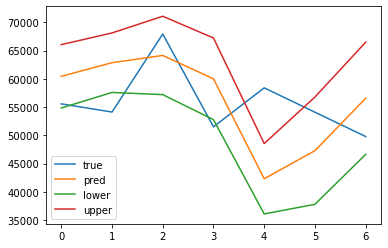

In [596]:
df.plot(use_index = True)

In [ ]:
def predict_with_pi(ensemble, X1_test):
    # make predictions
    for i in range(0,1):
    yhat = [model.predict(X, verbose=0) for model in ensemble]
    yhat = asarray(yhat)
    # calculate 95% gaussian prediction interval
    interval = 1.96 * yhat.std()
    lower, upper = yhat.mean() - interval, yhat.mean() + interval
    print('Point prediction: %.3f' % mean)
    print('95%% prediction interval: [%.3f, %.3f]' % (lower, upper))
    print('True value: %.3f' % y_test[0][0])
    #return lower, yhat.mean(), upper

In [548]:
pred_days["0"]

{'true': [63583.0,
  62308.0,
  59705.0,
  53827.0,
  48794.0,
  57202.0,
  73121.0,
  50741.0,
  63182.0,
  58603.0,
  44181.0,
  58868.0,
  36113.0,
  59869.0,
  71850.0,
  76903.0,
  38939.0,
  84117.0,
  53691.0,
  77225.0,
  47643.0,
  55578.0,
  58125.0,
  30311.0,
  66198.0,
  43996.0,
  61354.0,
  48229.0,
  66104.0,
  66387.0,
  58457.0,
  43362.0,
  55821.5,
  67691.0,
  48982.0,
  61665.0,
  46005.5,
  45421.0,
  51705.0,
  72894.0,
  33003.0,
  38878.0,
  42750.0,
  49666.0,
  62364.0,
  46235.0,
  38961.0,
  70110.0,
  49629.0,
  50026.666666666664,
  52236.0,
  68376.75,
  48830.0,
  68423.0,
  54458.5,
  57987.0,
  87410.0,
  39922.5,
  63761.0,
  80503.0,
  75725.0,
  63734.0,
  60312.0,
  33825.0,
  56733.0,
  80136.0,
  32130.0,
  58522.0,
  41027.0,
  50609.0,
  54608.0,
  83057.0,
  53530.5,
  34211.0,
  75104.0,
  23009.0,
  17125.0,
  81562.0,
  59901.0,
  49815.0,
  55171.0,
  58121.0,
  71343.0,
  59211.0,
  25782.0,
  76927.0,
  77164.0,
  56782.0,
  73436.0,
 

In [ ]:
fig = plt.figure(figsize=(40,30))

plt.plot(y_test[45:50,0])
plt.plot(predictions_cnn[45:50,0])

plt.legend(['right', 'pred'], loc='upper left',fontsize=30)
#plt.figure(figsize=(50,60))
plt.show()